# Define the sample of proto-MW/Heracles stars to do the fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import cmasher as cm
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/dr17_dr3_McMillan_astroNN_rev1.fits'
tb = fits.open(path)
data = tb[1].data 

print(len(data))

733900


# Define the parent sample, and remove all stars belonging to GCs, MCs, etc

In [3]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE VAC DATA FOR THE GCs in APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_members_VAC.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7260 GC stars


In [4]:
apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [5]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()


683198

In [6]:
aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

691590

In [7]:
# get the SGR stars from Horta et al 2023
loadpath =  '/Users/dhortadarrington/Documents/Projects/accreted-systems/sav/paper/'
mask_sgr = np.load(loadpath+'mask_sgr.npy')

# Remove the MCs
lmc_ids = np.loadtxt('/Users/dhortadarrington/Documents/Master/data/LMC_ID_final.txt',dtype='str')
smc_ids = np.loadtxt('/Users/dhortadarrington/Documents/Master/data/SMC_ID_final.txt',dtype='str')
lmc_id = np.isin(list(data['APOGEE_ID']),list(lmc_ids))
smc_id = np.isin(list(data['APOGEE_ID']),list(smc_ids))


In [8]:
dist = data['weighted_dist']
dist_err = (data['weighted_dist'] - data['weighted_dist'])/2.

# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['TEFF']>4000.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['EXTRATARG']==0)\
    &(dist/dist_err>10.)&(data['AL_FE_FLAG']==0)&(data['MG_FE_FLAG']==0)&(data['MN_FE_FLAG']==0)\
    &(data['FE_H']>-10)&(data['AL_FE']>-10)&(data['MG_FE']>-10)&(data['MN_FE']>-10)

print('There are '+str(len(data[mask]))+' stars in the parent sample')

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_66370/2365025784.py:7: RuntimeWarning: divide by zero encountered in divide
  &(dist/dist_err>10.)&(data['AL_FE_FLAG']==0)&(data['MG_FE_FLAG']==0)&(data['MN_FE_FLAG']==0)\


There are 194257 stars in the parent sample


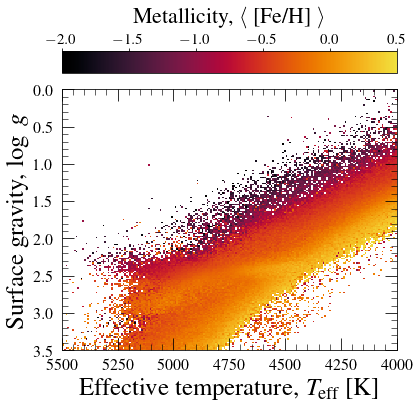

In [10]:
# plot the Kiel diagram
from scipy import stats

fig = plt.figure(figsize=(6,6), facecolor='white')
nbins = 200
binx = np.linspace(np.min(data['TEFF'][mask]),np.max(data['TEFF'][mask]),nbins)
biny = np.linspace(np.min(data['LOGG'][mask]),np.max(data['LOGG'][mask]),nbins)
hist = stats.binned_statistic_2d(data['TEFF'][mask],data['LOGG'][mask], data['FE_H'][mask], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-2.,vmax=0.5, rasterized=True)
    
plt.xlabel('Effective temperature, $T_{\mathrm{eff}}$ [K]', fontsize=25)
plt.ylabel('Surface gravity, $\log~g$', fontsize=25)
plt.xlim(5500,4000)
plt.ylim(3.5,0)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'Metallicity, $\langle$ [Fe/H] $\rangle$',fontsize=22,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/halo-density/plots/kiel.pdf',dpi=200, bbox_inches = 'tight')



In [9]:
mgmn = data['MG_FE'] - data['MN_FE']
mask_une = (((mgmn >= 0.15) & (data['AL_FE'] <= -0.2)) |  \
            ((data['AL_FE'] > -0.2) & (mgmn >= 2.*data['AL_FE']+0.6)) )
print(len(data[mask&mask_une]))

4531


(array([  24.,   35.,   35.,   36.,   84.,  223.,  522., 1009., 1774.,
         626.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-2.        , -1.86956522, -1.73913043, -1.60869565, -1.47826087,
        -1.34782609, -1.2173913 , -1.08695652, -0.95652174, -0.82608696,
        -0.69565217, -0.56521739, -0.43478261, -0.30434783, -0.17391304,
        -0.04347826,  0.08695652,  0.2173913 ,  0.34782609,  0.47826087,
         0.60869565,  0.73913043,  0.86956522,  1.        ]),
 <BarContainer object of 23 artists>)

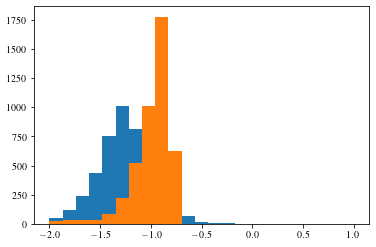

In [12]:
plt.hist(data['FE_H'][mask&mask_une],np.linspace(-2,1.,24))
plt.hist(data['FE_H'][mask&~mask_une&(data["FE_H"]<-0.8)],np.linspace(-2,1.,24))


In [226]:
mask_higha = ~mask_une & (mgmn>= -0.706*data['AL_FE']+0.4)
print(len(data[mask&mask_higha]))

46325


In [227]:
print(len(data['MN_FE'][mask&mask_une&(data['FE_H']<-1.6)]))
print(len(data['MN_FE'][mask&mask_une]))

450
4531


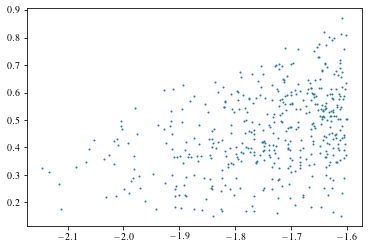

In [152]:
plt.scatter(data['FE_H'][mask&mask_une&(data['FE_H']<-1.6)], mgmn[mask&mask_une&(data['FE_H']<-1.6)],s=1)

In [192]:
hydro = (data['MG_FE'] + data['O_FE'])/2
exp = (data['SI_FE'] + data['CA_FE'])/2

hexs = hydro/exp


(-0.5, 3.0)

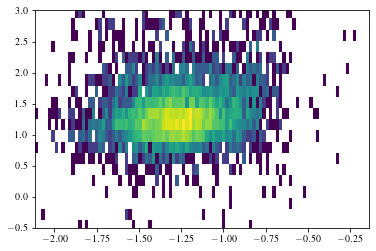

In [195]:
from matplotlib.colors import LogNorm
mask_ab = (np.abs(hexs)<10)&(np.abs(data['FE_H'])<10)
plt.hist2d(data['FE_H'][mask&mask_une&mask_ab],hexs[mask&mask_une&mask_ab], bins=100, norm=LogNorm())
plt.ylim(-0.5,3)

In [202]:
rapo = np.load('../sav/rapo_gala.npy')

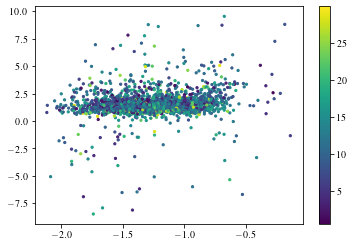

In [210]:
from matplotlib.colors import LogNorm
mask_ab = (np.abs(hexs)<10)&(np.abs(data['FE_H'])<10)&(rapo<30)&(rapo>0)
plt.scatter(data['FE_H'][mask&mask_une&mask_ab],hexs[mask&mask_une&mask_ab], s=5, c=rapo[mask&mask_une&mask_ab])
plt.colorbar()
# plt.ylim(-0.,3)


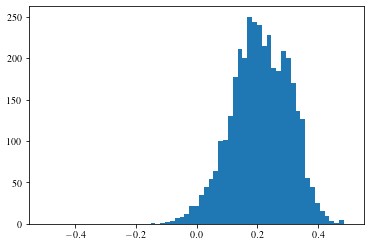

In [216]:
plt.hist(data['MG_FE'][mask&mask_une&mask_ab], bins=np.linspace(-0.5,0.5,64))
plt.show()

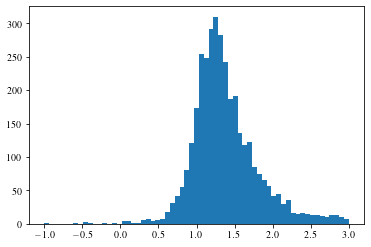

In [213]:
plt.hist(hexs[mask&mask_une&mask_ab], bins=np.linspace(-1,3,64))
plt.show()

(array([25., 25., 29., 24., 29., 39., 36., 44., 50., 41., 35., 27., 34.,
        50., 43., 50., 55., 49., 62., 41., 55., 51., 69.]),
 array([-1.3       , -1.28695652, -1.27391304, -1.26086957, -1.24782609,
        -1.23478261, -1.22173913, -1.20869565, -1.19565217, -1.1826087 ,
        -1.16956522, -1.15652174, -1.14347826, -1.13043478, -1.1173913 ,
        -1.10434783, -1.09130435, -1.07826087, -1.06521739, -1.05217391,
        -1.03913043, -1.02608696, -1.01304348, -1.        ]),
 <BarContainer object of 23 artists>)

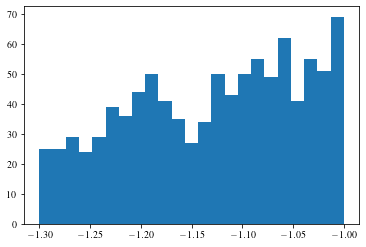

In [233]:
plt.hist(data['FE_H'][mask*(data['FE_H']<-1)&(data['FE_H']>-1.3)&(rads<5)], np.linspace(-1.3,-1,24))

(-0.0, 1.0)

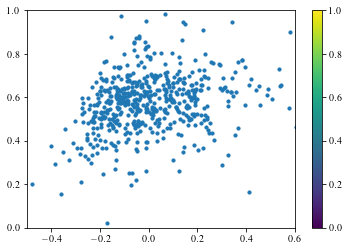

In [236]:
plt.scatter(data['AL_FE'][mask*(data['FE_H']<-1.1)&(data['FE_H']>-1.3)&(rads<5)], mgmn[mask*(data['FE_H']<-1.1)&(data['FE_H']>-1.3)&(rads<5)],s=10)
plt.colorbar()
plt.xlim(-0.5,0.6)
plt.ylim(-0.,1)

(-0.4, 1.0)

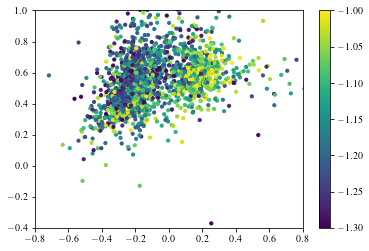

In [162]:
plt.scatter(data['AL_FE'][mask*(data['FE_H']<-1)&(data['FE_H']>-1.3)&(rads>5)], mgmn[mask*(data['FE_H']<-1)&(data['FE_H']>-1.3)&(rads>5)],s=10, c= data['FE_H'][mask*(data['FE_H']<-1)&(data['FE_H']>-1.3)&(rads>5)], vmin=-1.3, vmax=-1)
plt.colorbar()
plt.xlim(-0.8,0.8)
plt.ylim(-0.4,1)

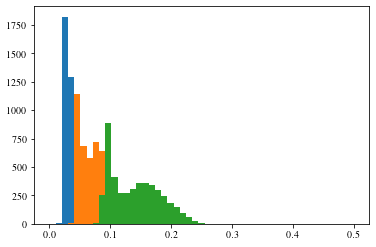

In [143]:
plt.hist(data['AL_FE_ERR'][mask&mask_une], bins=np.linspace(0,0.5,50))
plt.hist(data['AL_FE_ERR'][mask&mask_une]*2, bins=np.linspace(0,0.5,50))
plt.hist(data['AL_FE_ERR'][mask&mask_une]*4, bins=np.linspace(0,0.5,50))
plt.show()

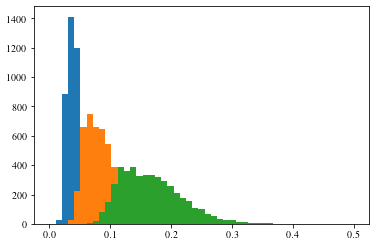

In [144]:
plt.hist(data['MN_FE_ERR'][mask&mask_une], bins=np.linspace(0,0.5,50))
plt.hist(data['MN_FE_ERR'][mask&mask_une]*2, bins=np.linspace(0,0.5,50))
plt.hist(data['MN_FE_ERR'][mask&mask_une]*4, bins=np.linspace(0,0.5,50))
plt.show()

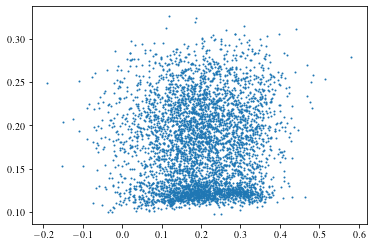

In [142]:
plt.scatter(data['MG_FE'][mask&mask_une],inflated_al_err[mask*mask_une],s=1)


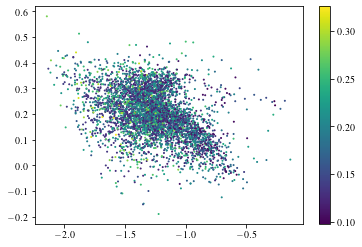

In [135]:
inflated_al_err = data['AL_FE_ERR']*5

plt.scatter(data['FE_H'][mask&mask_une], data['MG_FE'][mask&mask_une],c=inflated_al_err[mask*mask_une], s=1)
plt.colorbar()

In [119]:
len(data['FE_H'][mask&mask_higha&(data['FE_H']<-1.3)&(data['FE_H']>-1.6)])

131

(array([ 4.,  2.,  2.,  5.,  7.,  5., 18., 18., 37., 33.]),
 array([-1.59909999, -1.56921005, -1.53931999, -1.50942993, -1.47953999,
        -1.44965005, -1.41975999, -1.38986993, -1.35997999, -1.33009005,
        -1.30019999]),
 <BarContainer object of 10 artists>)

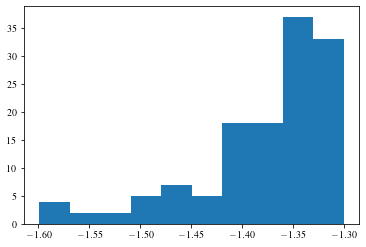

In [108]:
plt.hist(data['FE_H'][mask&mask_higha&(data['FE_H']<-1.3)&(data['FE_H']>-1.6)])


In [11]:
from matplotlib.colors import LogNorm

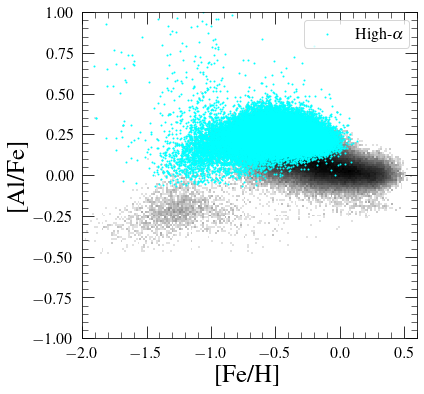

In [17]:
fig = plt.figure(figsize=(6,6), facecolor='white')
plt.hist2d(data['FE_H'][mask], data['AL_FE'][mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['FE_H'][mask&mask_higha], data['AL_FE'][mask&mask_higha], s=1, c='cyan', label=r'High-$\alpha$')
# plt.scatter(data['FE_H'][mask&mask_une], data['AL_FE'][mask&mask_une], s=1, c='r', label='Unevolved')
plt.xlabel('[Fe/H]', fontsize=25)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('[Al/Fe]', fontsize=25)
plt.xlim(-2,0.6)
plt.ylim(-1.,1)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


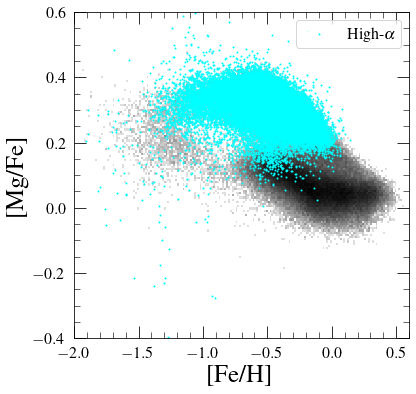

In [35]:
fig = plt.figure(figsize=(6,6), facecolor='white')
plt.hist2d(data['FE_H'][mask], data['MG_FE'][mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['FE_H'][mask&mask_higha], data['MG_FE'][mask&mask_higha], s=1, c='cyan', label=r'High-$\alpha$')
# plt.scatter(data['FE_H'][mask&mask_une], data['AL_FE'][mask&mask_une], s=1, c='r', label='Unevolved')
plt.xlabel('[Fe/H]', fontsize=25)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('[Mg/Fe]', fontsize=25)
plt.xlim(-2,0.6)
plt.ylim(-0.4,0.6)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


In [42]:
# LOAD THE n-rich stars to see if they are in our sample
path = '/Users/dhortadarrington/Documents/Projects/halo-density/data/dr17_dr3_McMillan_astroNN_rev1.fits'
tb = fits.open(path)
allstar = tb[1].data 

path2 = '/Users/dhortadarrington/Documents/Projects/halo-density/n-rich-schiavon-files/IDs_acc_hialph.fits'
tb2 = fits.open(path2)
nrich_acc_higha = tb2[1].data 

path3 = '/Users/dhortadarrington/Documents/Projects/halo-density/n-rich-schiavon-files/IDs_insitu.fits'
tb3 = fits.open(path3)
nrich_insitu = tb3[1].data 

path4 = '/Users/dhortadarrington/Documents/Projects/halo-density/n-rich-schiavon-files/IDs_acc_mealph.fits'
tb4 = fits.open(path4)
nrich_acc_mealph = tb4[1].data 

path5 = '/Users/dhortadarrington/Documents/Projects/halo-density/n-rich-schiavon-files/IDs_acc_loalph.fits'
tb5 = fits.open(path5)
nrich_acc_loalph = tb5[1].data 



In [44]:
m_acc_higha = np.isin(list(data['APOGEE_ID'][mask&mask_higha]), list(nrich_acc_higha['APOGEE_ID']))
m_acc_mea = np.isin(list(data['APOGEE_ID'][mask&mask_higha]), list(nrich_acc_mealph['APOGEE_ID']))
m_acc_lowa = np.isin(list(data['APOGEE_ID'][mask&mask_higha]), list(nrich_acc_loalph['APOGEE_ID']))
m_insitu = np.isin(list(data['APOGEE_ID'][mask&mask_higha]), list(nrich_insitu['APOGEE_ID']))
print(len(data[mask&mask_higha][m_acc_higha]), len(data[mask&mask_higha][m_acc_mea]),\
     len(data[mask&mask_higha][m_acc_lowa]), len(data[mask&mask_higha][m_insitu]))

65 23 21 45


In [45]:
print(len(data['APOGEE_ID'][mask&mask_higha]))

46325


In [50]:
simn = data['SI_FE']-data['MN_FE']

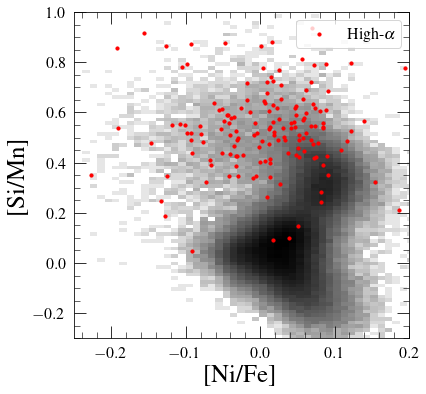

In [66]:
fig = plt.figure(figsize=(6,6), facecolor='white')
plt.hist2d(data['NI_FE'][mask&(data['NI_FE']>-10)&(data['SI_FE']>-10)], simn[mask&(data['NI_FE']>-10)&(data['SI_FE']>-10)], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['NI_FE'][mask&mask_higha&(data['FE_H']<-1.3)], simn[mask&mask_higha&(data['FE_H']<-1.3)], s=10, c='r', label=r'High-$\alpha$')
# plt.colorbar()
# plt.scatter(data['NI_FE'][mask&mask_higha][m_acc_higha], data['MN_FE'][mask&mask_higha][m_acc_higha], s=1, c='r', label=r'N-rich stars')
# plt.scatter(data['NI_FE'][mask&mask_higha][m_acc_mea], data['MN_FE'][mask&mask_higha][m_acc_mea], s=1, c='r', label=r'N-rich stars')
# plt.scatter(data['NI_FE'][mask&mask_higha][m_acc_lowa], data['MN_FE'][mask&mask_higha][m_acc_lowa], s=1, c='r', label=r'N-rich stars')
# plt.scatter(data['NI_FE'][mask&mask_higha][m_insitu], data['MN_FE'][mask&mask_higha][m_insitu], s=1, c='r', label=r'N-rich stars')
# plt.scatter(data['FE_H'][mask&mask_une], data['AL_FE'][mask&mask_une], s=1, c='r', label='Unevolved')
plt.xlabel('[Ni/Fe]', fontsize=25)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('[Si/Mn]', fontsize=25)
plt.xlim(-0.25,0.2)
plt.ylim(-0.3,1.)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

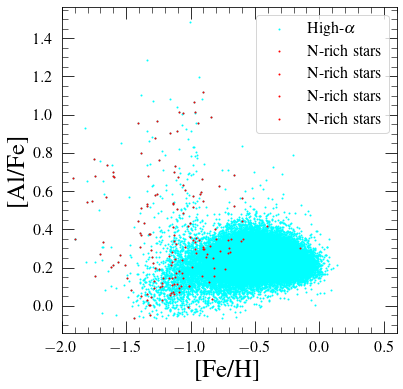

In [85]:
fig = plt.figure(figsize=(6,6), facecolor='white')
# plt.hist2d(data['FE_H'][mask], data['AL_FE'][mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['FE_H'][mask&mask_higha], data['AL_FE'][mask&mask_higha], s=1, c='cyan', label=r'High-$\alpha$')
plt.scatter(data['FE_H'][mask&mask_higha][m_acc_higha], data['AL_FE'][mask&mask_higha][m_acc_higha], s=1, c='r', label=r'N-rich stars')
plt.scatter(data['FE_H'][mask&mask_higha][m_acc_mea], data['AL_FE'][mask&mask_higha][m_acc_mea], s=1, c='r', label=r'N-rich stars')
plt.scatter(data['FE_H'][mask&mask_higha][m_acc_lowa], data['AL_FE'][mask&mask_higha][m_acc_lowa], s=1, c='r', label=r'N-rich stars')
plt.scatter(data['FE_H'][mask&mask_higha][m_insitu], data['AL_FE'][mask&mask_higha][m_insitu], s=1, c='r', label=r'N-rich stars')
# plt.scatter(data['FE_H'][mask&mask_une], data['AL_FE'][mask&mask_une], s=1, c='r', label='Unevolved')
plt.xlabel('[Fe/H]', fontsize=25)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('[Al/Fe]', fontsize=25)
plt.xlim(-2,0.6)
# plt.ylim(-0.4,0.6)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

In [49]:
print(len(data['AL_FE'][mask&mask_higha&(data['FE_H']<-1.5)]))
print(len(data['AL_FE'][mask&mask_higha&(data['FE_H']<-1.5)]))

43


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


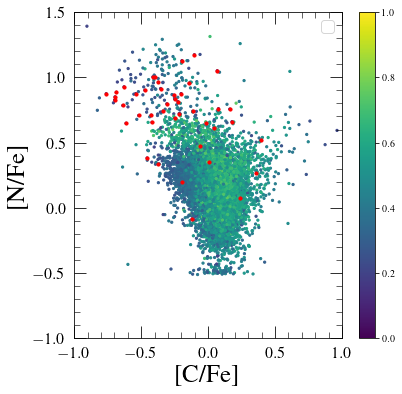

In [34]:
fig = plt.figure(figsize=(6,6), facecolor='white')
# plt.hist2d(data['C_FE'][mask], data['N_FE'][mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['C_FE'][mask&mask_higha], data['N_FE'][mask&mask_higha], s=5, c=data['FE_H'][mask&mask_higha], vmin=-2,vmax=0.6)
plt.scatter(data['C_FE'][mask&mask_higha&(data['FE_H']<-1.5)], data['N_FE'][mask&mask_higha&(data['FE_H']<-1.5)], s=10, c='r')
# plt.scatter(data['FE_H'][mask&mask_une], data['AL_FE'][mask&mask_une], s=1, c='r', label='Unevolved')
plt.xlabel('[C/Fe]', fontsize=25)
plt.colorbar()
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('[N/Fe]', fontsize=25)
plt.xlim(-1,1)
plt.ylim(-1.,1.5)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


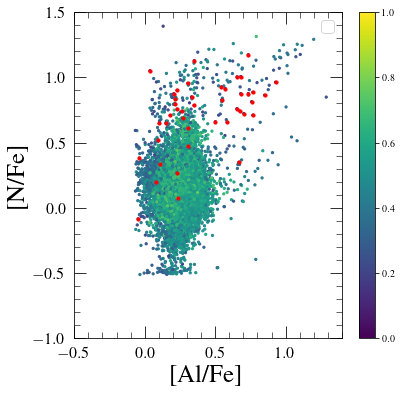

In [39]:
fig = plt.figure(figsize=(6,6), facecolor='white')
# plt.hist2d(data['C_FE'][mask], data['N_FE'][mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['AL_FE'][mask&mask_higha], data['N_FE'][mask&mask_higha], s=5, c=data['FE_H'][mask&mask_higha], vmin=-2,vmax=0.6)
plt.scatter(data['AL_FE'][mask&mask_higha&(data['FE_H']<-1.5)], data['N_FE'][mask&mask_higha&(data['FE_H']<-1.5)], s=10, c='r')
# plt.scatter(data['FE_H'][mask&mask_une], data['AL_FE'][mask&mask_une], s=1, c='r', label='Unevolved')
plt.xlabel('[Al/Fe]', fontsize=25)
plt.colorbar()
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('[N/Fe]', fontsize=25)
plt.xlim(-0.5,1.4)
plt.ylim(-1.,1.5)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


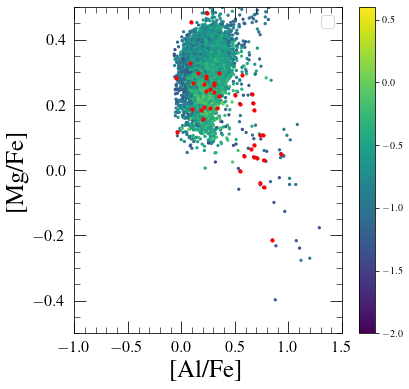

In [41]:
fig = plt.figure(figsize=(6,6), facecolor='white')
# plt.hist2d(data['C_FE'][mask], data['N_FE'][mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['AL_FE'][mask&mask_higha], data['MG_FE'][mask&mask_higha], s=5, c=data['FE_H'][mask&mask_higha], vmin=-2,vmax=0.6)
plt.colorbar()
plt.scatter(data['AL_FE'][mask&mask_higha&(data['FE_H']<-1.5)], data['MG_FE'][mask&mask_higha&(data['FE_H']<-1.5)], s=10, c='r')
# plt.scatter(data['FE_H'][mask&mask_une], data['AL_FE'][mask&mask_une], s=1, c='r', label='Unevolved')
plt.xlabel('[Al/Fe]', fontsize=25)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('[Mg/Fe]', fontsize=25)
plt.xlim(-1,1.5)
plt.ylim(-0.5,0.5)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


In [24]:
mask_line = (data['MG_FE'] >= -0.3*data['FE_H']-0.1)

mask_acc_vasily = (data['FE_H']<-0.4) & (data['AL_FE']<-0.07)&~mask_line
mask_is_vasily = (data['FE_H']<-0.4) & (data['AL_FE']>-0.07)&mask_line

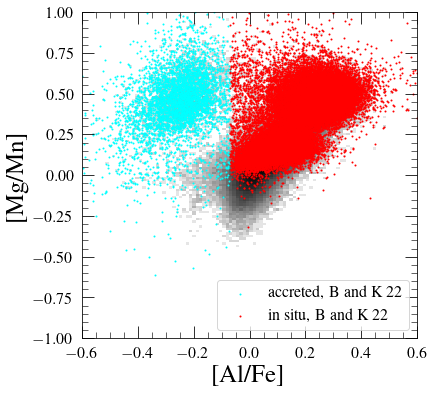

In [25]:
fig = plt.figure(figsize=(6,6), facecolor='white')
plt.hist2d(data['AL_FE'][mask], mgmn[mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['AL_FE'][mask&mask_acc_vasily], mgmn[mask&mask_acc_vasily], s=1, c='cyan', label=r'accreted, B and K 22')
plt.scatter(data['AL_FE'][mask&mask_is_vasily], mgmn[mask&mask_is_vasily], s=1, c='r', label=r'in situ, B and K 22')
plt.xlabel('[Al/Fe]', fontsize=25)
plt.legend(loc='lower right', fontsize=16)
plt.ylabel('[Mg/Mn]', fontsize=25)
plt.xlim(-0.6,0.6)
plt.ylim(-1.,1)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

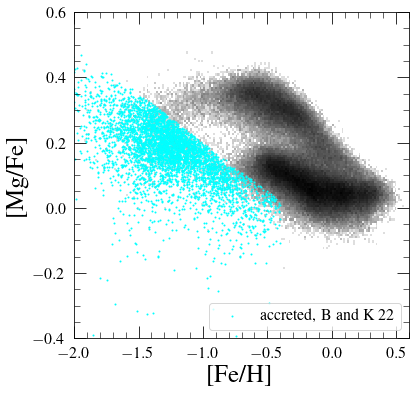

In [26]:
fig = plt.figure(figsize=(6,6), facecolor='white')
plt.hist2d(data['FE_H'][mask], data['MG_FE'][mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['FE_H'][mask&mask_acc_vasily], data['MG_FE'][mask&mask_acc_vasily], s=1, c='cyan', label=r'accreted, B and K 22')
# plt.scatter(data['FE_H'][mask&mask_is_vasily], data['MG_FE'][mask&mask_is_vasily], s=1, c='r', label=r'in situ, B and K 22')
plt.xlabel('[Fe/H]', fontsize=25)
plt.legend(loc='lower right', fontsize=16)
plt.ylabel('[Mg/Fe]', fontsize=25)
plt.xlim(-2,0.6)
plt.ylim(-0.4,0.6)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

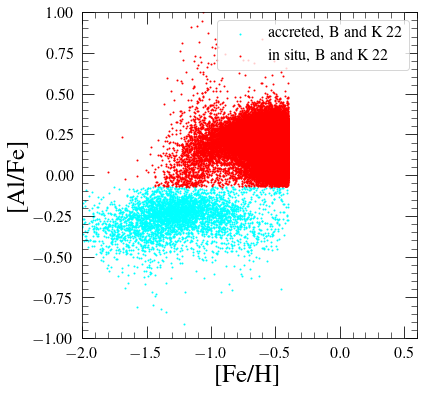

In [84]:
fig = plt.figure(figsize=(6,6), facecolor='white')
# plt.hist2d(data['FE_H'][mask], data['AL_FE'][mask], bins=200, norm=LogNorm(), cmap='binary')
plt.scatter(data['FE_H'][mask&mask_acc_vasily], data['AL_FE'][mask&mask_acc_vasily], s=1, c='cyan', label=r'accreted, B and K 22')
plt.scatter(data['FE_H'][mask&mask_is_vasily], data['AL_FE'][mask&mask_is_vasily], s=1, c='r', label=r'in situ, B and K 22')
plt.xlabel('[Fe/H]', fontsize=25)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('[Al/Fe]', fontsize=25)
plt.xlim(-2,0.6)
plt.ylim(-1.,1)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


In [12]:
np.save('../sav/mask_parent',mask)
np.save('../sav/mask_unevolved',mask_une)

# plot the magnamal plane to get an idea of stellar populations

In [76]:
Rgal = data['Rgal']*8.275
vphi = data['vT']*220.
Lz = Rgal * vphi

(array([1.20000e+01, 8.60000e+01, 8.99800e+03, 6.15870e+04, 1.18695e+05,
        4.83900e+03, 3.30000e+01, 2.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-3997.69383413, -2598.65485412, -1199.61587411,   199.4231059 ,
         1598.46208591,  2997.50106592,  4396.54004593,  5795.57902594,
         7194.61800595,  8593.65698596,  9992.69596597]),
 <BarContainer object of 10 artists>)

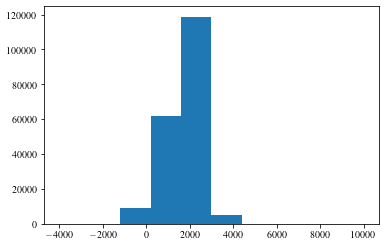

In [77]:
plt.hist(Lz[mask&(np.abs(Lz)<1e4)])

NameError: name 'stats' is not defined

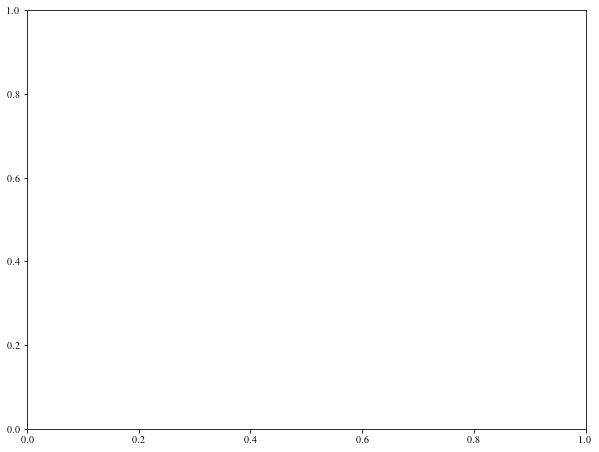

In [78]:
nbins = 500

fig = plt.figure(figsize=(16,12),constrained_layout=True,facecolor='white')

plt.subplot(2,2,1)
binx = np.linspace(np.min(data['AL_FE'][mask&~mask_une]),np.max(data['AL_FE'][mask&~mask_une]),nbins)
biny = np.linspace(np.min(mgmn[mask&~mask_une]),np.max(mgmn[mask&~mask_une]),nbins)
hist = stats.binned_statistic_2d(data['AL_FE'][mask&~mask_une],mgmn[mask&~mask_une], data['FE_H'][mask&~mask_une], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-2.,vmax=0.5, rasterized=True, alpha=0.5)

# plt.scatter(data['AL_FE'][mask],mgmn[mask],s=5, c=data['FE_H'][mask],\
#                cmap=cm.ember, vmin=-2.5,vmax=1, alpha=0.1)
color = plt.scatter(data['AL_FE'][mask&mask_une],mgmn[mask&mask_une],s=5, c=data['FE_H'][mask&mask_une],\
               cmap=cm.ember, vmin=-2.5,vmax=1, alpha=1)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(-0.5,0.8,r'Unevolved',fontsize=20,bbox=props)
# plt.text(0.35,0.,r'Evolved',fontsize=20,bbox=props)
plt.text(0.25,0.75,r'High-$\alpha$ disc',fontsize=20,bbox=props)
plt.text(0.2,-0.3,r'Low-$\alpha$ disc',fontsize=20,bbox=props)

plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.plot([-0.22,0.2], [0.15,1], c='k', lw=2, ls='dashed')
plt.plot([-0.6,-0.22], [0.15,0.15], c='k', lw=2, ls='dashed')
plt.plot([-0.08,0.6], [0.45,-0.05], c='k', lw=2, ls='dashed')
plt.plot([-0.08,0.6], [0.45,-0.05], c='k', lw=2, ls='dashed')

cbar_ax = fig.add_axes([0.135, 1.03, 0.27,0.03])
cb = plt.colorbar(color, cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'[Fe/H]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(2,2,2)
binx = np.linspace(np.min(data['AL_FE'][mask&~mask_une&(np.abs(Lz)<1e4)]),np.max(data['AL_FE'][mask&~mask_une&(np.abs(Lz)<1e4)]),nbins)
biny = np.linspace(np.min(mgmn[mask&~mask_une&(np.abs(Lz)<1e4)]),np.max(mgmn[mask&~mask_une&(np.abs(Lz)<1e4)]),nbins)
hist = stats.binned_statistic_2d(data['AL_FE'][mask&~mask_une&(np.abs(Lz)<1e4)],mgmn[mask&~mask_une&(np.abs(Lz)<1e4)], Lz[mask&~mask_une&(np.abs(Lz)<1e4)], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.cosmic,vmin=-1000,vmax=3500, rasterized=True, alpha=0.5)

# plt.scatter(data['AL_FE'][mask],mgmn[mask],s=5, c=vphi[mask],\
#                cmap=cm.cosmic, vmin=-300,vmax=300, alpha=0.1)
color = plt.scatter(data['AL_FE'][mask&mask_une&(np.abs(Lz)<1e4)],mgmn[mask&mask_une&(np.abs(Lz)<1e4)],s=5, c=Lz[mask&mask_une&(np.abs(Lz)<1e4)],\
               cmap=cm.cosmic, vmin=-1000,vmax=3500, alpha=1)
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.plot([-0.22,0.2], [0.15,1], c='k', lw=2, ls='dashed')
plt.plot([-0.6,-0.22], [0.15,0.15], c='k', lw=2, ls='dashed')
plt.plot([-0.08,0.6], [0.45,-0.05], c='k', lw=2, ls='dashed')
plt.plot([-0.08,0.6], [0.45,-0.05], c='k', lw=2, ls='dashed')


cbar_ax = fig.add_axes([0.65, 1.03, 0.27,0.03])
cb = plt.colorbar(color, cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'$L_{z}$ [kpc km/s]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')


plt.subplot(2,2,3)
plt.hist(data['FE_H'][mask&~mask_une],bins=np.linspace(-2.5,1,51),histtype='step', color= 'darkorange', lw=4, density=True, label='Evolved')
plt.hist(data['FE_H'][mask&mask_une],bins=np.linspace(-2.5,1,51),histtype='step', color= 'maroon', lw=4, density=True, label='Unevolved')
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('Norm. Number density', fontsize=30)
plt.xlim(-2.5,1)
plt.ylim(0,2.)
plt.legend(loc='upper center', frameon=False, fontsize=20, ncols=2)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,2,4)
plt.hist(Lz[mask&~mask_une&(np.abs(Lz)<1e4)],bins=np.linspace(-1000,3500,51),histtype='step', color= 'cyan', lw=4, density=True, label='Evolved')
plt.hist(Lz[mask&mask_une&(np.abs(Lz)<1e4)],bins=np.linspace(-1000,3500,51),histtype='step', color= 'b', lw=4, density=True, label='Unevolved')
plt.xlabel('$L_{z}$ [km/s]', fontsize=30)
plt.ylabel('Norm. Number density', fontsize=30)
plt.xlim(-1000,3500)
plt.ylim(0,0.0015)
plt.legend(loc='upper center', frameon=False, fontsize=20, ncols=2)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

fig.savefig('../plots/magnamal-intro.pdf',dpi=150)



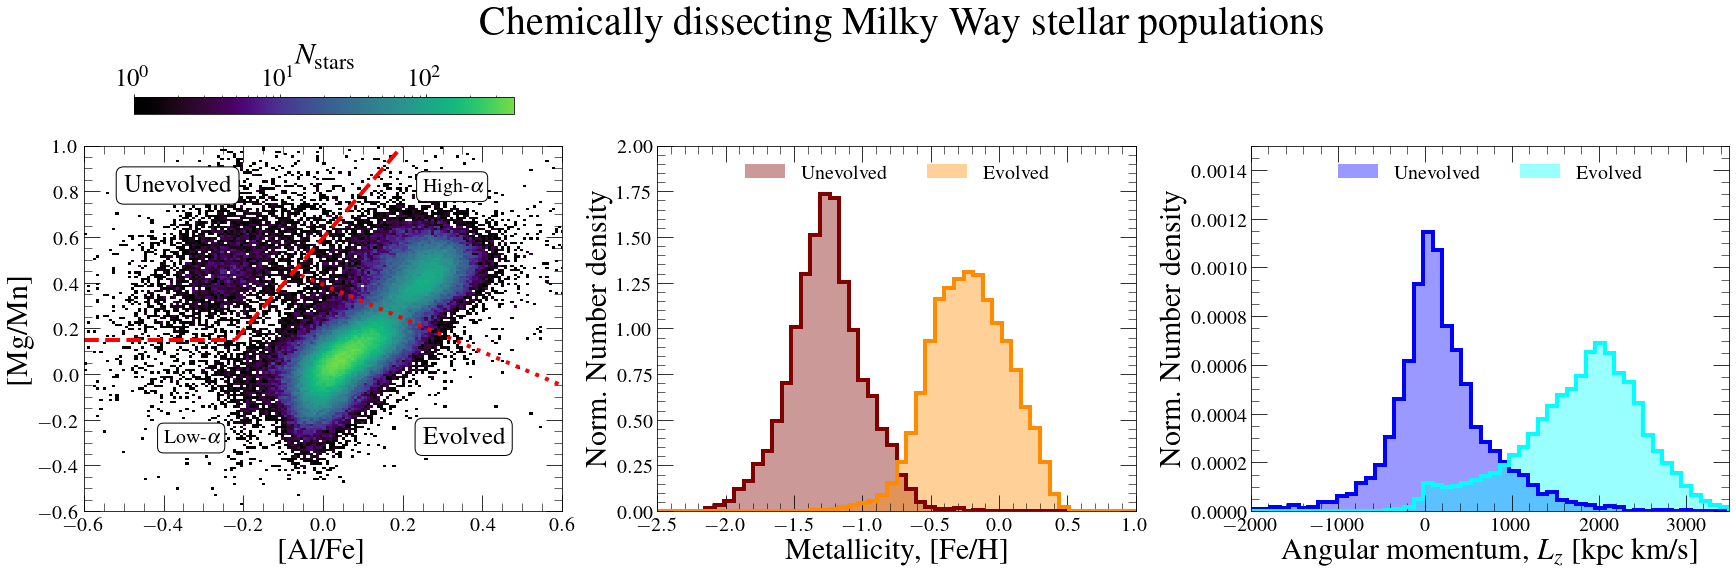

In [83]:
nbins = 500

fig = plt.figure(figsize=(24,6),constrained_layout=True,facecolor='white')

fig.suptitle('Chemically dissecting Milky Way stellar populations',fontsize=40,x=0.52,y=1.3)

plt.subplot(1,3,1)
# binx = np.linspace(np.min(data['AL_FE'][mask&~mask_une]),np.max(data['AL_FE'][mask&~mask_une]),nbins)
# biny = np.linspace(np.min(mgmn[mask&~mask_une]),np.max(mgmn[mask&~mask_une]),nbins)
# hist = stats.binned_statistic_2d(data['AL_FE'][mask&~mask_une],mgmn[mask&~mask_une], data['FE_H'][mask&~mask_une], statistic='mean', bins=[binx,biny])
# plot_x, plot_y = np.meshgrid(binx,biny) 
# plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-2.,vmax=0.5, rasterized=True, alpha=0.5)
# color = plt.scatter(data['AL_FE'][mask&mask_une],mgmn[mask&mask_une],s=5, c=data['FE_H'][mask&mask_une],\
#                cmap=cm.ember, vmin=-2.5,vmax=1, alpha=1)

plt.hist2d(data['AL_FE'][mask],mgmn[mask],bins=300,cmap=cm.lavender, norm=LogNorm())
# plt.hist2d(data['AL_FE'][mask&mask_une],mgmn[mask&mask_une],bins=100,cmap=cm.lavender, norm=LogNorm())

props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(-0.5,0.8,r'Unevolved',fontsize=25,bbox=props)
plt.text(0.25,-0.3,r'Evolved',fontsize=25,bbox=props)
plt.text(0.25,0.8,r'High-$\alpha$',fontsize=20,bbox=props)
plt.text(-0.4,-0.3,r'Low-$\alpha$',fontsize=20,bbox=props)

plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
plt.plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
plt.plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')

cbar_ax = fig.add_axes([0.075, 1.05, 0.22,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'$N_{\mathrm{stars}}$',fontsize=30)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')


plt.subplot(1,3,2)
plt.hist(data['FE_H'][mask&mask_une],bins=np.linspace(-2.5,1,51),histtype='step', color= 'maroon', lw=4, density=True)
plt.hist(data['FE_H'][mask&mask_une],bins=np.linspace(-2.5,1,51), color= 'maroon' ,density=True, label='Unevolved', alpha=0.4)
plt.hist(data['FE_H'][mask&~mask_une],bins=np.linspace(-2.5,1,51),histtype='step', color= 'darkorange', lw=4, density=True)
plt.hist(data['FE_H'][mask&~mask_une],bins=np.linspace(-2.5,1,51), color= 'darkorange', density=True, label='Evolved', alpha=0.4)
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.ylabel('Norm. Number density', fontsize=30)
plt.xlim(-2.5,1)
plt.ylim(0,2.)
plt.legend(loc='upper center', frameon=False, fontsize=20, ncols=2)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,3)
plt.hist(Lz[mask&mask_une&(np.abs(Lz)<1e5)],bins=np.linspace(-2000,3500,51),histtype='step', color= 'b', lw=4, density=True)
plt.hist(Lz[mask&mask_une&(np.abs(Lz)<1e5)],bins=np.linspace(-2000,3500,51), color= 'b', lw=4, density=True, label='Unevolved',alpha=0.4)
plt.hist(Lz[mask&~mask_une&(np.abs(Lz)<1e5)],bins=np.linspace(-2000,3500,51),histtype='step', color= 'cyan', lw=4, density=True)
plt.hist(Lz[mask&~mask_une&(np.abs(Lz)<1e5)],bins=np.linspace(-2000,3500,51), color= 'cyan', lw=4, density=True, label='Evolved',alpha=0.4)
plt.xlabel('Angular momentum, $L_{z}$ [kpc km/s]', fontsize=30)
plt.ylabel('Norm. Number density', fontsize=30)
plt.xlim(-2000,3500)
plt.ylim(0,0.0015)
plt.legend(loc='upper center', frameon=False, fontsize=20, ncols=2)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/magnamal-intro.pdf',dpi=150,bbox_inches='tight')



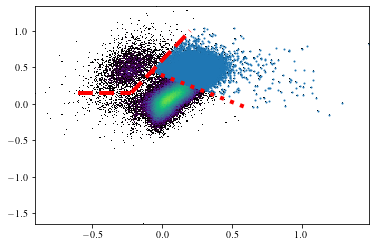

In [80]:
plt.hist2d(data['AL_FE'][mask],mgmn[mask],bins=300,cmap=cm.lavender, norm=LogNorm())
plt.scatter(data['AL_FE'][mask&mask_higha], mgmn[mask&mask_higha], s=1)
plt.plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
plt.plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
plt.plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')

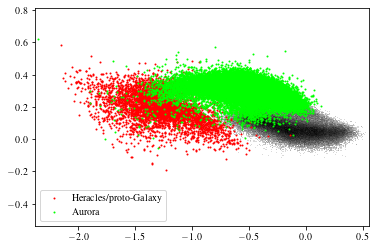

In [133]:
plt.hist2d(data['FE_H'][mask],data['MG_FE'][mask],bins=300,cmap='binary', norm=LogNorm())
plt.scatter(data['FE_H'][mask&mask_une], data['MG_FE'][mask&mask_une], s=1, c='r', label='Heracles/proto-Galaxy')
plt.scatter(data['FE_H'][mask&mask_higha&(data['AL_FE']<0.6)], data['MG_FE'][mask&mask_higha&(data['AL_FE']<0.6)], s=1, c='lime', label='Aurora')
plt.legend(loc='lower left')

plt.show()

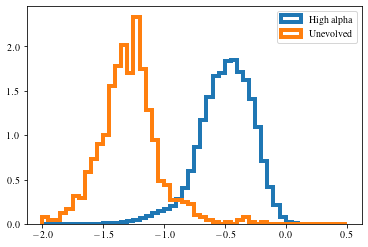

In [138]:
plt.hist(data['FE_H'][mask&mask_higha&(data['AL_FE']<0.6)],np.linspace(-2,0.5,51), histtype='step', lw=4, density=True, label='High alpha')
plt.hist(data['FE_H'][mask&mask_une&(rads<5)],np.linspace(-2,0.5,51), histtype='step', lw=4, density=True, label='Unevolved')
plt.legend(loc='upper right')
plt.show()


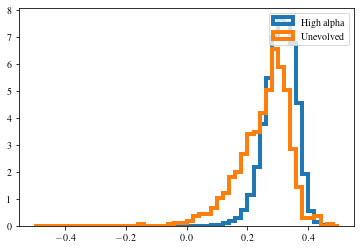

In [139]:
plt.hist(data['MG_FE'][mask&mask_higha&(data['AL_FE']<0.6)],np.linspace(-0.5,0.5,51), histtype='step', lw=4, density=True, label='High alpha')
plt.hist(data['MG_FE'][mask&mask_une&(rads<5)],np.linspace(-0.5,0.5,51), histtype='step', lw=4, density=True, label='Unevolved')
plt.legend(loc='upper right')
plt.show()

(-300000.0, -50000.0)

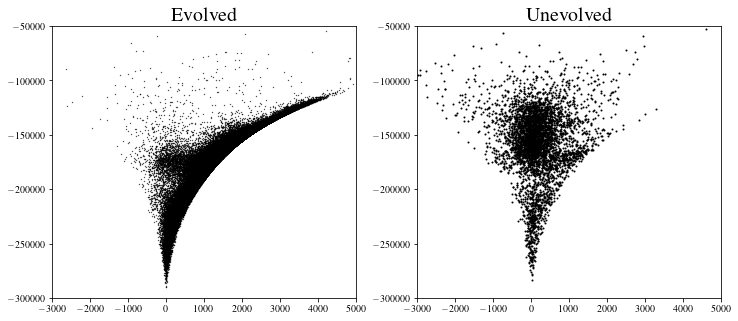

In [25]:
plt.figure(figsize=(12,5), facecolor='white')

plt.subplot(1,2,1)
plt.title('Evolved', fontsize=20)
plt.scatter(Lz[mask&~mask_une], data['Energy'][mask&~mask_une], s=0.1, c='k')
plt.xlim(-3000,5000)
plt.ylim(-300000,-50000)

plt.subplot(1,2,2)
plt.title('Unevolved', fontsize=20)
plt.scatter(Lz[mask&mask_une], data['Energy'][mask&mask_une], s=1, c='k')
plt.xlim(-3000,5000)
plt.ylim(-300000,-50000)


In [29]:
jr = data['Jr']*220.*8.275
jz = data['Jz']*220.*8.275

(0.0, 3000.0)

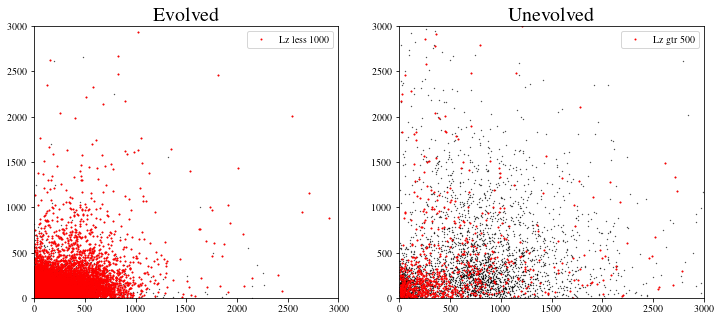

In [36]:
plt.figure(figsize=(12,5), facecolor='white')

plt.subplot(1,2,1)
plt.title('Evolved', fontsize=20)
plt.scatter(jr[mask&~mask_une], jz[mask&~mask_une], s=0.1, c='k')
plt.scatter(jr[mask&~mask_une&(Lz<1000)], jz[mask&~mask_une&(Lz<1000)], s=1, c='r' , label='Lz less 1000')
plt.legend()
plt.xlim(0,3000)
plt.ylim(0,3000)

plt.subplot(1,2,2)
plt.title('Unevolved', fontsize=20)
plt.scatter(jr[mask&mask_une], jz[mask&mask_une], s=0.1, c='k')
plt.scatter(jr[mask&mask_une&(Lz>500)], jz[mask&mask_une&(Lz>500)], s=1, c='r', label='Lz gtr 500')
plt.legend()
plt.xlim(0,3000)
plt.ylim(0,3000)


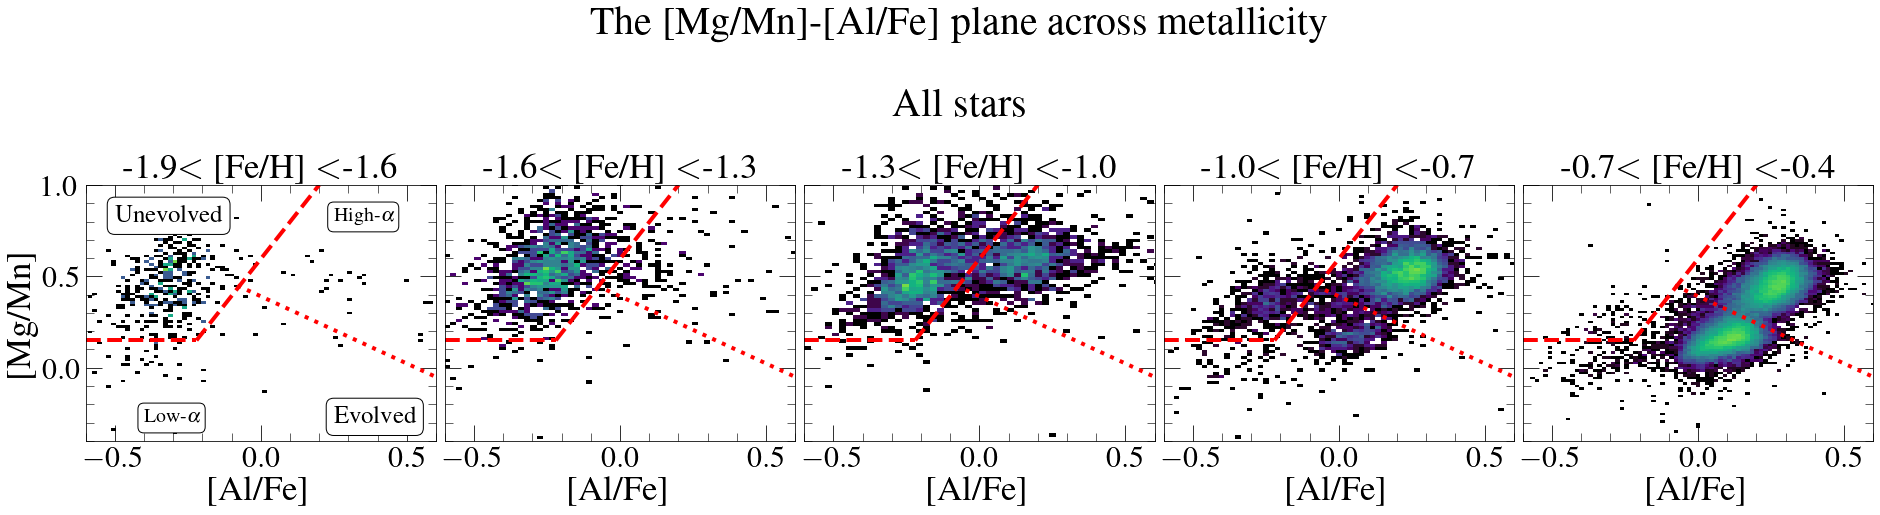

In [53]:
fig, all_axes = plt.subplots(1,5, constrained_layout=True, figsize=(26, 5), sharex=True, sharey=True,rasterized=True)
fehs_bins = np.linspace(-1.9,-0.4,6)

fig.suptitle('The [Mg/Mn]-[Al/Fe] plane across metallicity \n \n All stars',fontsize=40,x=0.51,y=1.4)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=35)    
    all_axes[indx].hist2d(data['AL_FE'][mask&m],mgmn[mask&m],bins=100,cmap=cm.lavender, norm=LogNorm())
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[indx].set_xlabel('[Al/Fe]',fontsize=35)
    all_axes[indx].set_xlim(-0.6,0.6)
    all_axes[indx].set_ylim(-0.4,1.)
    all_axes[indx].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[indx].minorticks_on()    
    all_axes[indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
all_axes[0].set_ylabel('[Mg/Mn]',fontsize=35)
props = dict(boxstyle='round', facecolor='white', alpha=1)
all_axes[0].text(-0.5,0.8,r'Unevolved',fontsize=25,bbox=props)
all_axes[0].text(0.25,-0.3,r'Evolved',fontsize=25,bbox=props)
all_axes[0].text(0.25,0.8,r'High-$\alpha$',fontsize=20,bbox=props)
all_axes[0].text(-0.4,-0.3,r'Low-$\alpha$',fontsize=20,bbox=props)

fig.savefig('../plots/magnamal-fehs-all.pdf',dpi=150,bbox_inches='tight')


In [70]:
Rgal = data['Rgal']*8.275
Zgal = data['Zgal']*8.275

rads = np.sqrt(Rgal**2 + Zgal**2)

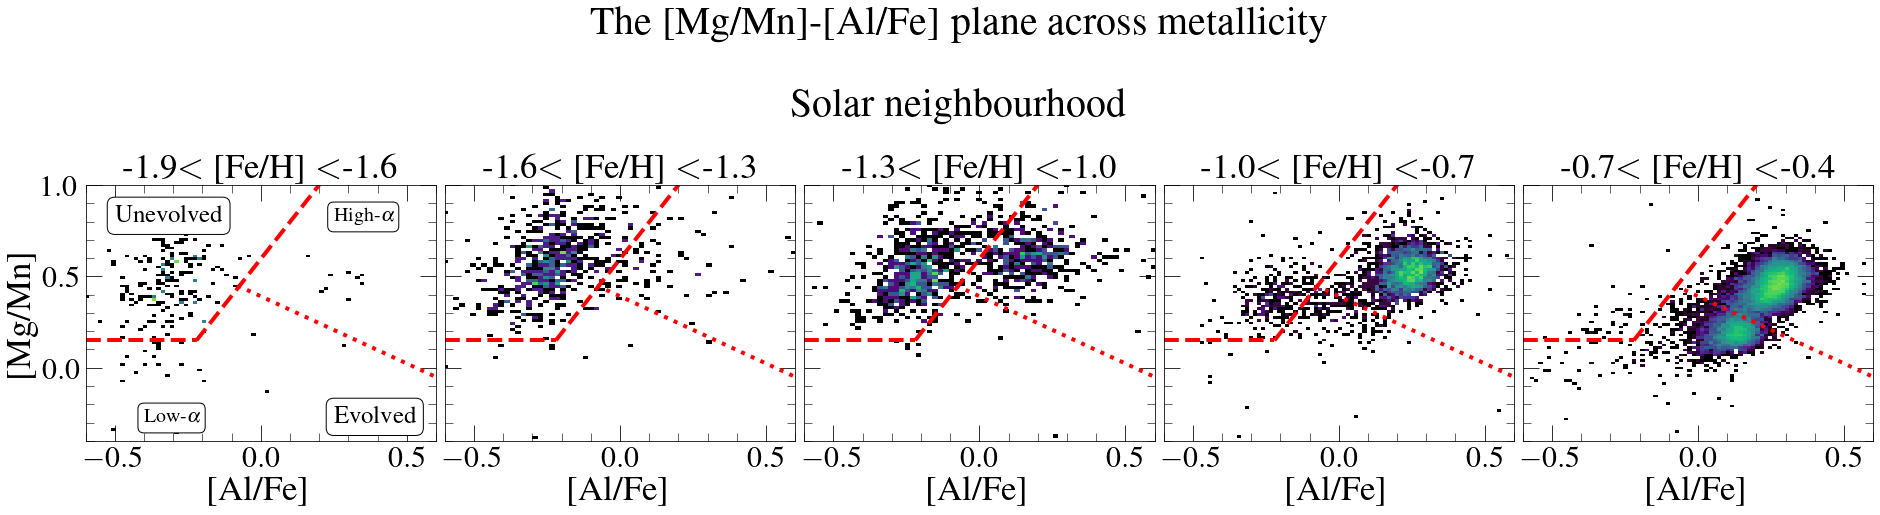

In [52]:
fig, all_axes = plt.subplots(1,5, constrained_layout=True, figsize=(26, 5), sharex=True, sharey=True,rasterized=True)
fehs_bins = np.linspace(-1.6,-0.4,5)

fig.suptitle('The [Mg/Mn]-[Al/Fe] plane across metallicity \n \n Solar neighbourhood',fontsize=40,x=0.51,y=1.4)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1]) & (Rgal>6) & (Rgal<10)
    all_axes[indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=35)    
    all_axes[indx].hist2d(data['AL_FE'][mask&m],mgmn[mask&m],bins=100,cmap=cm.lavender, norm=LogNorm())
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[indx].set_xlabel('[Al/Fe]',fontsize=35)
    all_axes[indx].set_xlim(-0.6,0.6)
    all_axes[indx].set_ylim(-0.4,1.)
    all_axes[indx].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[indx].minorticks_on()    
    all_axes[indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
all_axes[0].set_ylabel('[Mg/Mn]',fontsize=35)
props = dict(boxstyle='round', facecolor='white', alpha=1)
all_axes[0].text(-0.5,0.8,r'Unevolved',fontsize=25,bbox=props)
all_axes[0].text(0.25,-0.3,r'Evolved',fontsize=25,bbox=props)
all_axes[0].text(0.25,0.8,r'High-$\alpha$',fontsize=20,bbox=props)
all_axes[0].text(-0.4,-0.3,r'Low-$\alpha$',fontsize=20,bbox=props)

fig.savefig('../plots/magnamal-fehs-sn.pdf',dpi=150,bbox_inches='tight')


659
2033
1447
2876
3099
8312
7806
51424


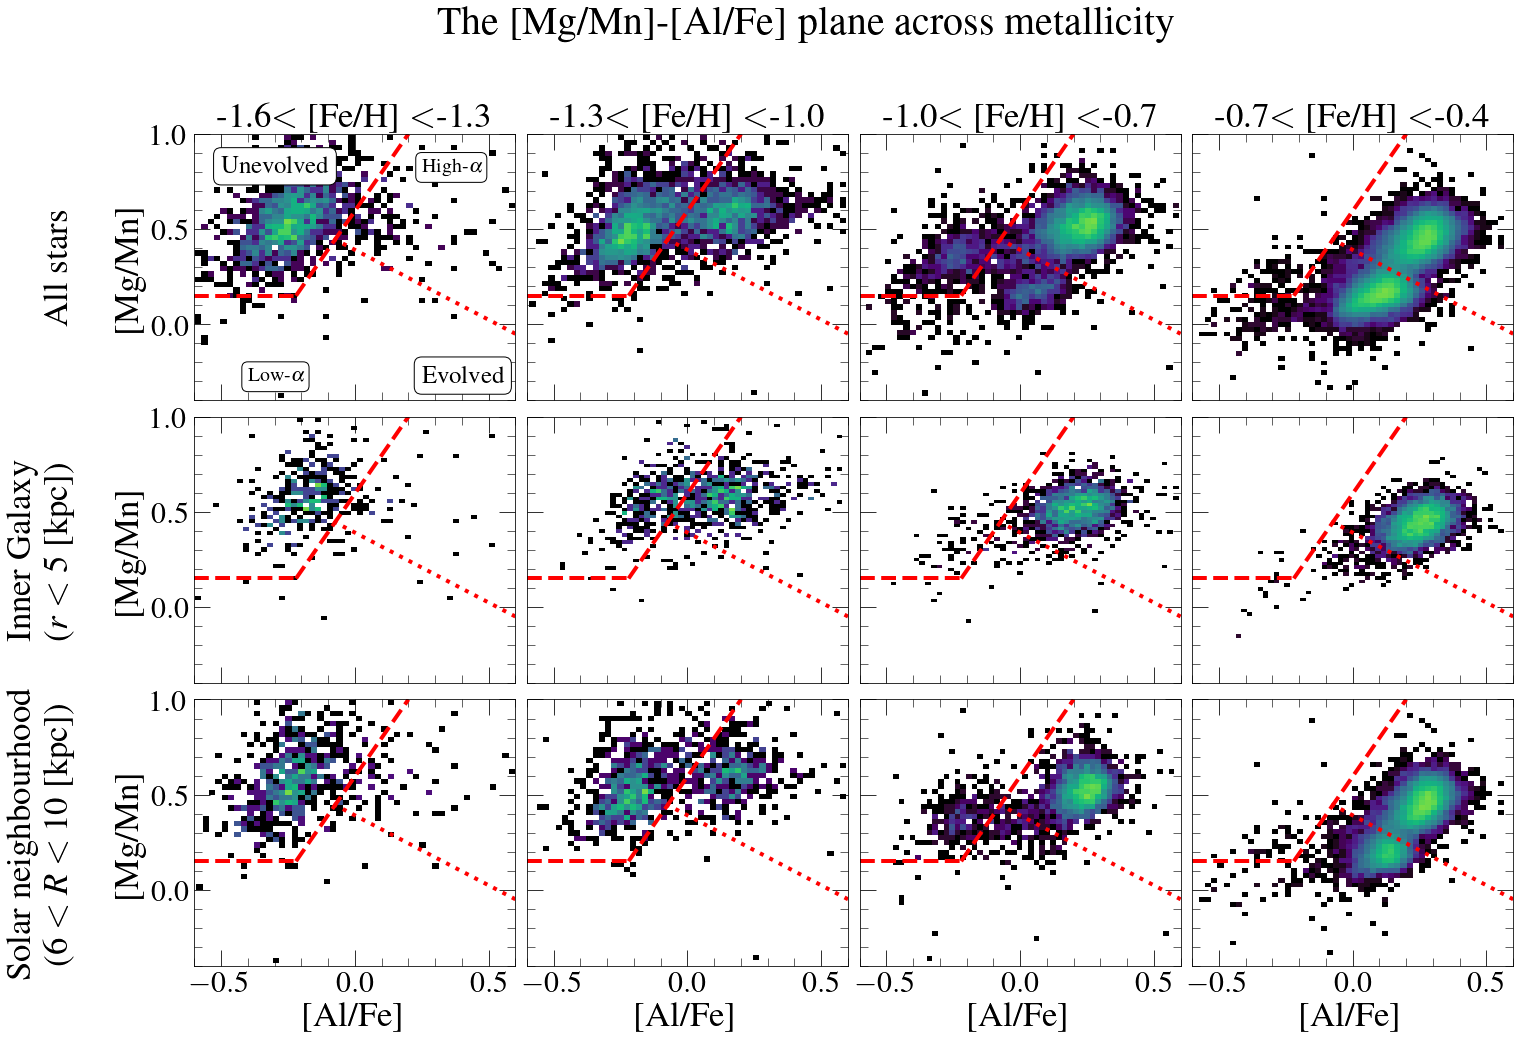

In [88]:
fig, all_axes = plt.subplots(3,4, constrained_layout=True, figsize=(21, 13), sharex=True, sharey=True,rasterized=True)
fehs_bins = np.linspace(-1.6,-0.4,5)

fig.suptitle('The [Mg/Mn]-[Al/Fe] plane across metallicity',fontsize=40,x=0.53,y=1.1)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])&(data['AL_FE']<0.6)&(data['AL_FE']>-0.6)&(mgmn<1)&(mgmn>-0.4)
    all_axes[0,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=35)    
    all_axes[0,indx].hist2d(data['AL_FE'][mask&m],mgmn[mask&m],bins=50,cmap=cm.lavender, norm=LogNorm())
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('[Al/Fe]',fontsize=35)
    all_axes[0,indx].set_xlim(-0.6,0.6)
    all_axes[0,indx].set_ylim(-0.4,1.)
    all_axes[0,indx].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx].minorticks_on()    
    all_axes[0,indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[0,indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[0,indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1]) & (rads<5)&(data['AL_FE']<0.6)&(data['AL_FE']>-0.6)&(mgmn<1)&(mgmn>-0.4)
    print(len(data[m]))
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=35)    
    all_axes[1,indx].hist2d(data['AL_FE'][mask&m],mgmn[mask&m],bins=50,cmap=cm.lavender, norm=LogNorm())
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[1,indx].set_xlabel('[Al/Fe]',fontsize=35)
    all_axes[1,indx].set_xlim(-0.6,0.6)
    all_axes[1,indx].set_ylim(-0.4,1.)
    all_axes[1,indx].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx].minorticks_on()    
    all_axes[1,indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[1,indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[1,indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1]) & (Rgal>6) & (Rgal<10)&(data['AL_FE']<0.6)&(data['AL_FE']>-0.6)&(mgmn<1)&(mgmn>-0.4)
#     all_axes[2,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=35)    
    print(len(data[m]))
    all_axes[2,indx].hist2d(data['AL_FE'][mask&m],mgmn[mask&m],bins=50,cmap=cm.lavender, norm=LogNorm())
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[2,indx].set_xlabel('[Al/Fe]',fontsize=35)
    all_axes[2,indx].set_xlim(-0.6,0.6)
    all_axes[2,indx].set_ylim(-0.4,1.)
    all_axes[2,indx].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[2,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[2,indx].minorticks_on()    
    all_axes[2,indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[2,indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[2,indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
all_axes[0,0].set_ylabel('All stars \n \n [Mg/Mn]',fontsize=35, labelpad=5)
all_axes[2,0].set_ylabel('Solar neighbourhood \n ($6< R < 10$ [kpc]) \n \n [Mg/Mn]',fontsize=35, labelpad=5)
all_axes[1,0].set_ylabel('Inner Galaxy \n ($r<5$ [kpc]) \n \n [Mg/Mn]',fontsize=35, labelpad=5)
props = dict(boxstyle='round', facecolor='white', alpha=1)
all_axes[0,0].text(-0.5,0.8,r'Unevolved',fontsize=25,bbox=props)
all_axes[0,0].text(0.25,-0.3,r'Evolved',fontsize=25,bbox=props)
all_axes[0,0].text(0.25,0.8,r'High-$\alpha$',fontsize=20,bbox=props)
all_axes[0,0].text(-0.4,-0.3,r'Low-$\alpha$',fontsize=20,bbox=props)

fig.savefig('../plots/magnamal-fehs-all-new.pdf',dpi=150,bbox_inches='tight')


In [112]:
m = (data['FE_H']<-1.3) & (rads<5)&mask&mask_higha
print(len(data[m&mask]))

m = (data['FE_H']<-1.3) & (Rgal>6) & (Rgal<10)&mask&mask_higha
print(len(data[m&mask]))

47
80


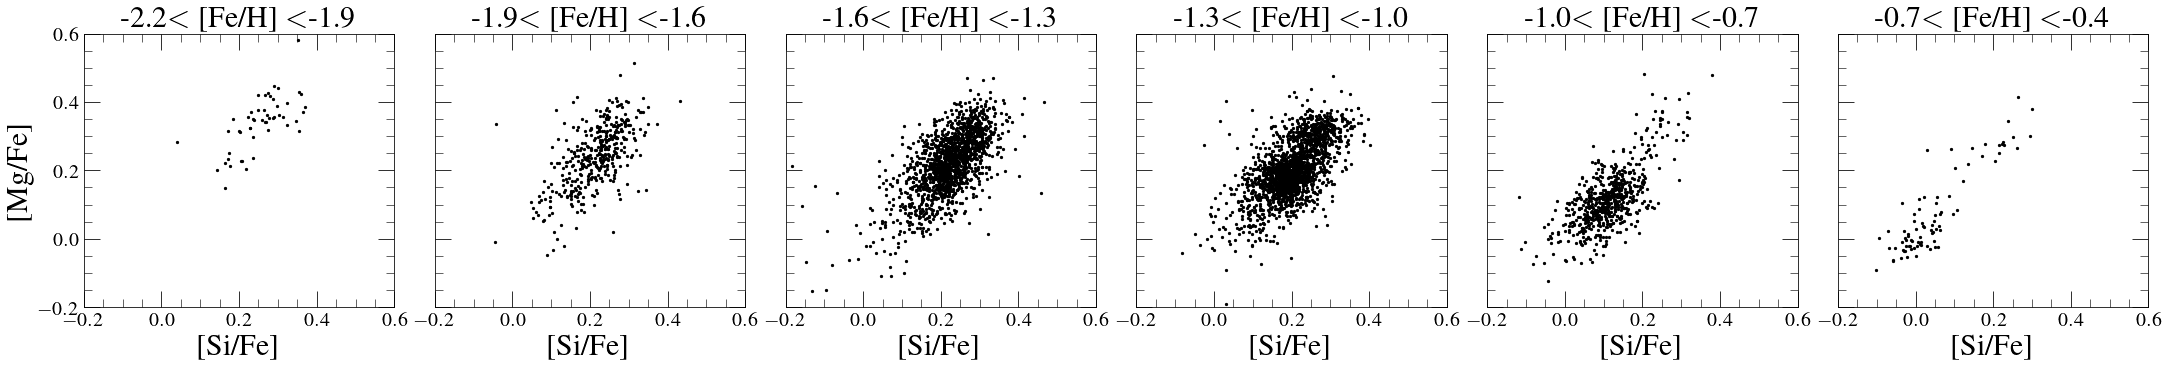

In [56]:
fig, all_axes = plt.subplots(1,6, constrained_layout=True, figsize=(30, 5), sharex=True, sharey=True,rasterized=True)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
#     all_axes[indx].scatter(data['SI_FE'][mask&m&~mask_une&(mgmn>0.25)],data['MG_FE'][mask&m&~mask_une&(mgmn>0.25)],s=1, c='k')
    all_axes[indx].scatter(data['SI_FE'][mask&m&mask_une],data['MG_FE'][mask&m&mask_une],s=5, c='k')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[indx].set_xlabel('[Si/Fe]',fontsize=30)
    all_axes[indx].set_xlim(-0.2,0.6)
    all_axes[indx].set_ylim(-0.2,0.6)
    all_axes[indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[indx].minorticks_on()    

    
all_axes[0].set_ylabel('[Mg/Fe]',fontsize=30)

fig.savefig('../plots/magnamal-fehs-scatter.pdf',dpi=150)


Text(0, 0.5, '[Mg/Mn]')

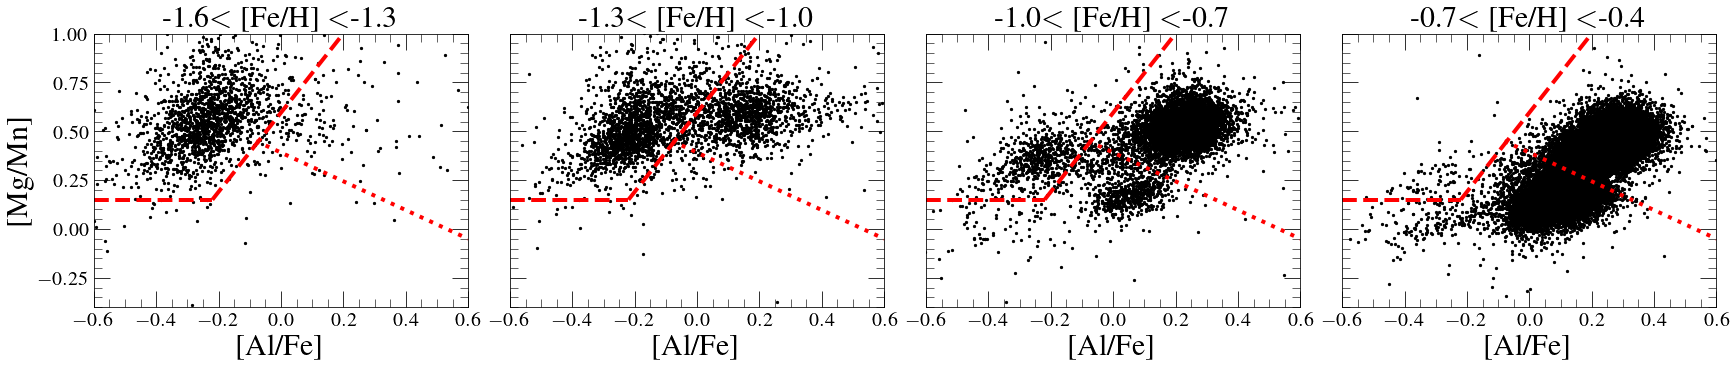

In [117]:
fig, all_axes = plt.subplots(1,4, constrained_layout=True, figsize=(24, 5), sharex=True, sharey=True,rasterized=True)
fehs_bins = np.linspace(-1.6,-0.4,5)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
#     all_axes[indx].scatter(data['SI_FE'][mask&m&~mask_une&(mgmn>0.25)],data['MG_FE'][mask&m&~mask_une&(mgmn>0.25)],s=1, c='k')
    all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=5, c='k')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[indx].set_xlabel('[Al/Fe]',fontsize=30)
    all_axes[indx].set_xlim(-0.6,0.6)
    all_axes[indx].set_ylim(-0.4,1)
    all_axes[indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[indx].minorticks_on()    
    all_axes[indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
all_axes[0].set_ylabel('[Mg/Mn]',fontsize=30)

# fig.savefig('../plots/magnamal-fehs-scatter.pdf',dpi=150)


In [73]:
X, Y, Z = data['X']*8.275, data['Y']*8.275, data['Z']*8.275 
vx, vy, vz = data['vx']*220., data['vy']*220., data['vz']*220. 


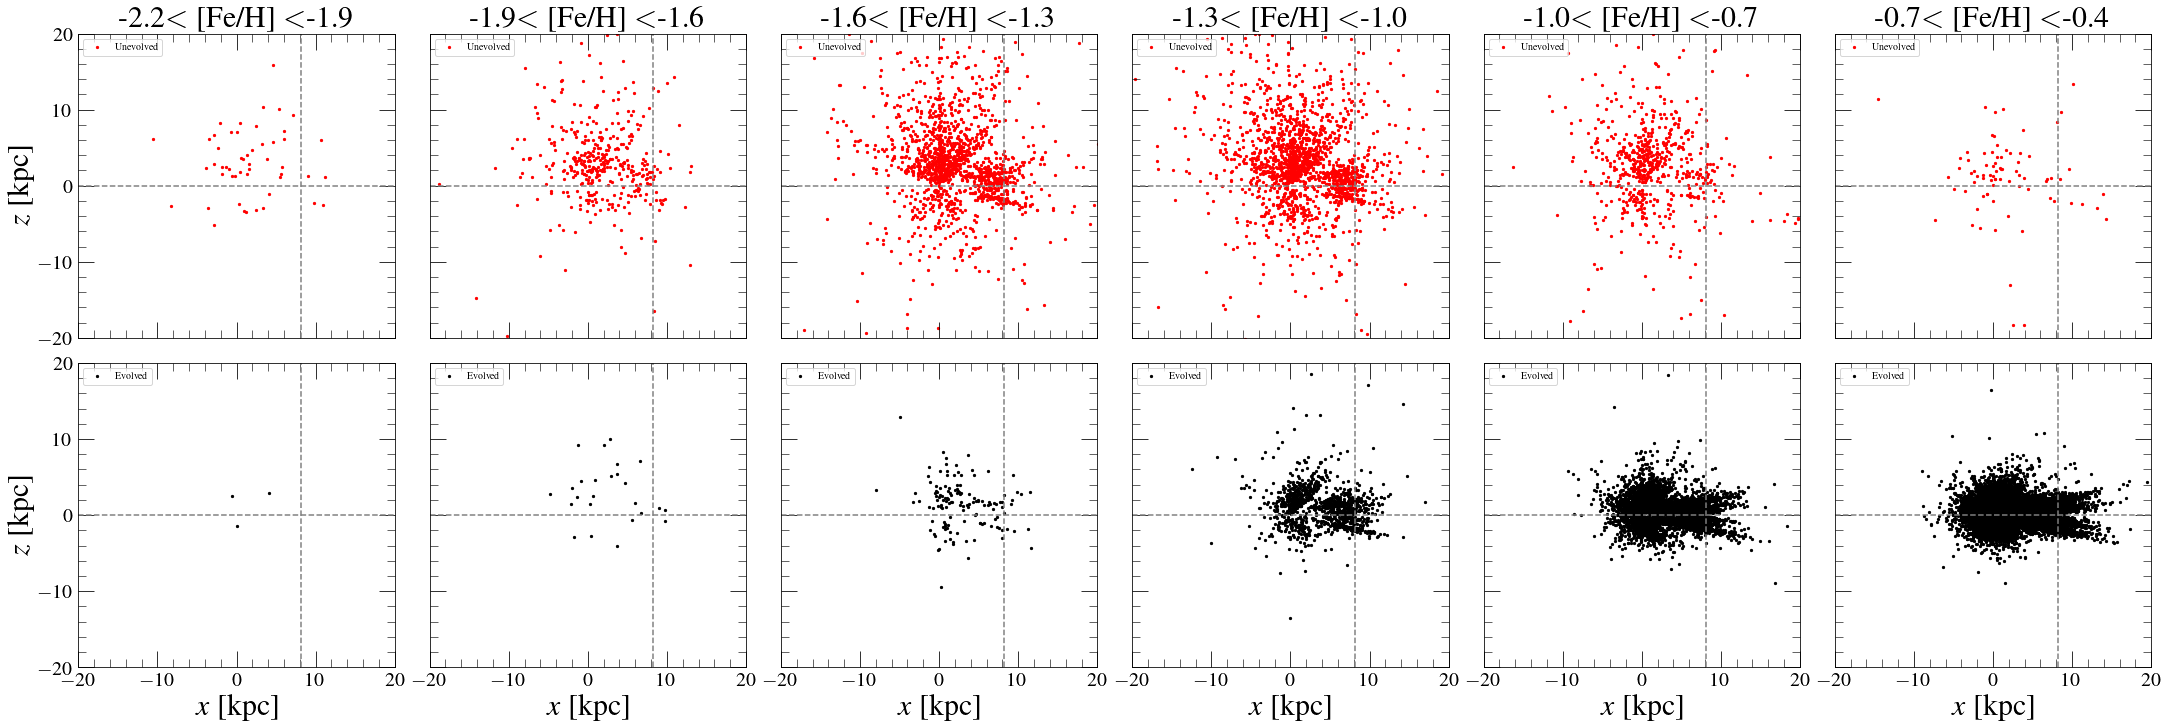

In [58]:
fig, all_axes = plt.subplots(2,6, constrained_layout=True, figsize=(30, 10), sharex=True, sharey=True,rasterized=True)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[0,indx].scatter(X[mask&m&mask_une],Z[mask&m&mask_une],s=5, c='r', label='Unevolved')
    all_axes[0,indx].legend(loc='upper left')
    all_axes[0,indx].set_xlim(-20,20)
    all_axes[0,indx].set_ylim(-20,20)
    all_axes[0,indx].hlines(0,-20,20, ls='--', color='gray')
    all_axes[0,indx].vlines(8.178,-20,20, ls='--', color='gray')
    all_axes[0,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx].minorticks_on()   
    
    all_axes[1,indx].scatter(X[mask&m&~mask_une&(mgmn>0.3)],Z[mask&m&~mask_une&(mgmn>0.3)],s=5, c='k', label='Evolved')
    all_axes[1,indx].legend(loc='upper left')
    all_axes[1,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[1,indx].set_xlim(-20,20)
    all_axes[1,indx].set_ylim(-20,20)
    all_axes[1,indx].hlines(0,-20,20, ls='--', color='gray')
    all_axes[1,indx].vlines(8.178,-20,20, ls='--', color='gray')
    all_axes[1,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx].minorticks_on()   
    
all_axes[0,0].set_ylabel('$z$ [kpc]',fontsize=30)
all_axes[1,0].set_ylabel('$z$ [kpc]',fontsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=1)

fig.savefig('../plots/magnamal-fehs-spatial-scatter.pdf',dpi=150)


python(8957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


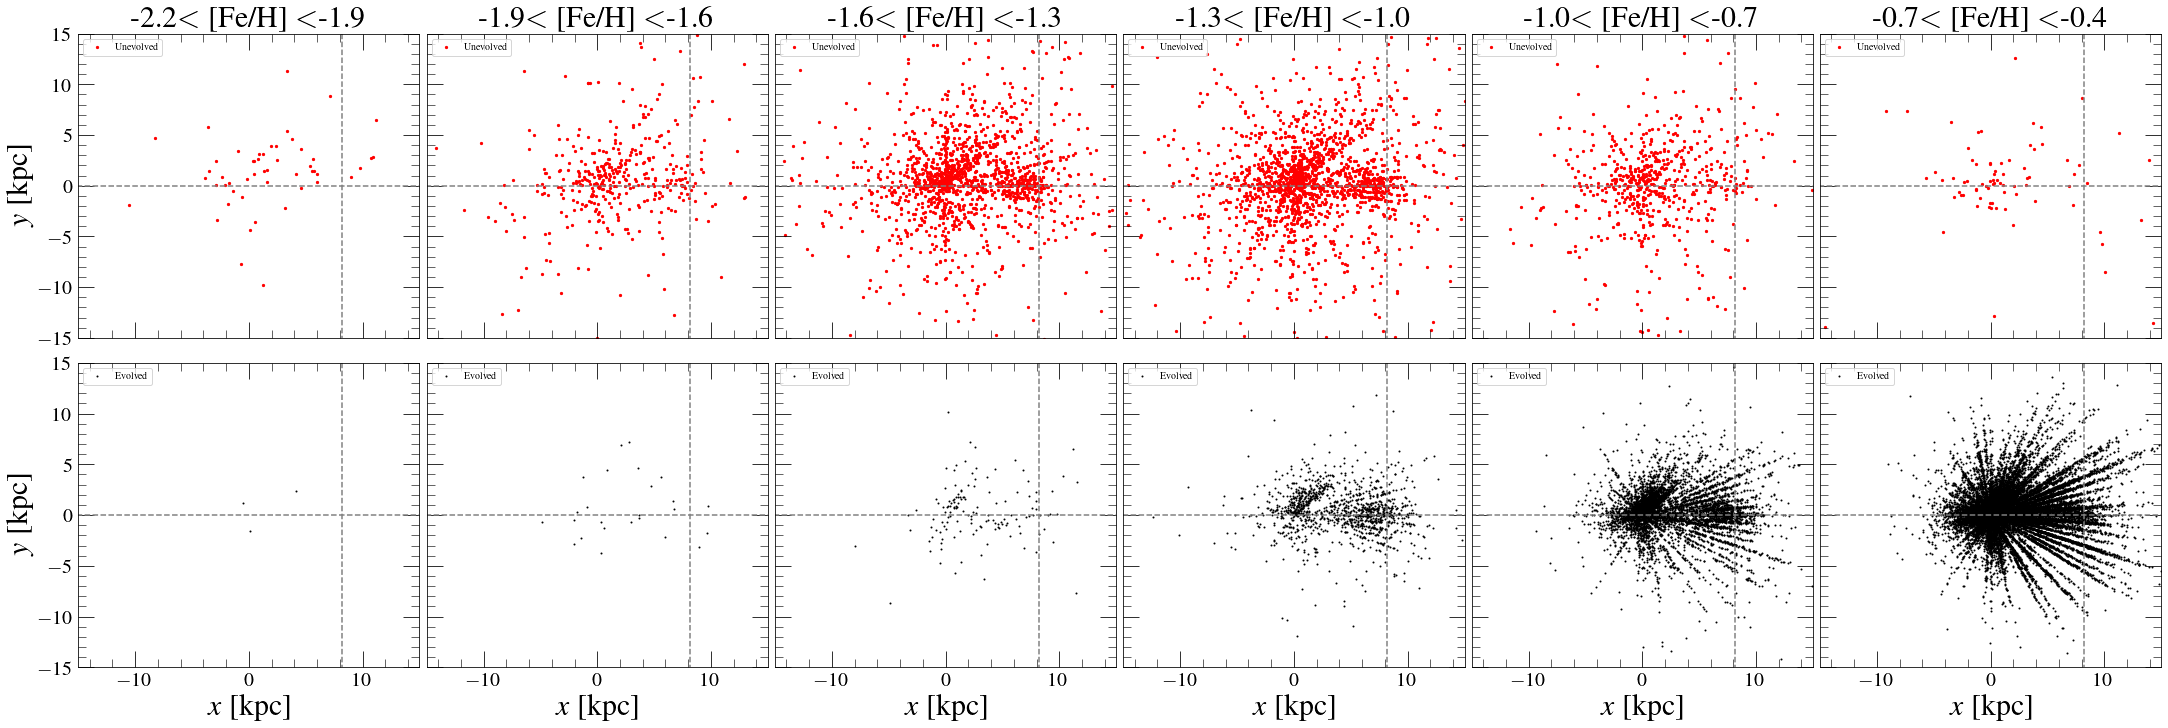

In [59]:
fig, all_axes = plt.subplots(2,6, constrained_layout=True, figsize=(30, 10), sharex=True, sharey=True,rasterized=True)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[0,indx].scatter(X[mask&m&mask_une],Y[mask&m&mask_une],s=5, c='r', label='Unevolved')
    all_axes[0,indx].legend(loc='upper left')
    all_axes[0,indx].set_xlim(-15,15)
    all_axes[0,indx].set_ylim(-15,15)
    all_axes[0,indx].hlines(0,-20,20, ls='--', color='gray')
    all_axes[0,indx].vlines(8.178,-20,20, ls='--', color='gray')
    all_axes[0,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx].minorticks_on()   
    
    all_axes[1,indx].scatter(X[mask&m&~mask_une&(mgmn>0.3)],Y[mask&m&~mask_une&(mgmn>0.3)],s=1, c='k', label='Evolved')
    all_axes[1,indx].legend(loc='upper left')
    all_axes[1,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[1,indx].set_xlim(-15,15)
    all_axes[1,indx].set_ylim(-15,15)
    all_axes[1,indx].hlines(0,-20,20, ls='--', color='gray')
    all_axes[1,indx].vlines(8.178,-20,20, ls='--', color='gray')
    all_axes[1,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx].minorticks_on()   
    
all_axes[0,0].set_ylabel('$y$ [kpc]',fontsize=30)
all_axes[1,0].set_ylabel('$y$ [kpc]',fontsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=1)

fig.savefig('../plots/magnamal-fehs-spatial-scatter-XY.pdf',dpi=150)


In [74]:
vxvz = np.sqrt(vx**2+vz**2)

python(8973) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8974) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8975) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8976) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8977) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8980) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8982) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8984) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


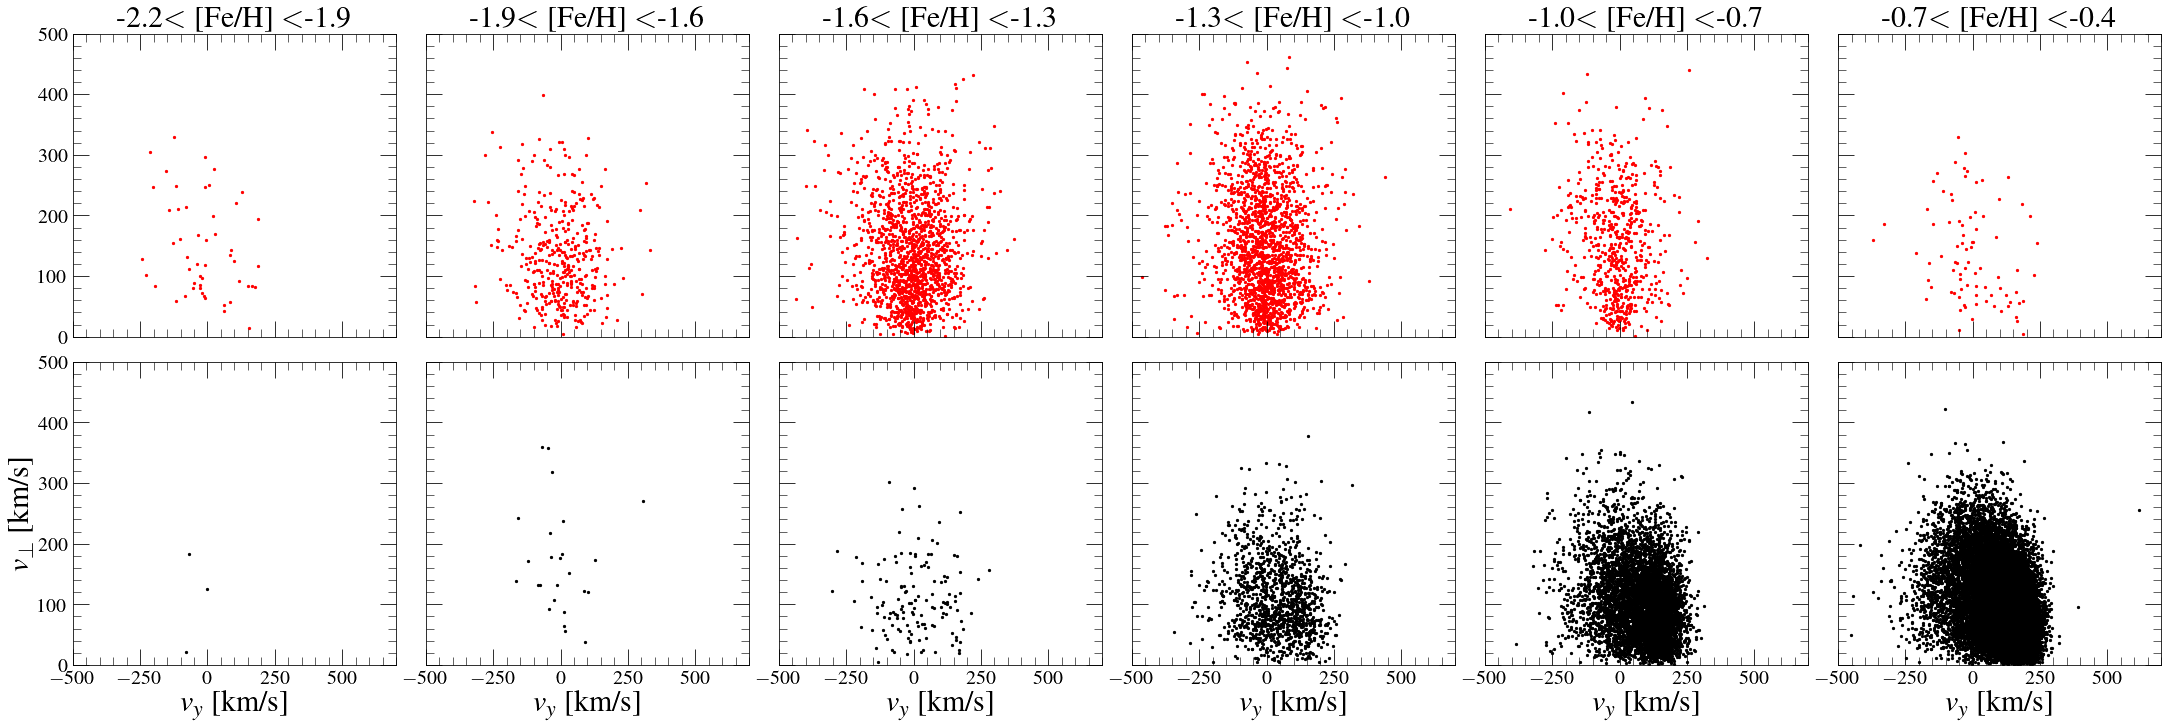

In [61]:
fig, all_axes = plt.subplots(2,6, constrained_layout=True, figsize=(30, 10), sharex=True, sharey=True,rasterized=True)
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[0,indx].scatter(vy[mask&m&mask_une]+220,vxvz[mask&m&mask_une],s=5, c='r')
    all_axes[0,indx].set_xlim(-500,700)
    all_axes[0,indx].set_ylim(0,500)
    all_axes[0,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx].minorticks_on()   
    
    all_axes[1,indx].scatter(vy[mask&m&~mask_une&(mgmn>0.3)]+220,vxvz[mask&m&~mask_une&(mgmn>0.3)],s=5, c='k')
    all_axes[1,indx].set_xlabel('$v_{y}$ [km/s]',fontsize=30)
    all_axes[1,indx].set_xlim(-500,700)
    all_axes[1,indx].set_ylim(0,500)
    all_axes[1,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx].minorticks_on()   
    
all_axes[1,0].set_ylabel('$v_{\perp}$ [km/s]',fontsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=1)

fig.savefig('../plots/magnamal-fehs-Toomre.pdf',dpi=150)


In [75]:
Lz = Rgal * vphi
Lx = (Y*vz)-(Z*vy)
Ly = (Z*vx)-(X*vz)

python(9003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


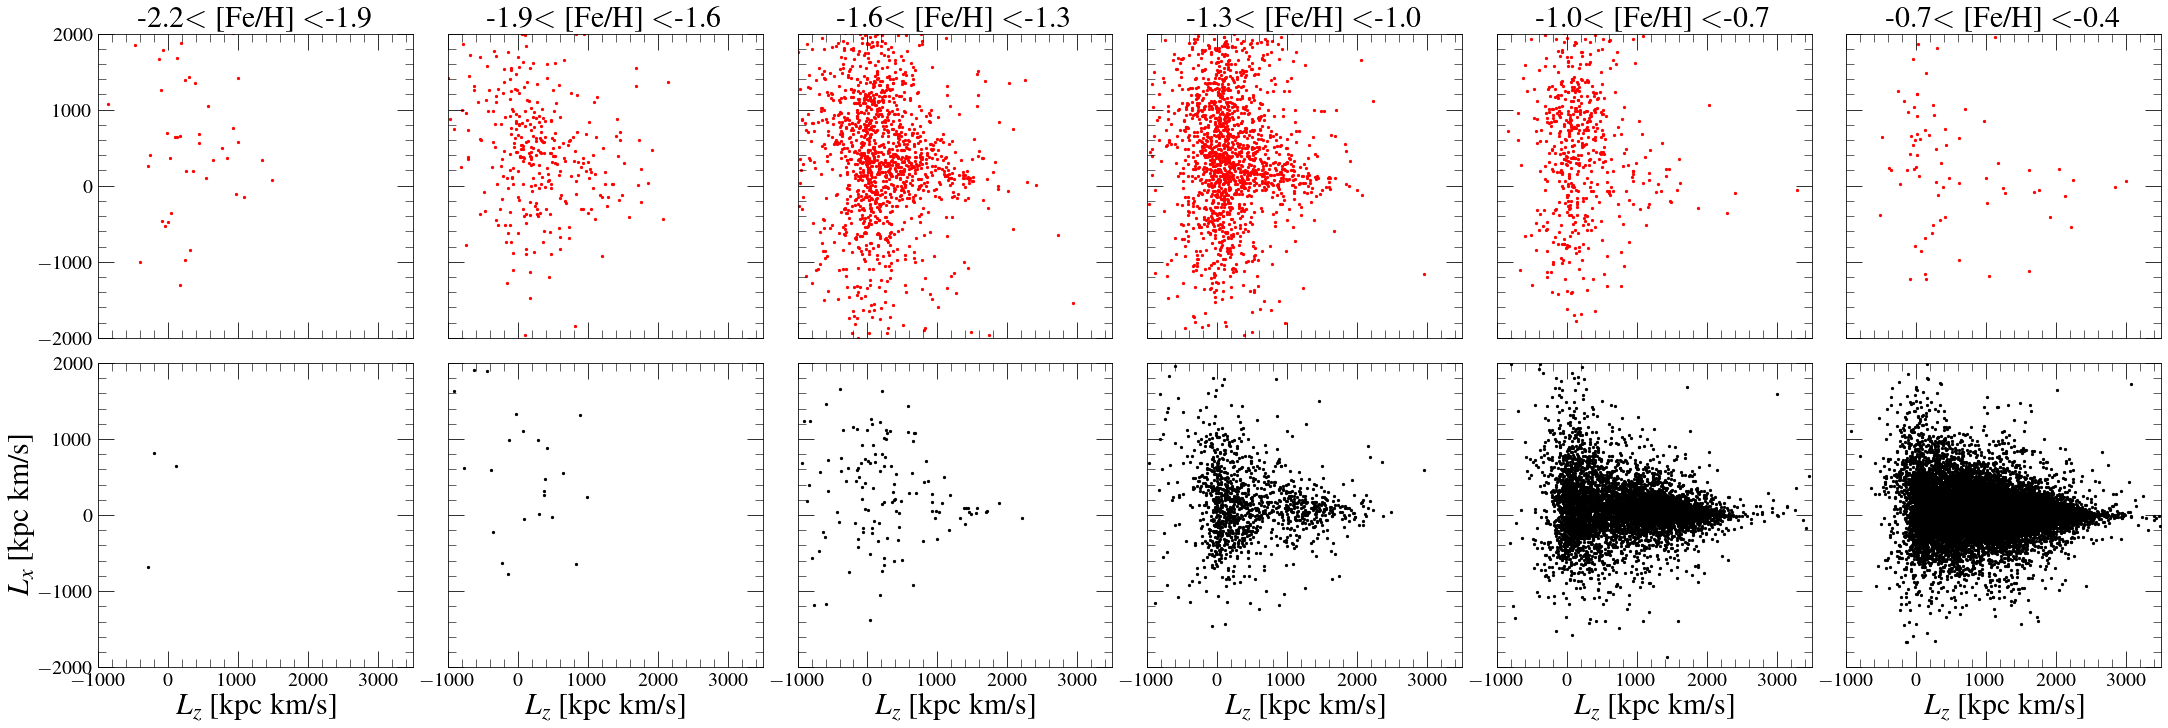

In [63]:
fig, all_axes = plt.subplots(2,6, constrained_layout=True, figsize=(30, 10), sharex=True, sharey=True,rasterized=True)
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[0,indx].scatter(Lz[mask&m&mask_une],Lx[mask&m&mask_une],s=5, c='r')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx].set_xlim(-1000,3500)
    all_axes[0,indx].set_ylim(-2e3,2e3)
    all_axes[0,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[1,indx].scatter(Lz[mask&m&~mask_une&(mgmn>0.3)],Lx[mask&m&~mask_une&(mgmn>0.3)],s=5, c='k')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[1,indx].set_xlabel('$L_{z}$ [kpc km/s]',fontsize=30)
    all_axes[1,indx].set_xlim(-1000,3500)
    all_axes[1,indx].set_ylim(-2e3,2e3)
    all_axes[1,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx].minorticks_on()   
    
all_axes[1,0].set_ylabel('$L_{x}$ [kpc km/s]',fontsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=1)

fig.savefig('../plots/magnamal-fehs-LxLy.pdf',dpi=150)


python(9036) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


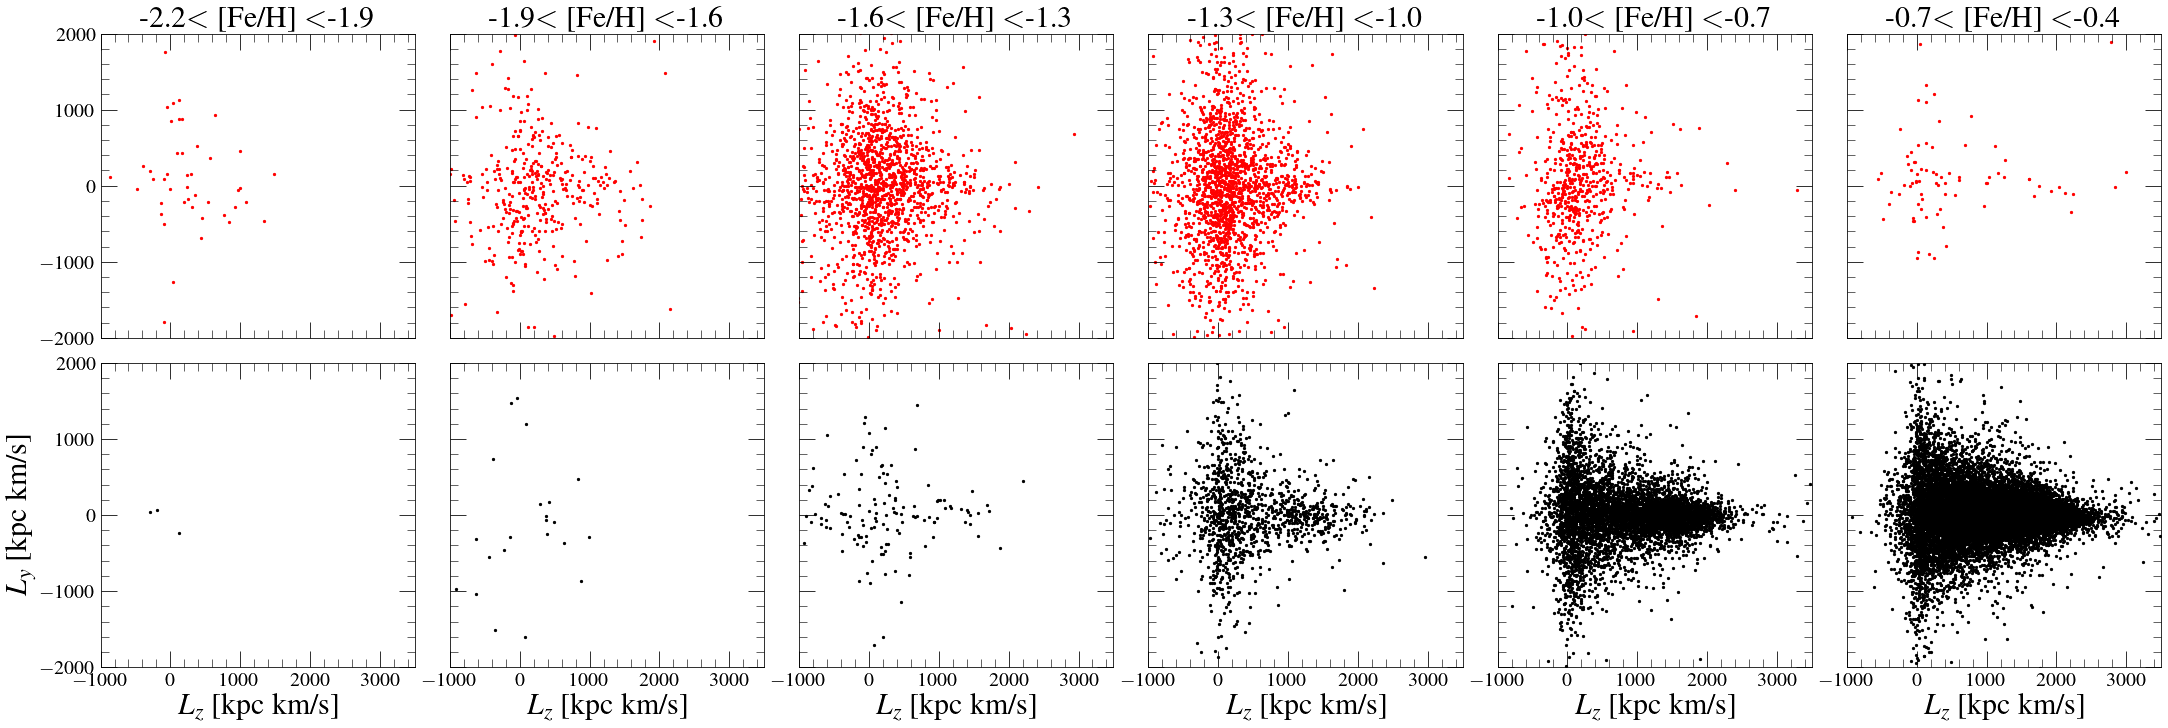

In [64]:
fig, all_axes = plt.subplots(2,6, constrained_layout=True, figsize=(30, 10), sharex=True, sharey=True,rasterized=True)
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[0,indx].scatter(Lz[mask&m&mask_une],Ly[mask&m&mask_une],s=5, c='r')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx].set_xlim(-1000,3500)
    all_axes[0,indx].set_ylim(-2e3,2e3)
    all_axes[0,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[1,indx].scatter(Lz[mask&m&~mask_une&(mgmn>0.3)],Ly[mask&m&~mask_une&(mgmn>0.3)],s=5, c='k')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[1,indx].set_xlabel('$L_{z}$ [kpc km/s]',fontsize=30)
    all_axes[1,indx].set_xlim(-1000,3500)
    all_axes[1,indx].set_ylim(-2e3,2e3)
    all_axes[1,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx].minorticks_on()   
    
all_axes[1,0].set_ylabel('$L_{y}$ [kpc km/s]',fontsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=1)

fig.savefig('../plots/magnamal-fehs-LyLz.pdf',dpi=150)


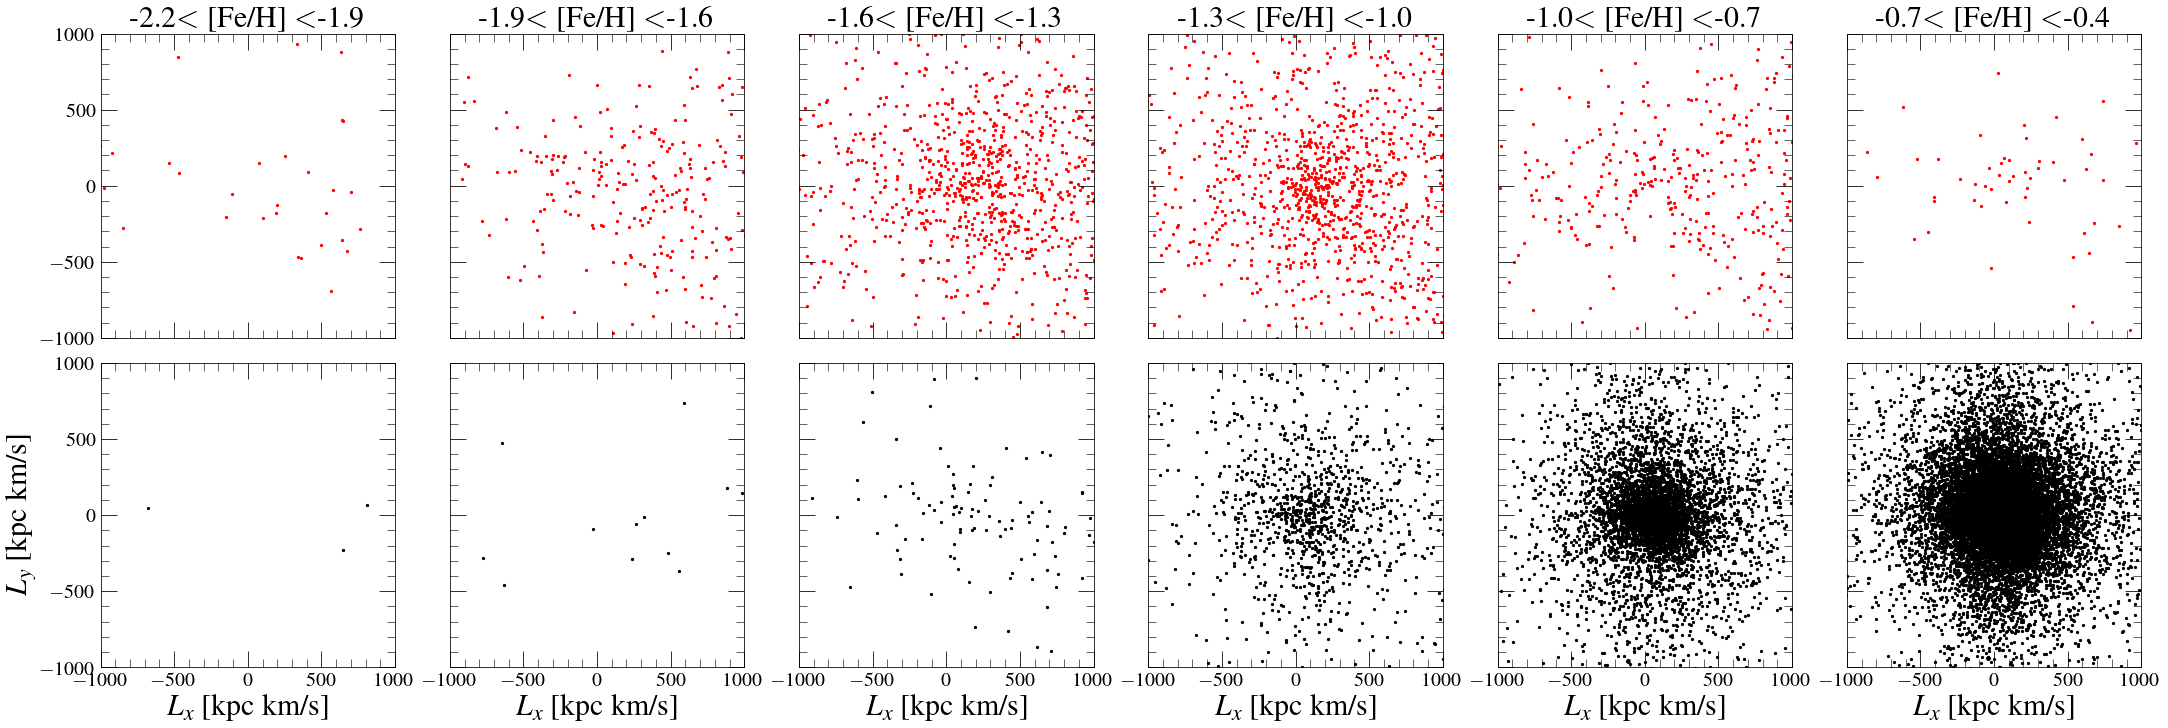

In [65]:
fig, all_axes = plt.subplots(2,6, constrained_layout=True, figsize=(30, 10), sharex=True, sharey=True,rasterized=True)
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[0,indx].scatter(Lx[mask&m&mask_une],Ly[mask&m&mask_une],s=5, c='r')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx].set_xlim(-1e3,1e3)
    all_axes[0,indx].set_ylim(-1e3,1e3)
    all_axes[0,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[1,indx].scatter(Lx[mask&m&~mask_une&(mgmn>0.3)],Ly[mask&m&~mask_une&(mgmn>0.3)],s=5, c='k')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[1,indx].set_xlabel('$L_{x}$ [kpc km/s]',fontsize=30)
    all_axes[1,indx].set_xlim(-1e3,1e3)
    all_axes[1,indx].set_ylim(-1e3,1e3)
    all_axes[1,indx].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx].minorticks_on()   
    
all_axes[1,0].set_ylabel('$L_{y}$ [kpc km/s]',fontsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=1)

fig.savefig('../plots/magnamal-fehs-LxLy.pdf',dpi=150)


NameError: name 'fehs_bins' is not defined

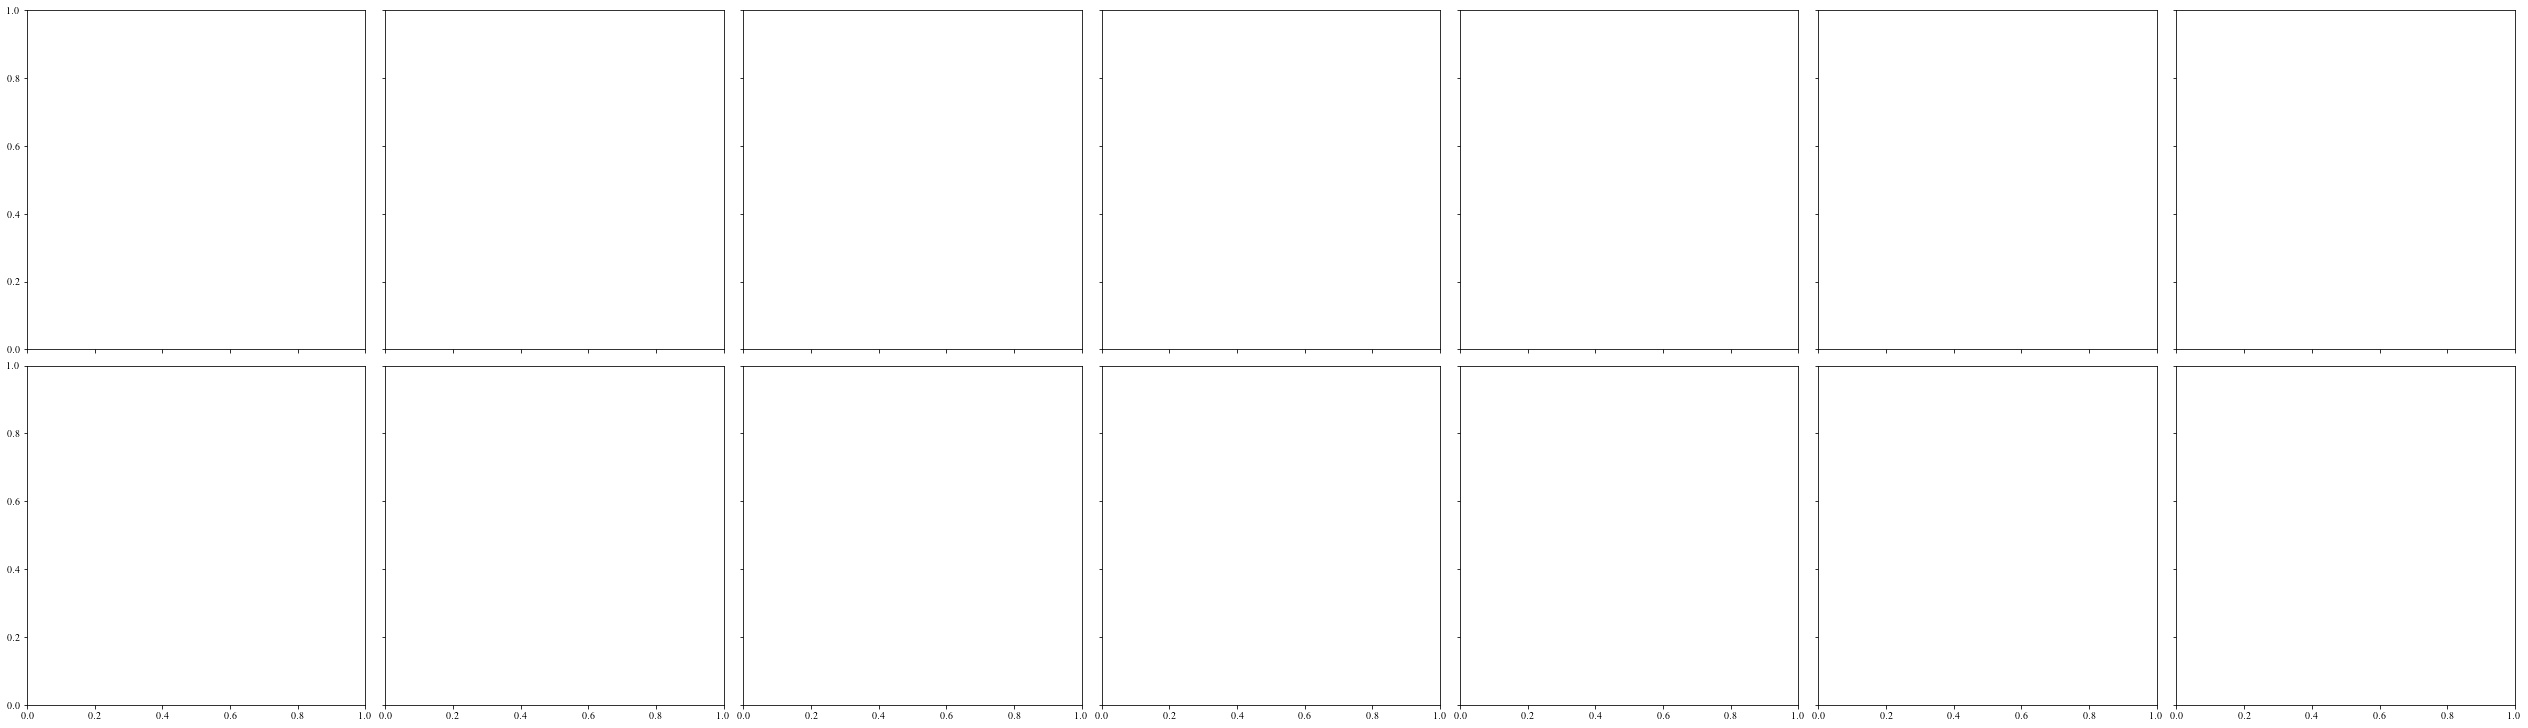

In [37]:
fig, all_axes = plt.subplots(2,7, constrained_layout=True, figsize=(35, 10), sharex=True, sharey=True,rasterized=True, facecolor='white')
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx+1].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    color = all_axes[0,indx+1].scatter(ecc[mask&m&mask_une&(rapo>0)&(rapo<100)],rapo[mask&m&mask_une&(rapo>0)&(rapo<100)],s=10, c=data['AL_FE'][mask&m&mask_une&(rapo>0)&(rapo<100)], vmin=-0.5,vmax=0.5, cmap=cm.voltage)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx+1].set_xlim(0,1)
    all_axes[0,indx+1].set_ylim(0,30)
    all_axes[0,indx+1].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx+1].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[1,indx+1].scatter(ecc[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],rapo[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],s=10, c=data['AL_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn>0.3)], vmin=-0.5,vmax=0.5, cmap=cm.voltage)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[1,indx+1].set_xlabel('$e$',fontsize=30)
    all_axes[1,indx+1].set_xlim(0,1)
    all_axes[1,indx+1].set_ylim(0,30)
    all_axes[1,indx+1].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx+1].minorticks_on()   
    
    
cbar_ax = fig.add_axes([1.01, 0.13, 0.02,0.77])
cb = plt.colorbar(color, cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'[Al/Fe]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

all_axes[1,0].text(0.75,3,'Bar', fontsize=24)
all_axes[1,0].text(0.7,10,'Splash', fontsize=24)
all_axes[1,0].text(0.1,8,r'High-$\alpha$ disc/', fontsize=24)
all_axes[1,0].text(0.1,5,r'in-situ halo', fontsize=24)

all_axes[0,0].text(0.8,15,'GES', fontsize=24)
all_axes[0,0].text(0.6,3,'Heracles', fontsize=24)
all_axes[0,0].text(0.6,9,'Aurora', fontsize=24)
all_axes[0,0].text(0.3,6,'Proto-MW', fontsize=24)
all_axes[0,0].set_title('Cartoon', fontsize=30)

all_axes[1,0].set_xlabel('Eccentricity, $e$', fontsize=30)
all_axes[0,0].set_xlim(0,1)
all_axes[0,0].set_ylim(0,30)
all_axes[0,0].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
all_axes[0,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[0,0].minorticks_on()   
all_axes[1,0].set_xlim(0,1)
all_axes[1,0].set_ylim(0,30)
all_axes[1,0].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
all_axes[1,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[1,0].minorticks_on()   

all_axes[0,0].text(0.1,25,'Unevovled', fontsize=24)
all_axes[1,0].text(0.1,25,'Evolved ([Mg/Mn] $>0.3$)', fontsize=24)
all_axes[0,0].set_ylabel('$R_{\mathrm{apo}}$ [kpc]',fontsize=30)
all_axes[1,0].set_ylabel('$R_{\mathrm{apo}}$ [kpc]',fontsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=1)

# fig.savefig('../plots/feh-bins-unevolved-evolved-rapo-ecc-alfe.pdf',dpi=150)


In [ ]:
fig, all_axes = plt.subplots(3,7, constrained_layout=True, figsize=(35, 15), sharex=True, sharey=True,rasterized=True, facecolor='white')
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx+1].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    color = all_axes[0,indx+1].scatter(ecc[mask&m&mask_une&(rapo>0)&(rapo<100)],rapo[mask&m&mask_une&(rapo>0)&(rapo<100)],s=20, c=data['MG_FE'][mask&m&mask_une&(rapo>0)&(rapo<100)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx+1].set_xlim(0,1)
    all_axes[0,indx+1].set_ylim(0,30)
    all_axes[0,indx+1].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx+1].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[1,indx+1].scatter(ecc[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],rapo[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],s=20, c=data['MG_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn>0.3)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[1,indx+1].set_xlabel('$e$',fontsize=30)
    all_axes[1,indx+1].set_xlim(0,1)
    all_axes[1,indx+1].set_ylim(0,30)
    all_axes[1,indx+1].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx+1].minorticks_on() 
    
    #     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[2,indx+1].scatter(ecc[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)&(data['AL_FE']>-0.15)],rapo[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)&(data['AL_FE']>-0.15)],s=20, c=data['MG_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn<0.3)&(data['AL_FE']>-0.15)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[2,indx+1].set_xlabel('Eccentricity, $e$',fontsize=30)
    all_axes[2,indx+1].set_xlim(0,1)
    all_axes[2,indx+1].set_ylim(0,30)
    all_axes[2,indx+1].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[2,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[2,indx+1].minorticks_on() 
    
    
cbar_ax = fig.add_axes([1.01, 0.13, 0.02,0.77])
cb = plt.colorbar(color, cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'[Mg/Fe]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

all_axes[1,0].text(0.5,3,'Bar', fontsize=24)
all_axes[1,0].text(0.6,10,'Splash', fontsize=24)
all_axes[1,0].text(0.1,8,r'High-$\alpha$ disc/', fontsize=24)
all_axes[1,0].text(0.15,5,r'Aurora', fontsize=24)

all_axes[0,0].text(0.8,15,'GES', fontsize=24)
all_axes[0,0].text(0.3,5,'Heracles/Proto-MW', fontsize=24)
all_axes[0,0].set_title('Cartoon', fontsize=30)

all_axes[2,0].text(0.1,12,r'Low-$\alpha$ disc', fontsize=24)
all_axes[2,0].text(0.5,3,'Bar', fontsize=24)
all_axes[2,0].text(0.6,10,'Splash', fontsize=24)


# all_axes[2,0].text(0.8,15,'GES', fontsize=24)
# all_axes[2,0].text(0.3,5,'Heracles/Proto-MW', fontsize=24)
# all_axes[2,0].set_title('Cartoon', fontsize=30)

all_axes[0,0].set_xlim(0,1)
all_axes[0,0].set_ylim(0,30)
all_axes[0,0].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
all_axes[0,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[0,0].minorticks_on()   
all_axes[1,0].set_xlim(0,1)
all_axes[1,0].set_ylim(0,30)
all_axes[1,0].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
all_axes[1,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[1,0].minorticks_on()   

all_axes[2,0].set_xlim(0,1)
all_axes[2,0].set_ylim(0,30)
all_axes[2,0].tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
all_axes[2,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[2,0].minorticks_on()   

all_axes[0,0].text(0.1,25,'Unevovled ([Al/Fe] $< 0$)', fontsize=24, color='firebrick')
all_axes[1,0].text(0.1,25,r'Evolved (high-$\alpha$)', fontsize=24, color='firebrick')
all_axes[1,0].text(0.05,22,'([Mg/Mn] $>0.3$; [Al/Fe] $> 0$)', fontsize=24, color='firebrick')
all_axes[2,0].text(0.1,25,r'Evolved (low-$\alpha$)', fontsize=24, color='firebrick')
all_axes[2,0].text(0.1,22,'([Mg/Mn] $<0.3$;', fontsize=24, color='firebrick')
all_axes[2,0].text(0.1,19,'[Al/Fe] $> -0.15$)', fontsize=24, color='firebrick')
all_axes[0,0].set_ylabel('$R_{\mathrm{apo}}$ [kpc]',fontsize=30)
all_axes[1,0].set_ylabel('$R_{\mathrm{apo}}$ [kpc]',fontsize=30)
all_axes[2,0].set_ylabel('$R_{\mathrm{apo}}$ [kpc]',fontsize=30)
props = dict(boxstyle='round', facecolor='white', alpha=1)

# fig.savefig('../plots/feh-bins-unevolved-evolved-rapo-ecc-mgfe.pdf',dpi=150)


In [90]:
vR = data['vR']*220.
vphi = data['vT']*220.

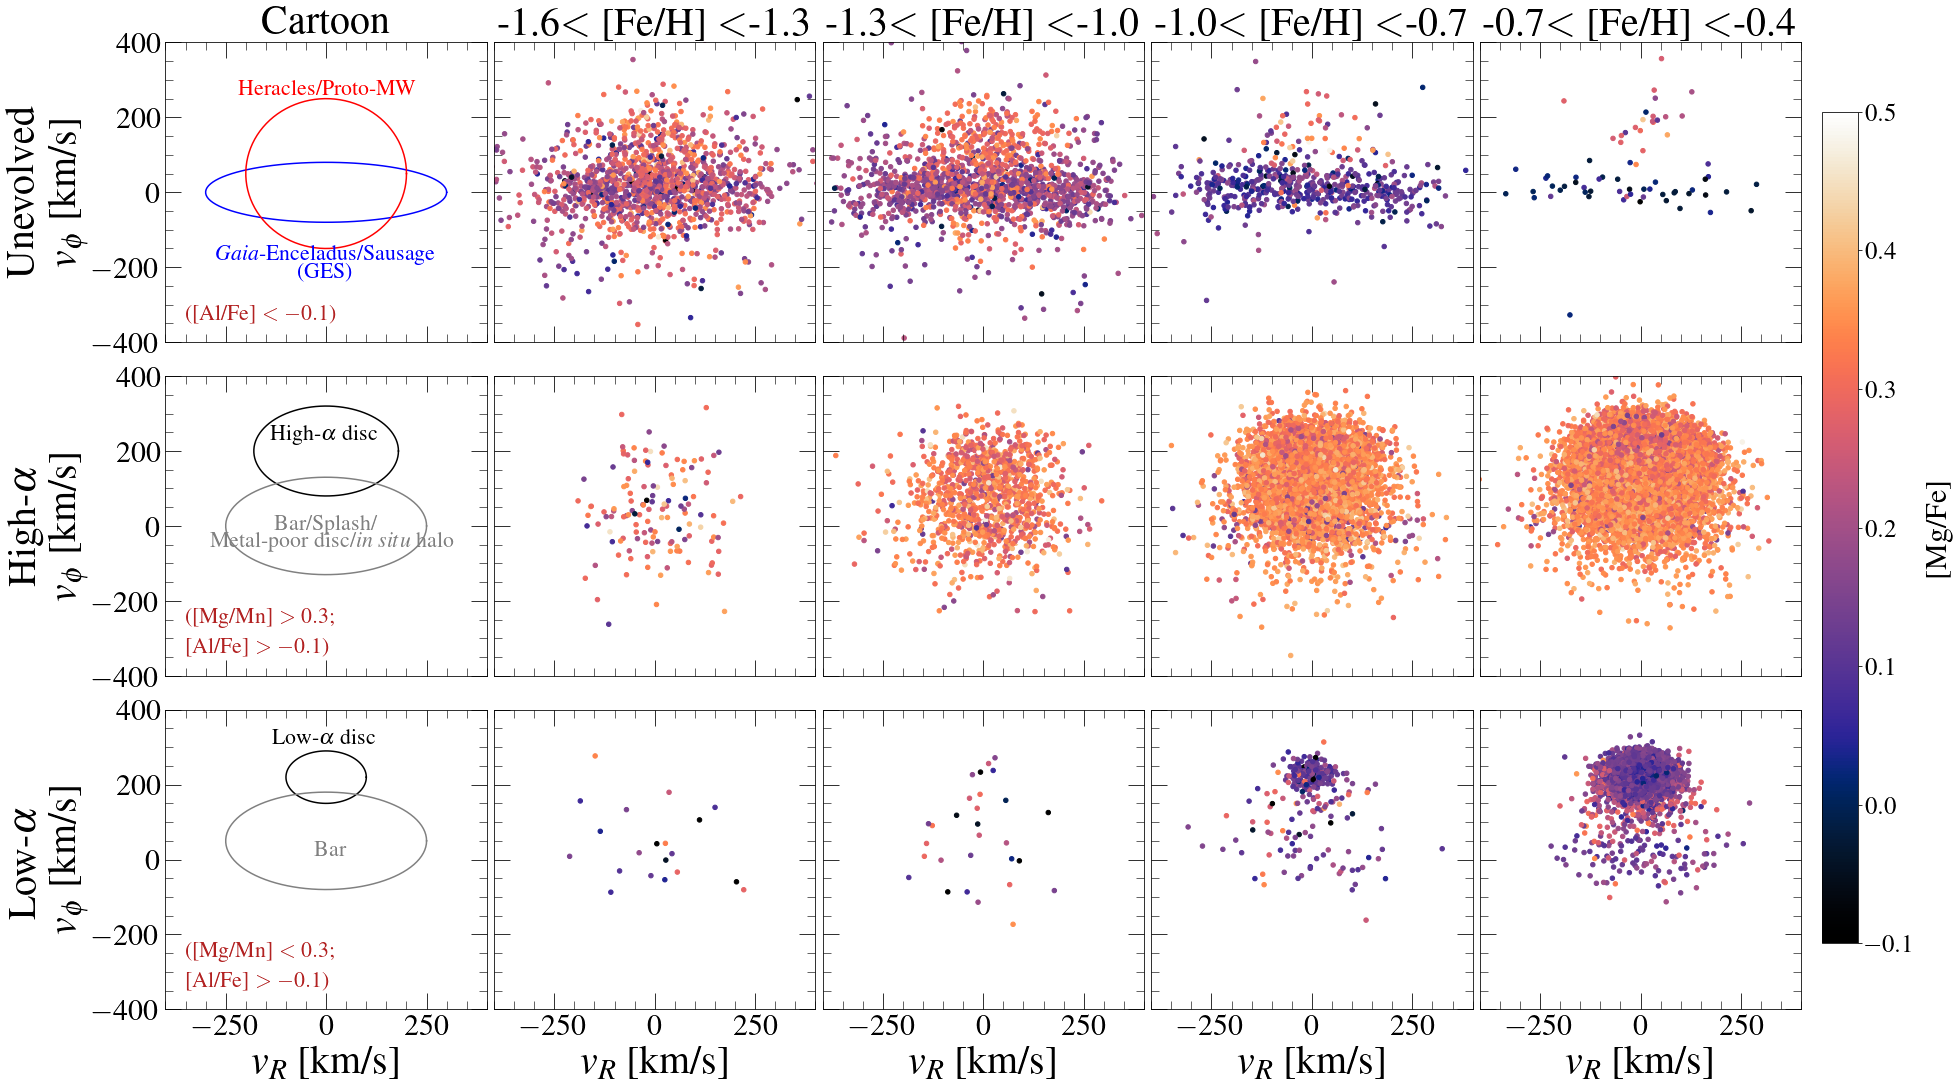

In [95]:
fig, all_axes = plt.subplots(3,5, constrained_layout=True, figsize=(25, 15), sharex=True, sharey=True,rasterized=True, facecolor='white')
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx+1].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=40)    
    color = all_axes[0,indx+1].scatter(vR[mask&m&mask_une&(rapo>0)&(rapo<100)],vphi[mask&m&mask_une&(rapo>0)&(rapo<100)],s=20, c=data['MG_FE'][mask&m&mask_une&(rapo>0)&(rapo<100)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx+1].set_xlim(-400,400)
    all_axes[0,indx+1].set_ylim(-400,400)
    all_axes[0,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx+1].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[1,indx+1].scatter(vR[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],vphi[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],s=20, c=data['MG_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn>0.3)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[1,indx+1].set_xlabel('$e$',fontsize=30)
    all_axes[1,indx+1].set_xlim(-400,400)
    all_axes[1,indx+1].set_ylim(-400,400)
    all_axes[1,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx+1].minorticks_on() 
    
    #     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[2,indx+1].scatter(vR[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)&(data['AL_FE']>-0.1)],vphi[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)&(data['AL_FE']>-0.1)],s=20, c=data['MG_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn<0.3)&(data['AL_FE']>-0.1)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[2,indx+1].set_xlabel('$v_{R}$ [km/s]',fontsize=40)
    all_axes[2,indx+1].set_xlim(-400,400)
    all_axes[2,indx+1].set_ylim(-400,400)
    all_axes[2,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[2,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[2,indx+1].minorticks_on() 
    
    
cbar_ax = fig.add_axes([1.01, 0.13, 0.02,0.77])
cb = plt.colorbar(color, cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'[Mg/Fe]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

# all_axes[1,0].text(0.5,3,'Bar', fontsize=24)
# all_axes[1,0].text(0.6,10,'Splash', fontsize=24)
# all_axes[1,0].text(0.1,8,r'High-$\alpha$ disc/', fontsize=24)
# all_axes[1,0].text(0.15,5,r'Aurora', fontsize=24)

# all_axes[0,0].text(0.8,15,'GES', fontsize=24)
# all_axes[0,0].text(0.3,5,'Heracles/Proto-MW', fontsize=24)
# all_axes[0,0].set_title('Cartoon', fontsize=30)

# all_axes[2,0].text(0.1,12,r'Low-$\alpha$ disc', fontsize=24)
# all_axes[2,0].text(0.5,3,'Bar', fontsize=24)
# all_axes[2,0].text(0.6,10,'Splash', fontsize=24)


# u=1.     #x-position of the center
# v=0.5    #y-position of the center
# a=2.     #radius on the x-axis
# b=1.5    #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)
all_axes[0,0].plot( 0+300*np.cos(t) , 0+80*np.sin(t), color='b')
all_axes[0,0].plot( 0+200*np.cos(t) , 50+200*np.sin(t), color='r')


all_axes[0,0].text(-275.,-180,'$Gaia$-Enceladus/Sausage', fontsize=22, color='b')
all_axes[0,0].text(-70.,-230,'(GES)', fontsize=22, color='b')
all_axes[0,0].text(-220.,260,'Heracles/Proto-MW', fontsize=22, color='r')
all_axes[0,0].set_title('Cartoon', fontsize=40)

all_axes[1,0].plot( 0+180*np.cos(t) , 200+120*np.sin(t), color='k')
all_axes[1,0].text(-140.,230,r'High-$\alpha$ disc', fontsize=22, color='k')

all_axes[1,0].plot( 0+250*np.cos(t) , 0+130*np.sin(t), color='gray')
all_axes[1,0].text(-130.,-10,r'Bar/Splash/', fontsize=22, color='gray')
all_axes[1,0].text(-290.,-55,r'Metal-poor disc/$in$ $situ$ halo', fontsize=22, color='gray')

all_axes[2,0].plot( 0+100*np.cos(t) , 220+70*np.sin(t), color='k')
all_axes[2,0].text(-135.,310,r'Low-$\alpha$ disc', fontsize=22, color='k')

all_axes[2,0].plot( 0+250*np.cos(t) , 50+130*np.sin(t), color='gray')
all_axes[2,0].text(-30.,10,r'Bar', fontsize=22, color='gray')


all_axes[2,0].set_xlabel('$v_{R}$ [km/s]', fontsize=40)
all_axes[0,0].set_xlim(-400,400)
all_axes[0,0].set_ylim(-400,400)
all_axes[0,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[0,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[0,0].minorticks_on()   
all_axes[1,0].set_xlim(-400,400)
all_axes[1,0].set_ylim(-400,400)
all_axes[1,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[1,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[1,0].minorticks_on()   

all_axes[2,0].set_xlim(-400,400)
all_axes[2,0].set_ylim(-400,400)
all_axes[2,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[2,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[2,0].minorticks_on()   

all_axes[0,0].text(-350,-340,'([Al/Fe] $< -0.1$)', fontsize=22, color='firebrick')
# all_axes[1,0].text(-350,-180,r'Evolved (high-$\alpha$)', fontsize=22, color='firebrick')
all_axes[1,0].text(-350,-260,'([Mg/Mn] $>0.3$;', fontsize=22, color='firebrick')
all_axes[1,0].text(-350,-340,'[Al/Fe] $> -0.1$)', fontsize=22, color='firebrick')
# all_axes[2,0].text(-350,-180,r'Evolved (low-$\alpha$)', fontsize=22, color='firebrick')
all_axes[2,0].text(-350,-260,'([Mg/Mn] $<0.3$;', fontsize=22, color='firebrick')
all_axes[2,0].text(-350,-340,'[Al/Fe] $> -0.1$)', fontsize=22, color='firebrick')
all_axes[2,0].set_ylabel(r'Low-$\alpha$ \\ \\ $v_{\phi}$ [km/s]',fontsize=40)
all_axes[1,0].set_ylabel(r'High-$\alpha$ \\ \\ $v_{\phi}$ [km/s]',fontsize=40)
all_axes[0,0].set_ylabel('Unevolved \n $v_{\phi}$ [km/s]',fontsize=40)
props = dict(boxstyle='round', facecolor='white', alpha=1)

fig.savefig('../plots/feh-bins-unevolved-evolved-vphi-vR-mgfe-new.pdf',dpi=150, bbox_inches='tight')


In [94]:
rapo = data['Rapo']*8.275

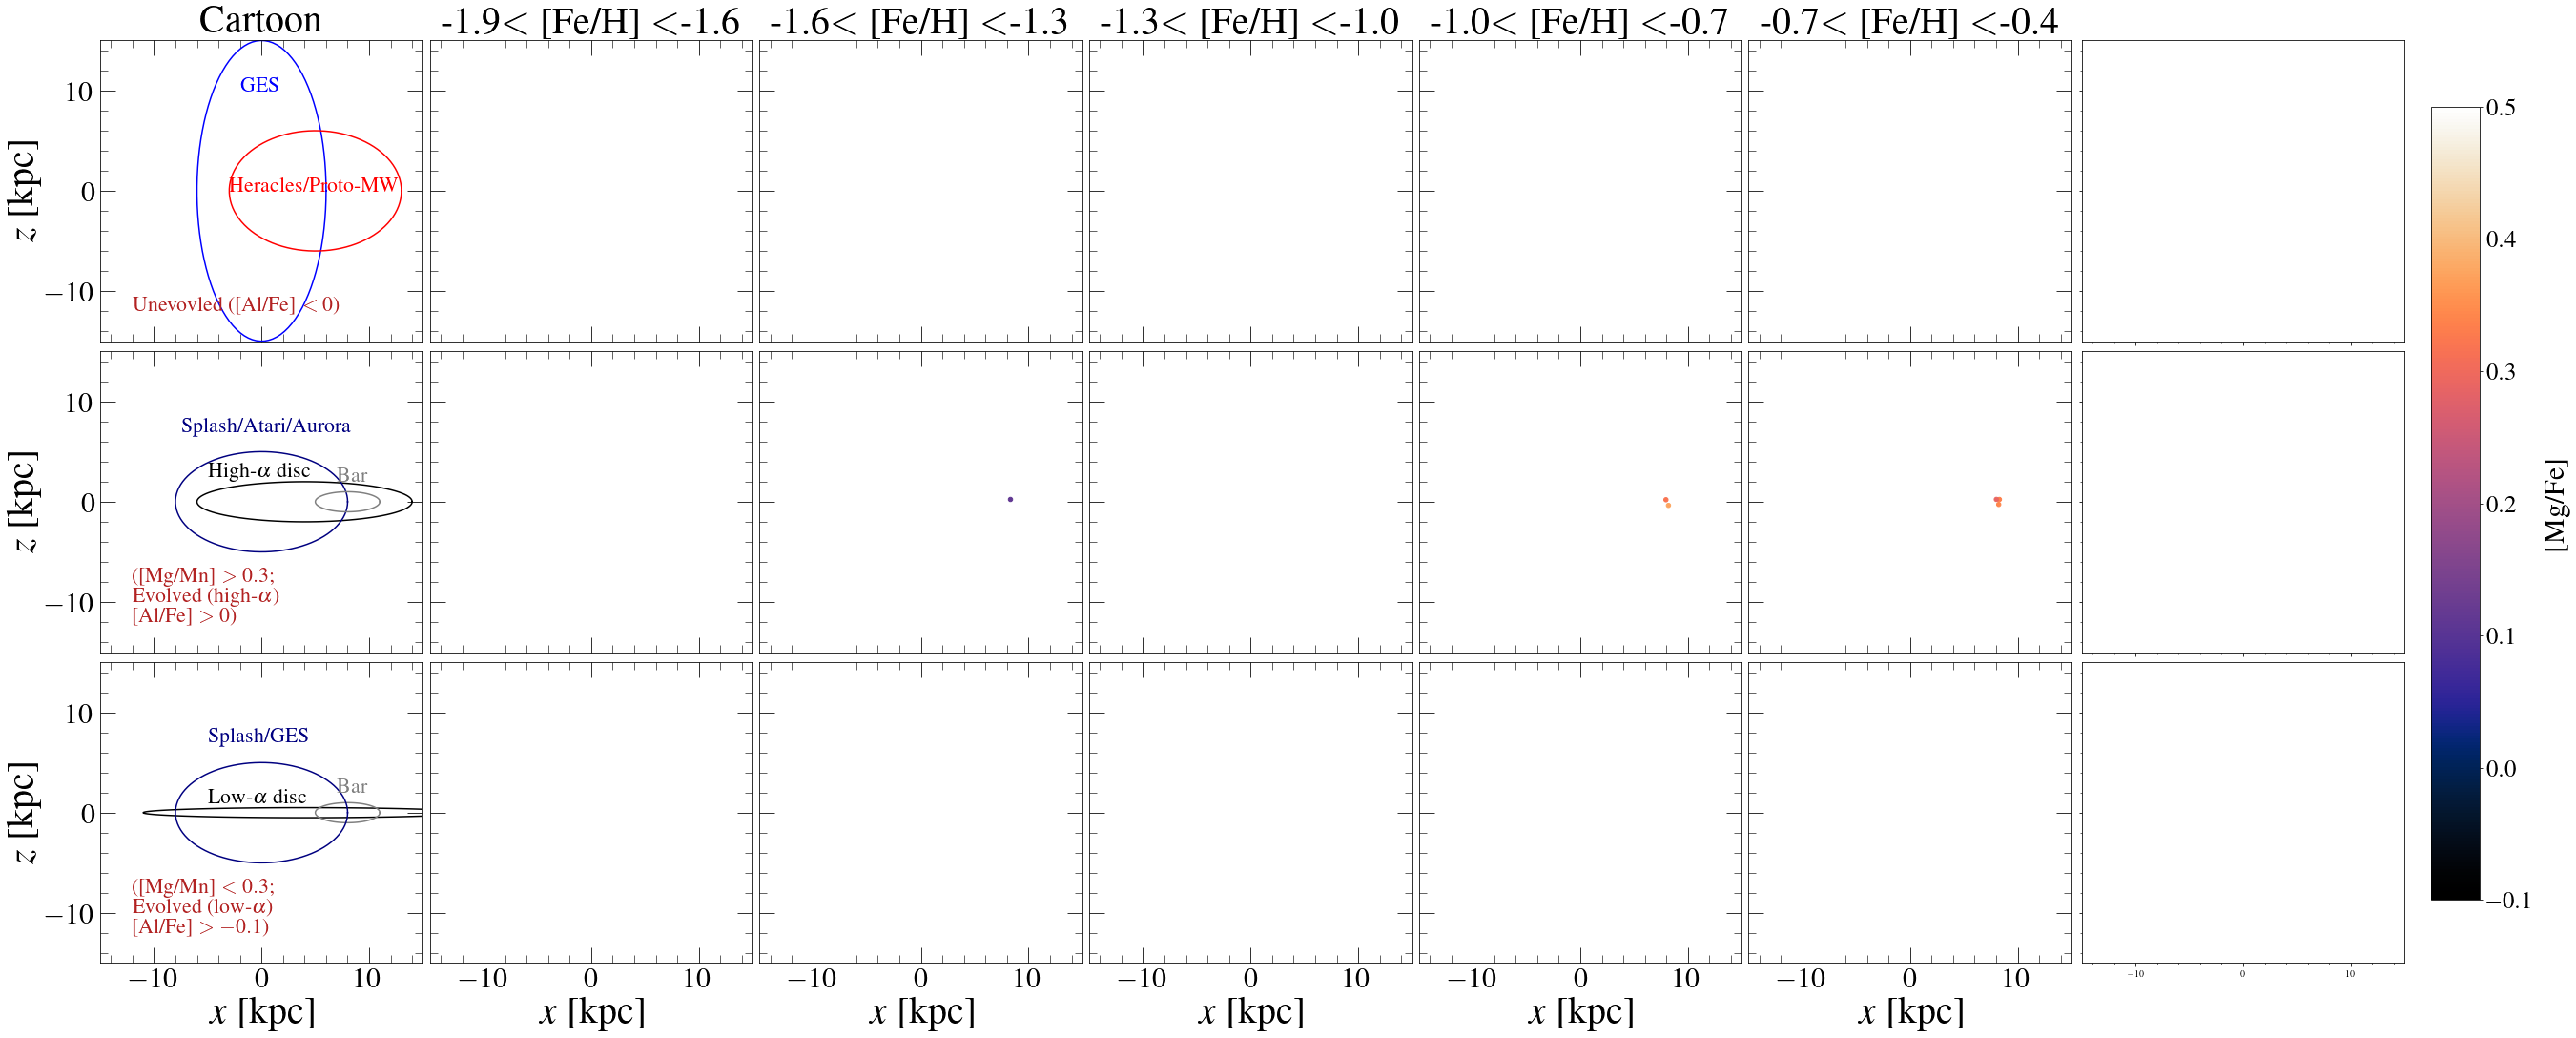

In [80]:
fig, all_axes = plt.subplots(3,7, constrained_layout=True, figsize=(35, 15), sharex=True, sharey=True,rasterized=True, facecolor='white')
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx+1].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=40)    
    color = all_axes[0,indx+1].scatter(X[mask&m&mask_une&(rapo>0)&(rapo<100)],Z[mask&m&mask_une&(rapo>0)&(rapo<100)],s=20, c=data['MG_FE'][mask&m&mask_une&(rapo>0)&(rapo<100)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx+1].set_xlim(-15,15)
    all_axes[0,indx+1].set_ylim(-15,15)
    all_axes[0,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx+1].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[1,indx+1].scatter(X[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],Z[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],s=20, c=data['MG_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn>0.3)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[1,indx+1].set_xlabel('$e$',fontsize=30)
    all_axes[1,indx+1].set_xlim(-15,15)
    all_axes[1,indx+1].set_ylim(-15,15)
    all_axes[1,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx+1].minorticks_on() 
    
    #     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[2,indx+1].scatter(X[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)&(data['AL_FE']>-0.1)],Z[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)&(data['AL_FE']>-0.1)],s=20, c=data['MG_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn<0.3)&(data['AL_FE']>-0.1)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[2,indx+1].set_xlabel('$x$ [kpc]',fontsize=40)
    all_axes[2,indx+1].set_xlim(-15,15)
    all_axes[2,indx+1].set_ylim(-15,15)
    all_axes[2,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[2,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[2,indx+1].minorticks_on() 
    
    
cbar_ax = fig.add_axes([1.01, 0.13, 0.02,0.77])
cb = plt.colorbar(color, cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'[Mg/Fe]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

# all_axes[1,0].text(0.5,3,'Bar', fontsize=24)
# all_axes[1,0].text(0.6,10,'Splash', fontsize=24)
# all_axes[1,0].text(0.1,8,r'High-$\alpha$ disc/', fontsize=24)
# all_axes[1,0].text(0.15,5,r'Aurora', fontsize=24)

# all_axes[0,0].text(0.8,15,'GES', fontsize=24)
# all_axes[0,0].text(0.3,5,'Heracles/Proto-MW', fontsize=24)
# all_axes[0,0].set_title('Cartoon', fontsize=30)

# all_axes[2,0].text(0.1,12,r'Low-$\alpha$ disc', fontsize=24)
# all_axes[2,0].text(0.5,3,'Bar', fontsize=24)
# all_axes[2,0].text(0.6,10,'Splash', fontsize=24)


# u=1.     #x-position of the center
# v=0.5    #y-position of the center
# a=2.     #radius on the x-axis
# b=1.5    #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)
all_axes[0,0].plot( 0+6*np.cos(t) , 0+15*np.sin(t), color='b')
all_axes[0,0].plot( 5+8*np.cos(t) , 0+6*np.sin(t), color='r')


# all_axes[0,0].text(-8.,-6,'$Gaia$-Enceladus/Sausage', fontsize=22, color='b')
all_axes[0,0].text(-2.,10,'GES', fontsize=22, color='b')
all_axes[0,0].text(-3.,0,'Heracles/Proto-MW', fontsize=22, color='r')
all_axes[0,0].set_title('Cartoon', fontsize=40)

all_axes[1,0].plot( 4+10*np.cos(t) , 0+2*np.sin(t), color='k')
all_axes[1,0].text(-5.,2.5,r'High-$\alpha$ disc', fontsize=22, color='k')

all_axes[1,0].plot( 0+8*np.cos(t) , 0+5*np.sin(t), color='navy')
all_axes[1,0].text(-7.5,7,r'Splash/Atari/Aurora', fontsize=22, color='navy')

all_axes[1,0].plot( 8+3*np.cos(t) , 0+1.*np.sin(t), color='gray')
all_axes[1,0].text(7,2,r'Bar', fontsize=22, color='gray')

all_axes[2,0].plot( 4+15*np.cos(t) , 0+0.5*np.sin(t), color='k')
all_axes[2,0].text(-5.,1,r'Low-$\alpha$ disc', fontsize=22, color='k')

all_axes[2,0].plot( 8+3*np.cos(t) , 0+1.*np.sin(t), color='gray')
all_axes[2,0].text(7,2,r'Bar', fontsize=22, color='gray')

all_axes[2,0].plot( 0+8*np.cos(t) , 0+5*np.sin(t), color='navy')
all_axes[2,0].text(-5.,7,r'Splash/GES', fontsize=22, color='navy')


all_axes[2,0].set_xlabel('$x$ [kpc]', fontsize=40)
all_axes[0,0].set_xlim(-15,15)
all_axes[0,0].set_ylim(-15,15)
all_axes[0,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[0,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[0,0].minorticks_on()   
all_axes[1,0].set_xlim(-15,15)
all_axes[1,0].set_ylim(-15,15)
all_axes[1,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[1,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[1,0].minorticks_on()   

all_axes[2,0].set_xlim(-15,15)
all_axes[2,0].set_ylim(-15,15)
all_axes[2,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[2,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[2,0].minorticks_on()   

all_axes[0,0].text(-12,-12,'Unevovled ([Al/Fe] $< 0$)', fontsize=22, color='firebrick')
all_axes[1,0].text(-12,-10,r'Evolved (high-$\alpha$)', fontsize=22, color='firebrick')
all_axes[1,0].text(-12,-8,'([Mg/Mn] $>0.3$;', fontsize=22, color='firebrick')
all_axes[1,0].text(-12,-12,'[Al/Fe] $> 0$)', fontsize=22, color='firebrick')
all_axes[2,0].text(-12,-10,r'Evolved (low-$\alpha$)', fontsize=22, color='firebrick')
all_axes[2,0].text(-12,-8,'([Mg/Mn] $<0.3$;', fontsize=22, color='firebrick')
all_axes[2,0].text(-12,-12,'[Al/Fe] $> -0.1$)', fontsize=22, color='firebrick')
all_axes[2,0].set_ylabel('$z$ [kpc]',fontsize=40)
all_axes[1,0].set_ylabel('$z$ [kpc]',fontsize=40)
all_axes[0,0].set_ylabel('$z$ [kpc]',fontsize=40)
props = dict(boxstyle='round', facecolor='white', alpha=1)

# fig.savefig('../plots/feh-bins-unevolved-evolved-X-Z-mgfe.pdf',dpi=150)


In [ ]:
fig, all_axes = plt.subplots(3,7, constrained_layout=True, figsize=(35, 15), sharex=True, sharey=True,rasterized=True, facecolor='white')
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx+1].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=40)    
    color = all_axes[0,indx+1].scatter(X[mask&m&mask_une&(rapo>0)&(rapo<100)],Y[mask&m&mask_une&(rapo>0)&(rapo<100)],s=20, c=data['MG_FE'][mask&m&mask_une&(rapo>0)&(rapo<100)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx+1].set_xlim(-15,15)
    all_axes[0,indx+1].set_ylim(-15,15)
    all_axes[0,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx+1].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[1,indx+1].scatter(X[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],Y[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],s=20, c=data['MG_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn>0.3)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[1,indx+1].set_xlabel('$e$',fontsize=30)
    all_axes[1,indx+1].set_xlim(-15,15)
    all_axes[1,indx+1].set_ylim(-15,15)
    all_axes[1,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx+1].minorticks_on() 
    
    #     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    all_axes[2,indx+1].scatter(X[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)&(data['AL_FE']>-0.1)],Y[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)&(data['AL_FE']>-0.1)],s=20, c=data['MG_FE'][mask&m&~mask_une&(rapo>0)&(rapo<100)&(mgmn<0.3)&(data['AL_FE']>-0.1)], vmin=-0.1,vmax=0.5, cmap=cm.torch)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[2,indx+1].set_xlabel('$x$ [kpc]',fontsize=40)
    all_axes[2,indx+1].set_xlim(-15,15)
    all_axes[2,indx+1].set_ylim(-15,15)
    all_axes[2,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[2,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[2,indx+1].minorticks_on() 
    
    
cbar_ax = fig.add_axes([1.01, 0.13, 0.02,0.77])
cb = plt.colorbar(color, cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'[Mg/Fe]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

# all_axes[1,0].text(0.5,3,'Bar', fontsize=24)
# all_axes[1,0].text(0.6,10,'Splash', fontsize=24)
# all_axes[1,0].text(0.1,8,r'High-$\alpha$ disc/', fontsize=24)
# all_axes[1,0].text(0.15,5,r'Aurora', fontsize=24)

# all_axes[0,0].text(0.8,15,'GES', fontsize=24)
# all_axes[0,0].text(0.3,5,'Heracles/Proto-MW', fontsize=24)
# all_axes[0,0].set_title('Cartoon', fontsize=30)

# all_axes[2,0].text(0.1,12,r'Low-$\alpha$ disc', fontsize=24)
# all_axes[2,0].text(0.5,3,'Bar', fontsize=24)
# all_axes[2,0].text(0.6,10,'Splash', fontsize=24)


# u=1.     #x-position of the center
# v=0.5    #y-position of the center
# a=2.     #radius on the x-axis
# b=1.5    #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)
all_axes[0,0].plot( 4+10*np.cos(t) , 0+10*np.sin(t), color='b')
all_axes[0,0].plot( 5+8*np.cos(t) , 0+8*np.sin(t), color='r')


# all_axes[0,0].text(-8.,-6,'$Gaia$-Enceladus/Sausage', fontsize=22, color='b')
all_axes[0,0].text(4.,10,'GES', fontsize=22, color='b')
all_axes[0,0].text(-3.,0,'Heracles/Proto-MW', fontsize=22, color='r')
all_axes[0,0].set_title('Cartoon', fontsize=40)

all_axes[1,0].plot( 4+8*np.cos(t) , 0+8*np.sin(t), color='k')
all_axes[1,0].text(0.,2.5,r'High-$\alpha$ disc', fontsize=22, color='k')

all_axes[1,0].plot( 4+10*np.cos(t) , 0+10*np.sin(t), color='navy')
all_axes[1,0].text(-2,9,r'Splash/Atari/Aurora', fontsize=22, color='navy')

# all_axes[1,0].plot( 8+3*np.cos(t) , 0+1.*np.sin(t), color='gray')
# all_axes[1,0].text(7,2,r'Bar', fontsize=22, color='gray')

all_axes[2,0].plot( 4+15*np.cos(t) , 0+15*np.sin(t), color='k')
all_axes[2,0].text(0.,10,r'Low-$\alpha$ disc', fontsize=22, color='k')


all_axes[2,0].plot( 4+10*np.cos(t) , 0+10*np.sin(t), color='navy')
all_axes[2,0].text(0.,6,r'Splash/GES', fontsize=22, color='navy')

all_axes[2,0].plot( 8+3*np.cos(t) , 0+1.*np.sin(t), color='gray')
all_axes[2,0].text(7,2,r'Bar', fontsize=22, color='gray')



all_axes[2,0].set_xlabel('$x$ [kpc]', fontsize=40)
all_axes[0,0].set_xlim(-15,15)
all_axes[0,0].set_ylim(-15,15)
all_axes[0,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[0,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[0,0].minorticks_on()   
all_axes[1,0].set_xlim(-15,15)
all_axes[1,0].set_ylim(-15,15)
all_axes[1,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[1,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[1,0].minorticks_on()   

all_axes[2,0].set_xlim(-15,15)
all_axes[2,0].set_ylim(-15,15)
all_axes[2,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[2,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[2,0].minorticks_on()   

all_axes[0,0].text(-12,-12,'Unevovled ([Al/Fe] $< 0$)', fontsize=22, color='firebrick')
all_axes[1,0].text(-12,-10,r'Evolved (high-$\alpha$)', fontsize=22, color='firebrick')
all_axes[1,0].text(-12,-8,'([Mg/Mn] $>0.3$;', fontsize=22, color='firebrick')
all_axes[1,0].text(-12,-12,'[Al/Fe] $> 0$)', fontsize=22, color='firebrick')
all_axes[2,0].text(-12,-10,r'Evolved (low-$\alpha$)', fontsize=22, color='firebrick')
all_axes[2,0].text(-12,-8,'([Mg/Mn] $<0.3$;', fontsize=22, color='firebrick')
all_axes[2,0].text(-12,-12,'[Al/Fe] $> -0.1$)', fontsize=22, color='firebrick')
all_axes[2,0].set_ylabel('$y$ [kpc]',fontsize=40)
all_axes[1,0].set_ylabel('$y$ [kpc]',fontsize=40)
all_axes[0,0].set_ylabel('$y$ [kpc]',fontsize=40)
props = dict(boxstyle='round', facecolor='white', alpha=1)

# fig.savefig('../plots/feh-bins-unevolved-evolved-X-Y-mgfe.pdf',dpi=150)


In [90]:
vR = data['vR']*220.

In [91]:
np.nanmin(vR[mask&m&mask_une&(rapo>0)&(rapo<100)])

-381.1665

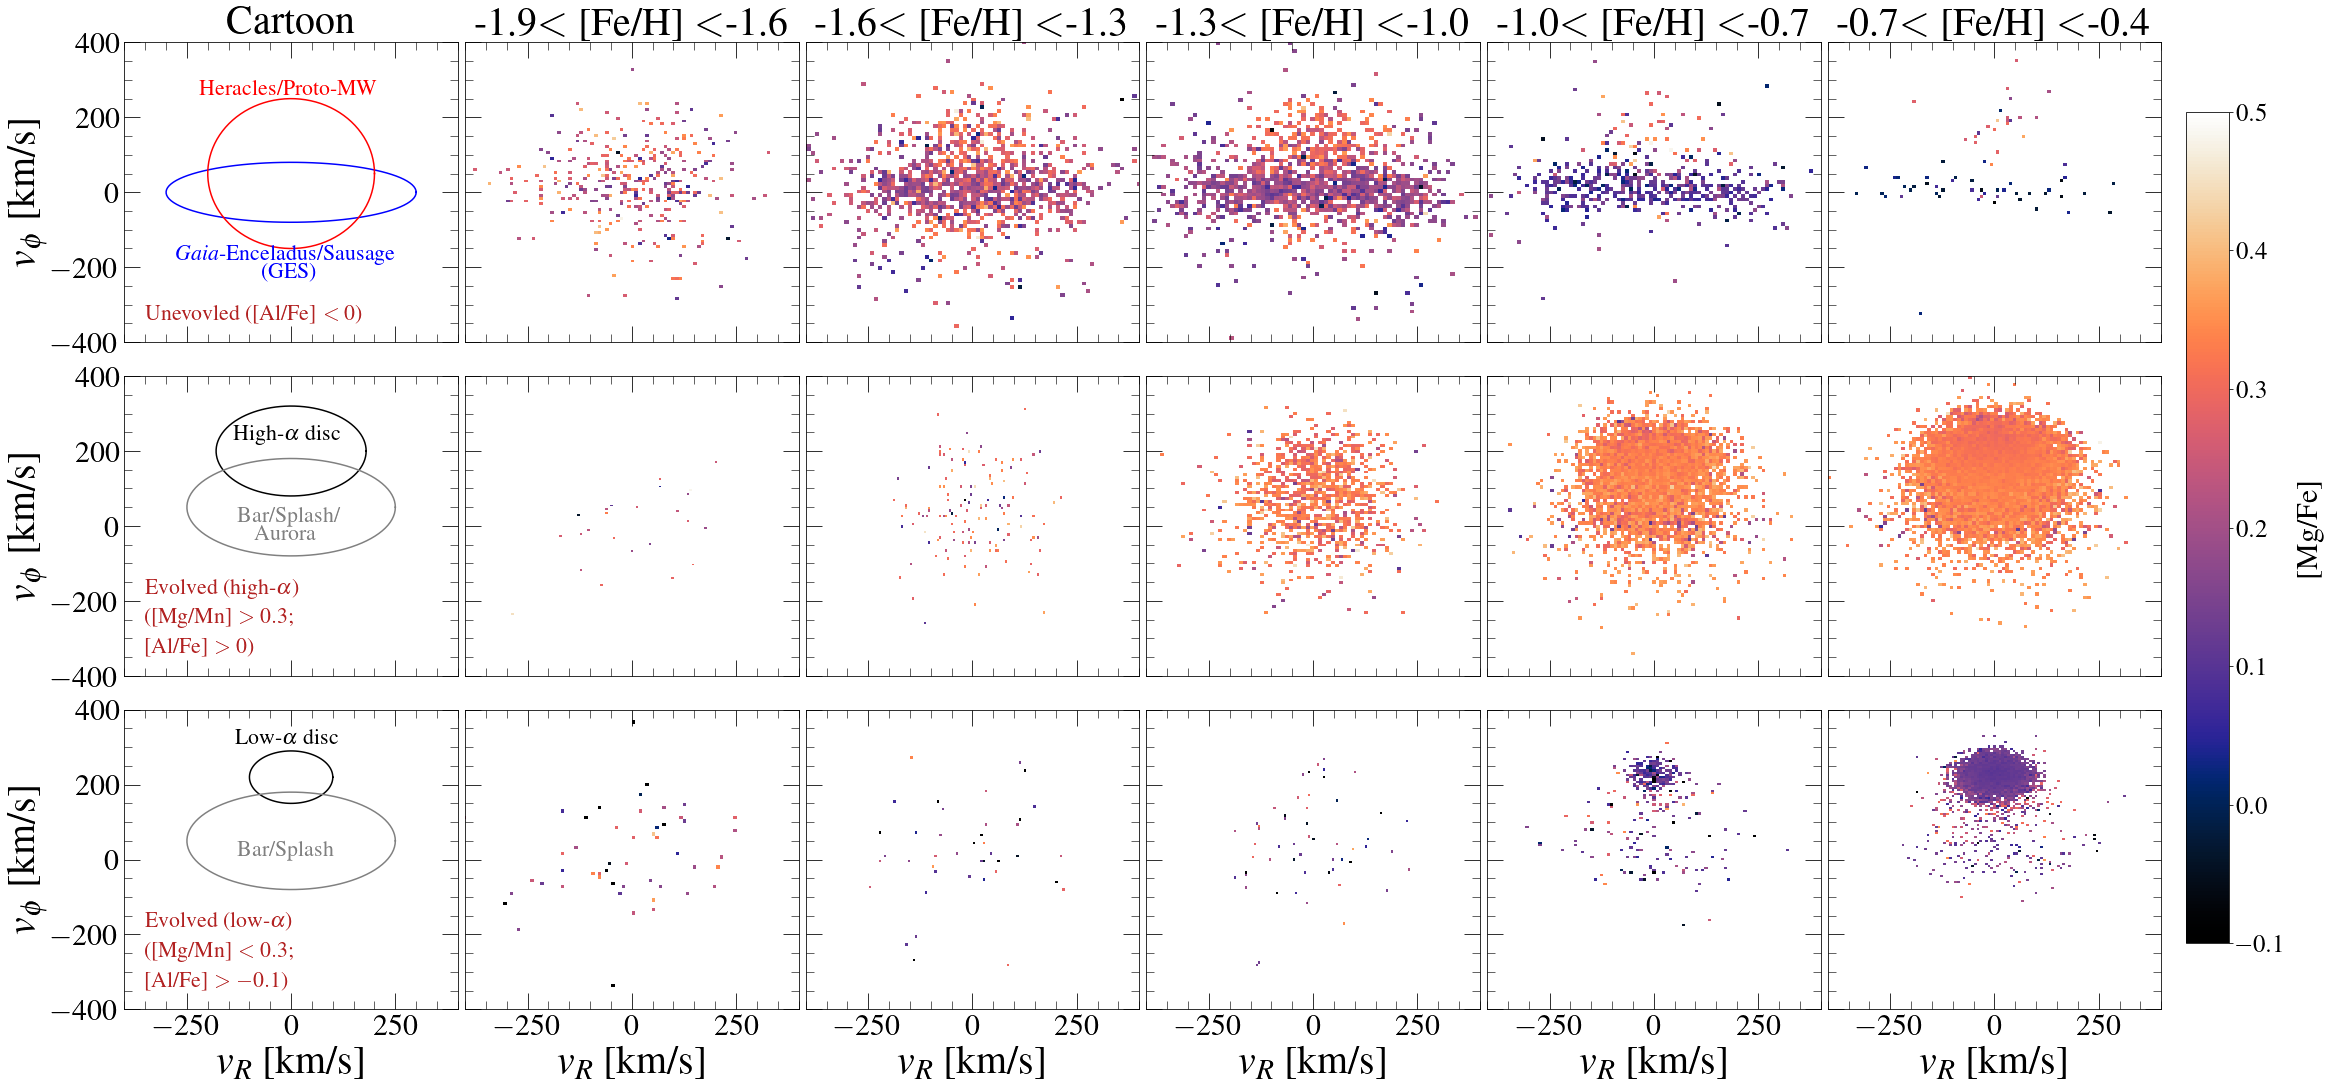

In [94]:
fig, all_axes = plt.subplots(3,6, constrained_layout=True, figsize=(30, 15), sharex=True, sharey=True,rasterized=True, facecolor='white')
# fig.suptitle('[Fe/H] $<-0.4$',fontsize=40)

nbins = 82

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])
    all_axes[0,indx+1].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=40)    

    binx = np.linspace(np.min(vR[mask&m&mask_une&(rapo>0)&(rapo<100)]),np.max(vR[mask&m&mask_une&(rapo>0)&(rapo<100)]),nbins)
    biny = np.linspace(np.min(vphi[mask&m&mask_une&(rapo>0)&(rapo<100)]),np.max(vphi[mask&m&mask_une&(rapo>0)&(rapo<100)]),nbins)
    hist = stats.binned_statistic_2d(vR[mask&m&mask_une&(rapo>0)&(rapo<100)],vphi[mask&m&mask_une&(rapo>0)&(rapo<100)], data['MG_FE'][mask&m&mask_une&(rapo>0)&(rapo<100)], statistic='mean', bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = all_axes[0,indx+1].pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.torch,vmin=-0.1,vmax=0.5, rasterized=True)
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('$x$ [kpc]',fontsize=30)
    all_axes[0,indx+1].set_xlim(-400,400)
    all_axes[0,indx+1].set_ylim(-400,400)
    all_axes[0,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx+1].minorticks_on()   
    
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    binx = np.linspace(np.min(vR[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)]),np.max(vR[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)]),nbins)
    biny = np.linspace(np.min(vphi[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)]),np.max(vphi[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)]),nbins)
    hist = stats.binned_statistic_2d(vR[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)],vphi[mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)], data['MG_FE'][mask&m&~mask_une&(mgmn>0.3)&(rapo>0)&(rapo<100)], statistic='mean', bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    all_axes[1,indx+1].pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.torch,vmin=-0.1,vmax=0.5, rasterized=True)
    #     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[1,indx+1].set_xlabel('$e$',fontsize=30)
    all_axes[1,indx+1].set_xlim(-400,400)
    all_axes[1,indx+1].set_ylim(-400,400)
    all_axes[1,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx+1].minorticks_on() 
    
    #     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=30)    
    binx = np.linspace(np.min(vR[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)]),np.max(vR[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)]),nbins)
    biny = np.linspace(np.min(vphi[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)]),np.max(vphi[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)]),nbins)
    hist = stats.binned_statistic_2d(vR[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)],vphi[mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)], data['MG_FE'][mask&m&~mask_une&(mgmn<0.3)&(rapo>0)&(rapo<100)], statistic='mean', bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    all_axes[2,indx+1].pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.torch,vmin=-0.1,vmax=0.5, rasterized=True)
 #     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[2,indx+1].set_xlabel('$v_{R}$ [km/s]',fontsize=40)
    all_axes[2,indx+1].set_xlim(-400,400)
    all_axes[2,indx+1].set_ylim(-400,400)
    all_axes[2,indx+1].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[2,indx+1].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[2,indx+1].minorticks_on() 
    
    
cbar_ax = fig.add_axes([1.01, 0.13, 0.02,0.77])
cb = plt.colorbar(color, cax = cbar_ax,orientation='vertical')
cb.set_label(label=r'[Mg/Fe]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

# all_axes[1,0].text(0.5,3,'Bar', fontsize=24)
# all_axes[1,0].text(0.6,10,'Splash', fontsize=24)
# all_axes[1,0].text(0.1,8,r'High-$\alpha$ disc/', fontsize=24)
# all_axes[1,0].text(0.15,5,r'Aurora', fontsize=24)

# all_axes[0,0].text(0.8,15,'GES', fontsize=24)
# all_axes[0,0].text(0.3,5,'Heracles/Proto-MW', fontsize=24)
# all_axes[0,0].set_title('Cartoon', fontsize=30)

# all_axes[2,0].text(0.1,12,r'Low-$\alpha$ disc', fontsize=24)
# all_axes[2,0].text(0.5,3,'Bar', fontsize=24)
# all_axes[2,0].text(0.6,10,'Splash', fontsize=24)


# u=1.     #x-position of the center
# v=0.5    #y-position of the center
# a=2.     #radius on the x-axis
# b=1.5    #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)
all_axes[0,0].plot( 0+300*np.cos(t) , 0+80*np.sin(t), color='b')
all_axes[0,0].plot( 0+200*np.cos(t) , 50+200*np.sin(t), color='r')


all_axes[0,0].text(-275.,-180,'$Gaia$-Enceladus/Sausage', fontsize=22, color='b')
all_axes[0,0].text(-70.,-230,'(GES)', fontsize=22, color='b')
all_axes[0,0].text(-220.,260,'Heracles/Proto-MW', fontsize=22, color='r')
all_axes[0,0].set_title('Cartoon', fontsize=40)

all_axes[1,0].plot( 0+180*np.cos(t) , 200+120*np.sin(t), color='k')
all_axes[1,0].text(-140.,230,r'High-$\alpha$ disc', fontsize=22, color='k')

all_axes[1,0].plot( 0+250*np.cos(t) , 50+130*np.sin(t), color='gray')
all_axes[1,0].text(-130.,10,r'Bar/Splash/', fontsize=22, color='gray')
all_axes[1,0].text(-90.,-35,r'Aurora', fontsize=22, color='gray')

all_axes[2,0].plot( 0+100*np.cos(t) , 220+70*np.sin(t), color='k')
all_axes[2,0].text(-135.,310,r'Low-$\alpha$ disc', fontsize=22, color='k')

all_axes[2,0].plot( 0+250*np.cos(t) , 50+130*np.sin(t), color='gray')
all_axes[2,0].text(-130.,10,r'Bar/Splash', fontsize=22, color='gray')


all_axes[2,0].set_xlabel('$v_{R}$ [km/s]', fontsize=40)
all_axes[0,0].set_xlim(-400,400)
all_axes[0,0].set_ylim(-400,400)
all_axes[0,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[0,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[0,0].minorticks_on()   
all_axes[1,0].set_xlim(-400,400)
all_axes[1,0].set_ylim(-400,400)
all_axes[1,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[1,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[1,0].minorticks_on()   

all_axes[2,0].set_xlim(-400,400)
all_axes[2,0].set_ylim(-400,400)
all_axes[2,0].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
all_axes[2,0].tick_params(which='minor', length=8, direction='in',top=True,right=True)
all_axes[2,0].minorticks_on()   

all_axes[0,0].text(-350,-340,'Unevovled ([Al/Fe] $< 0$)', fontsize=22, color='firebrick')
all_axes[1,0].text(-350,-180,r'Evolved (high-$\alpha$)', fontsize=22, color='firebrick')
all_axes[1,0].text(-350,-260,'([Mg/Mn] $>0.3$;', fontsize=22, color='firebrick')
all_axes[1,0].text(-350,-340,'[Al/Fe] $> 0$)', fontsize=22, color='firebrick')
all_axes[2,0].text(-350,-180,r'Evolved (low-$\alpha$)', fontsize=22, color='firebrick')
all_axes[2,0].text(-350,-260,'([Mg/Mn] $<0.3$;', fontsize=22, color='firebrick')
all_axes[2,0].text(-350,-340,'[Al/Fe] $> -0.1$)', fontsize=22, color='firebrick')
all_axes[2,0].set_ylabel('$v_{\phi}$ [km/s]',fontsize=40)
all_axes[1,0].set_ylabel('$v_{\phi}$ [km/s]',fontsize=40)
all_axes[0,0].set_ylabel('$v_{\phi}$ [km/s]',fontsize=40)
props = dict(boxstyle='round', facecolor='white', alpha=1)

# fig.savefig('../plots/feh-bins-unevolved-evolved-vphi-vR-mgfe.pdf',dpi=150)


In [ ]:
plt.figure(figsize=(6,5), facecolor='white')
plt.title('[Fe/H] $<-0.8$', fontsize=25)
plt.hist(data['AL_FE'][mask&(data['FE_H']<-0.8)], bins=np.linspace(-0.5,0.5,21), histtype='step',lw=4, color='gray', density=True, label='All')
# plt.hist(data['AL_FE'][mask&~mask_une&(mgmn>0.3)], bins=np.linspace(-0.5,0.5,11), histtype='step',lw=4, color='k', density=True, label='Evolved ([Mg/Mn $>0.3$)')
# plt.hist(data['AL_FE'][mask&mask_une], bins=np.linspace(-0.5,0.5,11), histtype='step',lw=4, color='r', density=True, label='Unevolved')
plt.xlabel('[Al/Fe]', fontsize=20)
plt.ylabel('Norm. Freq.', fontsize=20)
plt.legend(loc='upper left', frameon=False, fontsize=15)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()  

In [ ]:
plt.figure(figsize=(6,5), facecolor='white')
# plt.title('[Fe/H] $<-0.8$', fontsize=25)
# plt.hist(data['AL_FE'][mask&(data['FE_H']<-0.8)], bins=np.linspace(-0.5,0.5,21), histtype='step',lw=4, color='gray', density=True, label='All')
plt.hist(data['AL_FE'][mask&~mask_une&(mgmn>0.3)], bins=np.linspace(-0.5,0.5,11), histtype='step',lw=4, color='k', density=True, label='Evolved ([Mg/Mn $>0.3$)')
plt.hist(data['AL_FE'][mask&mask_une], bins=np.linspace(-0.5,0.5,11), histtype='step',lw=4, color='r', density=True, label='Unevolved')
plt.xlabel('[Al/Fe]', fontsize=20)
plt.ylabel('Norm. Freq.', fontsize=20)
plt.legend(loc='upper left', frameon=False, fontsize=15)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10, pad=5)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()  

In [ ]:
plt.scatter(data['SNR'][mask&mask_une], data['MN_FE'][mask&mask_une], s=1)
plt.xlim(0,100)

In [ ]:
plt.scatter(data['SNR'][mask&mask_une], data['MN_FE'][mask&mask_une], s=1)
plt.xlim(0,100)

In [ ]:
# make XYZ plot of both unevolved and evolved populations as a function of Fe/H to see if those metal poor disc stars are
# in a similar region of space as Heracles
# also look at kinematics


In [ ]:
def plot_R_z_var_dens(Rg,zmax,var1,var2, Rg_n = 7, zmax_n = 4,label1 = '[Mg/H]',label2='[Fe/Mg]',\
                         xlim0=-1,xlim1=0.6,ylim0=-0.5,ylim1=0.15,nstarsx=0.0,nstarsy=-0.475):
    
    """
    Function to plot two variables (var1,var2) gridded in an Rg-zmax plane
    
    INPUT: Guiding-centre radius, maximum vertical height, variable 1, variable 2
    
    OUTPUT: Plot of var 1 vs var 2 in a grid of Rg and zmax
    
    """
    
    # split the Rg array into Rg_n bins (input 5)
    rg_bins = np.around(np.linspace(0,14,Rg_n+1),decimals=2)
    zmax_bins = np.flip(np.around(np.linspace(-4,4,zmax_n+1),decimals=2))
    
    # create the plot
    fig, all_axes = plt.subplots(zmax_n,Rg_n, constrained_layout=True, figsize=(30, 16), sharex=True, sharey=True,rasterized=True, facecolor='white')
    
    fig.suptitle('Galactrocentric radius, $R$ [kpc]', fontsize=50, y = 1.05)
    fig.supylabel('Height above the plane, $z$ [kpc]',fontsize=50, x= -0.04)    

    # loop over the grid
    for indx, i in enumerate(zmax_bins[:-1]):
        axis = all_axes[indx]
        for jndx, j in enumerate(rg_bins[:-1]):
            ax = axis[jndx]
            # create a mask for every loop
            mask_loop = (Rg>j)&(Rg<rg_bins[jndx+1])&(zmax<i)&(zmax>zmax_bins[indx+1])
            # make the plot
            ax.hist2d(var1[mask_loop],var2[mask_loop],bins=100,norm=LogNorm(),cmap=cm.lavender)
            ax.plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
            ax.plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
            ax.plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dashed')
            ax.plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dashed')

            ax.set_xlim(xlim0,xlim1)
            ax.set_ylim(ylim0,ylim1)
#             ax.plot([-0.6,-0.1],[0.35,0.2],color='r',lw=5)
            ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
            props = dict(boxstyle='round', facecolor='white', alpha=1)
            ax.text(nstarsx,nstarsy,r'N$_{\mathrm{stars}}$ '+str(len(var2[mask_loop])),fontsize=20,bbox=props)
            ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
            ax.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
            ax.minorticks_on()
    
    all_axes[0,0].set_title(r'' +str('%5.2f' %rg_bins[0])+ r'$<$ $R$ [kpc] $<$ '+str('%5.2f' %rg_bins[1]),fontsize=28,pad=15)
    all_axes[0,1].set_title(r'' +str('%5.2f' %rg_bins[1])+ r'$<$ $R$ [kpc] $<$ '+str('%5.2f' %rg_bins[2]),fontsize=28,pad=15)
    all_axes[0,2].set_title(r'' +str('%5.2f' %rg_bins[2])+ r'$<$ $R$ [kpc] $<$ '+str('%5.2f' %rg_bins[3]),fontsize=28,pad=15)
    all_axes[0,3].set_title(r'' +str('%5.2f' %rg_bins[3])+ r'$<$ $R$ [kpc] $<$ '+str('%5.2f' %rg_bins[4]),fontsize=28,pad=15)
    all_axes[0,4].set_title(r'' +str('%5.2f' %rg_bins[4])+ r'$<$ $R$ [kpc] $<$ '+str('%5.2f' %rg_bins[5]),fontsize=28,pad=15)
    all_axes[0,5].set_title(r'' +str('%5.2f' %rg_bins[5])+ r'$<$ $R$ [kpc] $<$ '+str('%5.2f' %rg_bins[6]),fontsize=28,pad=15)
    all_axes[0,6].set_title(r'' +str('%5.2f' %rg_bins[6])+ r'$<$ $R$ [kpc] $<$ '+str('%5.2f' %rg_bins[7]),fontsize=28,pad=15)

    all_axes[0,0].set_ylabel(r'' +str('%5.0f' %zmax_bins[1])+ r'$<$ $z$ [kpc] $<$ '+str('%5.0f' %zmax_bins[0])+' \n '+str(label2),fontsize=28,labelpad=15)
    all_axes[1,0].set_ylabel(r'' +str('%5.0f' %zmax_bins[2])+ r'$<$ $z$ [kpc] $<$ '+str('%5.0f' %zmax_bins[1])+' \n '+str(label2),fontsize=28,labelpad=15)
    all_axes[2,0].set_ylabel(r'' +str('%5.0f' %zmax_bins[3])+ r'$<$ $z$ [kpc] $<$ '+str('%5.0f' %zmax_bins[2])+' \n '+str(label2),fontsize=28,labelpad=15)
    all_axes[3,0].set_ylabel(r'' +str('%5.0f' %zmax_bins[4])+ r'$<$ $z$ [kpc] $<$ '+str('%5.0f' %zmax_bins[3])+' \n '+str(label2),fontsize=28,labelpad=15)
    
    all_axes[0,0].text(-0.5,1.35,'Inner Galaxy', fontsize=40)
    all_axes[0,-1].text(-0.5,1.35,'Outer Galaxy', fontsize=40)

    props = dict(boxstyle='round', facecolor='white', alpha=1)
    all_axes[0,0].text(-0.4,0.8,r'Unevolved',fontsize=14,bbox=props)
    # plt.text(0.35,0.,r'Evolved',fontsize=20,bbox=props)
    all_axes[0,0].text(0.2,0.75,r'High-$\alpha$ disc',fontsize=14,bbox=props)
    all_axes[0,0].text(0.2,-0.3,r'Low-$\alpha$ disc',fontsize=14,bbox=props)
#     fig.arrow(0.5,0.35,dx=5,dy=1,color='k',head_width=0.2,head_length=0.2)
#     cbar = fig.colorbar(color, ax = axis, aspect=15)
#     cbar.set_label(label='N$_{\mathrm{stars}}$',fontsize=25)
#     cbar.ax.tick_params(labelsize=25)
    
    for ax in all_axes[-1]:
        ax.set_xlabel(label1,fontsize=28,labelpad=4)
#     for ax in all_axes[:, 0]:
#         ax.set_ylabel(label2,fontsize=30)

#     fig.savefig('../plots/rg-zmax-mgfe.pdf',dpi=150)


In [ ]:
Rgal = data['Rgal']*8.178
Zgal = data['Zgal']*8.178

In [ ]:
mask_plot = (Rgal>0)&(Rgal<20)&(Zgal>-10)&(Zgal<10)&(np.abs(data['AL_FE'])<3)&(np.abs(mgmn)<3)&mask

plot_R_z_var_dens(Rgal[mask_plot],Zgal[mask_plot],data['AL_FE'][mask_plot],mgmn[mask_plot],\
                     label1='[Al/Fe]',label2='[Mg/Mn]',xlim0=-0.55,xlim1=0.55,ylim0=-0.55,ylim1=1,\
                     nstarsx=-0.5,nstarsy=-0.4)

plt.savefig('../plots/magnamal-r-z.pdf',dpi=200, bbox_inches = 'tight')


In [ ]:
# get the rapos using gala and APW's new potential

# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

# Gala
import gala.dynamics as gd
import gala.potential as gp

In [ ]:
coord.galactocentric_frame_defaults.set("v4.0")
potential = gp.MilkyWayPotential2022()


In [ ]:
print(len(data[mask&mask_une]))

In [ ]:
icrs = coord.SkyCoord(
    ra=data['RA'][mask&mask_une]*u.degree,
    dec=data['DEC'][mask&mask_une]*u.degree,
    distance=data['weighted_dist'][mask&mask_une]*u.pc,
    pm_ra_cosdec=data['pmra'][mask&mask_une]* u.mas / u.yr,
    pm_dec=data['pmdec'][mask&mask_une] * u.mas / u.yr,
    radial_velocity=data['VHELIO_AVG'][mask&mask_une] * u.km / u.s,
)

icrs_err = coord.SkyCoord(
    ra=0 * u.deg,
    dec=0 * u.deg,
    distance=data['weighted_dist_error'][mask&mask_une] * u.pc,
    pm_ra_cosdec=data['pmra_error'][mask&mask_une] * u.mas / u.yr,
    pm_dec=data['pmdec_error'][mask&mask_une] * u.mas / u.yr,
    radial_velocity=data['VSCATTER'][mask&mask_une] * u.km / u.s,
)


In [ ]:
galcen_frame = coord.Galactocentric()
galcen_frame
galcen = icrs.transform_to(galcen_frame)


In [ ]:
w0 = gd.PhaseSpacePosition(galcen.data)
orbit = potential.integrate_orbit(w0, dt=-0.5 * u.Myr, n_steps=10000)


In [ ]:
galcen.shape

In [ ]:
rads = np.sqrt(Rgal**2+Zgal**2)
rapo = np.array(orbit.apocenter())
ecc = np.array(orbit.eccentricity())

In [201]:
np.save('../sav/rapo_gala', np.array(rapo))
# np.save('../sav/ecc_gala', np.array(orbit.eccentricity()))

In [ ]:
rapo = np.array(rapo)
ecc = np.array(orbit.eccentricity())

In [ ]:
from scipy.optimize import curve_fit
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

y,binx_edges= np.histogram(rapo,np.linspace(0,50,51))
bincentres=(binx_edges[1:]+binx_edges[:-1])/2 # for len(x)==len(y)

expected=(3,1,180,10,5,330)
params,cov=curve_fit(bimodal,bincentres,y, expected)

In [ ]:
params

In [ ]:
fig = plt.figure(figsize=(7,6), facecolor='white')

rapo_fit = np.linspace(0, 50, 500)

plt.hist(rapo,bins=np.linspace(0,50,51),histtype='step', color= 'k', lw=4, label='Unevolved')
plt.hist(rapo,bins=np.linspace(0,50,51), color= 'k', alpha=0.2)
plt.xlabel('Apocentric radius, $R_{\mathrm{apo}}$ [kpc]', fontsize=25)
plt.ylabel('Number density', fontsize=25)
plt.plot(rapo_fit, bimodal(rapo_fit, *params), color='red', lw=3, label='Best fit bi-modal Gaussian')
# plt.plot(rapo_fit, gauss(rapo_fit, *params[:3]), color='red', lw=1, ls="--")
# plt.plot(rapo_fit, gauss(rapo_fit, *params[3:]), color='red', lw=1, ls="--")

plt.xlim(0,40)
# plt.ylim(0,0.0015)
# plt.xscale('log')
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()
plt.arrow(10.5,100,0,70, head_width = 1., head_length=10, color='k')
plt.text(9.,80,'GES', fontsize=20)
plt.ylim(0,400)
plt.arrow(3,50,0,70, head_width = 1, head_length=10, color='k')
plt.text(1.2,30,'Heracles/Proto-Galaxy', fontsize=20)

plt.savefig('../plots/rapo.pdf',dpi=200, bbox_inches = 'tight')



In [ ]:
fig = plt.figure(figsize=(7,6), facecolor='white')

rapo_fit = np.linspace(0, 50, 500)

plt.hist(rapo[(rapo>0)&(rapo<100)&mask&~mask_une&(mgmn>0.3)],bins=np.linspace(0,20,21),histtype='step', color= 'k', lw=4, label='Evolved')
plt.hist(rapo[(rapo>0)&(rapo<100)&mask&~mask_une&(mgmn>0.3)],bins=np.linspace(0,20,21), color= 'k', alpha=0.2)
plt.xlabel('Apocentric radius, $R_{\mathrm{apo}}$ [kpc]', fontsize=25)
plt.ylabel('Number density', fontsize=25)
# plt.plot(rapo_fit, gauss(rapo_fit, *params[:3]), color='red', lw=1, ls="--")
# plt.plot(rapo_fit, gauss(rapo_fit, *params[3:]), color='red', lw=1, ls="--")

plt.xlim(0,20)
# plt.ylim(0,0.0015)
# plt.xscale('log')
plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.arrow(10.5,100,0,70, head_width = 1., head_length=10, color='k')
# plt.text(9.,80,'GES', fontsize=20)
# plt.ylim(0,400)
# plt.arrow(3,50,0,70, head_width = 1, head_length=10, color='k')
# plt.text(1.2,30,'Heracles/Proto-Galaxy', fontsize=20)

# plt.savefig('../plots/rapo.pdf',dpi=200, bbox_inches = 'tight')



In [ ]:
plt.scatter(data['FE_H'][mask], data['AL_FE'][mask],s=0.1,alpha=1,c='k')
plt.scatter(data['FE_H'][mask&mask_une], data['AL_FE'][mask&mask_une],s=1)
plt.ylim(-0.8,0.8)
plt.hlines(-0.07, -2,0, color='k')

In [92]:
rapo = np.load('../sav/rapo_gala.npy', allow_pickle=True)
rperi = np.load('../sav/rperi_gala.npy', allow_pickle=True)
ecc = np.load('../sav/ecc_gala.npy', allow_pickle=True)

In [40]:
def get_running_median(xs, ys):
    
    bins = np.linspace(np.nanmin(xs), np.nanmax(xs), 8)
    
    xs_medians = []
    ys_medians = []
    
    for indx, i in enumerate(bins[:-1]):
        mask = (xs< bins[indx+1]) & (xs > i)
        xs_medians.append(np.nanmedian(xs[mask]))
        ys_medians.append(np.nanmedian(ys[mask]))
    
    return np.array(xs_medians), np.array(ys_medians)

In [41]:
def get_running_mean(xs, ys):
    
    bins = np.linspace(np.nanmin(xs), np.nanmax(xs), 8)
    
    xs_means = []
    ys_means = []
    
    for indx, i in enumerate(bins[:-1]):
        mask = (xs< bins[indx+1]) & (xs > i)
        xs_means.append(np.nanmean(xs[mask]))
        ys_means.append(np.nanmean(ys[mask]))
    
    return np.array(xs_means), np.array(ys_means)

In [42]:
xs_rapo_low, ys_rapo_low = get_running_median(data['FE_H'][mask&mask_une][(rapo<5)&(data['FE_H'][mask&mask_une]<-0.9)],\
                                              data['MG_FE'][mask&mask_une][(rapo<5)&(data['FE_H'][mask&mask_une]<-0.9)])
xs_rapo_high, ys_rapo_high = get_running_median(data['FE_H'][mask&mask_une][(rapo>8)&(data['FE_H'][mask&mask_une]<-0.6)],\
                                              data['MG_FE'][mask&mask_une][(rapo>8)&(data['FE_H'][mask&mask_une]<-0.6)])

# xs_rapo_low_mean, ys_rapo_low_mean = get_running_mean(data['FE_H'][mask&mask_une][(rapo<5)&(data['FE_H'][mask&mask_une]<-0.9)],\
#                                               data['MG_FE'][mask&mask_une][(rapo<5)&(data['FE_H'][mask&mask_une]<-0.9)])
# xs_rapo_high_mean, ys_rapo_high_mean = get_running_mean(data['FE_H'][mask&mask_une][(rapo>8)&(data['FE_H'][mask&mask_une]<-0.6)],\
#                                               data['MG_FE'][mask&mask_une][(rapo>8)&(data['FE_H'][mask&mask_une]<-0.6)])


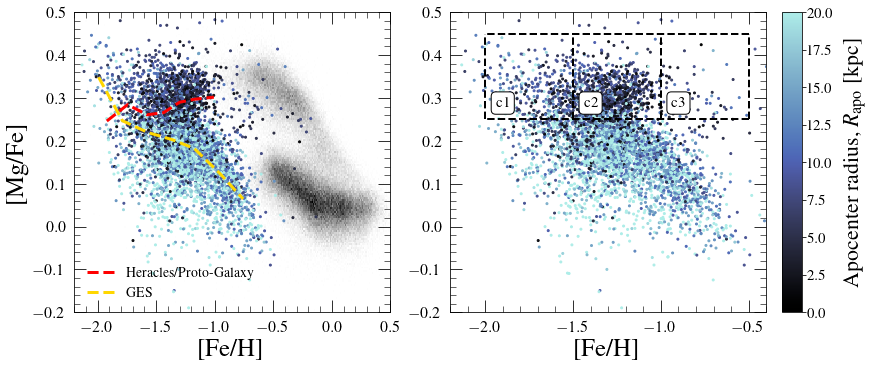

In [44]:
# plot the Tinsley diagram

fig = plt.figure(figsize=(12,5), facecolor='white', constrained_layout=True)

plt.subplot(1,2,1)
plt.hist2d(data['FE_H'][mask], data['MG_FE'][mask],bins=300, cmap='binary',rasterized=True)
color = plt.scatter(data['FE_H'][mask&mask_une], data['MG_FE'][mask&mask_une], s=4,c=rapo, cmap=cm.sapphire, vmin=0,vmax=20)
plt.plot(xs_rapo_low, ys_rapo_low, color='r', lw=3, ls='--', label='Heracles/Proto-Galaxy')
plt.plot(xs_rapo_high, ys_rapo_high, color='gold', lw=3, ls='--', label='GES')
# plt.plot(xs_rapo_low_mean, ys_rapo_low_mean, color='r', lw=3, ls='dotted')
# plt.plot(xs_rapo_high_mean, ys_rapo_high_mean, color='gold', lw=3, ls='dotted')
plt.legend(loc='lower left', frameon=False, fontsize=14)
plt.xlabel('[Fe/H]', fontsize=25)
plt.ylabel('[Mg/Fe]', fontsize=25)
plt.xlim(-2.2,0.5)
plt.ylim(-0.2,0.5)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


plt.subplot(1,2,2)
# plt.hist2d(data['FE_H'][mask], data['MG_FE'][mask],bins=300, cmap='binary',rasterized=True)
color = plt.scatter(data['FE_H'][mask&mask_une], data['MG_FE'][mask&mask_une], s=4,c=rapo, cmap=cm.sapphire, vmin=0,vmax=20)
plt.xlabel('[Fe/H]', fontsize=25)
# plt.ylabel('[Mg/Fe]', fontsize=25)
plt.xlim(-2.2,-0.4)
plt.ylim(-0.2,0.5)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='vertical',location='right')
cbar.set_label(label=r'Apocenter radius, $R_{\mathrm{apo}}$ [kpc]',fontsize=22,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')


# plt.plot([-0.5,-2], [0.05,0.05], lw=2, ls='--', c='k')
# plt.plot([-0.5,-2], [0.45,0.45], lw=2, ls='--', c='k')
# plt.plot([-0.5,-0.5], [-0.15,0.45], lw=2, ls='--', c='k')
# plt.plot([-2,-2], [-0.15,0.45], lw=2, ls='--', c='k')
# plt.plot([-1,-1], [-0.15,0.45], lw=2, ls='--', c='k')
# plt.plot([-1.5,-1.5], [-0.15,0.45], lw=2, ls='--', c='k')
# plt.plot([-0.5,-2], [0.25,0.25], lw=2, ls='--', c='k')

# plt.plot([-0.5,-2], [-0.15,-0.15], lw=2, ls='--', c='k')

# plt.plot([-0.5,-2], [0.05,0.05], lw=2, ls='--', c='k')
plt.plot([-0.5,-2], [0.45,0.45], lw=2, ls='--', c='k')
plt.plot([-0.5,-0.5], [0.25,0.45], lw=2, ls='--', c='k')
plt.plot([-2,-2], [0.25,0.45], lw=2, ls='--', c='k')
plt.plot([-1,-1], [0.25,0.45], lw=2, ls='--', c='k')
plt.plot([-1.5,-1.5], [0.25,0.45], lw=2, ls='--', c='k')
plt.plot([-0.5,-2], [0.25,0.25], lw=2, ls='--', c='k')

# plt.plot([-0.5,-2], [-0.15,-0.15], lw=2, ls='--', c='k')


props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(-1.94,0.28,r'c1',fontsize=15,bbox=props)
plt.text(-1.44,0.28,r'c2',fontsize=15,bbox=props)
plt.text(-0.94,0.28,r'c3',fontsize=15,bbox=props)
# plt.text(-1.94,0.08,r'c4',fontsize=15,bbox=props)
# plt.text(-1.44,0.08,r'c5',fontsize=15,bbox=props)
# plt.text(-0.94,0.08,r'c6',fontsize=15,bbox=props)
# plt.text(-1.94,-0.12,r'c7',fontsize=15,bbox=props)
# plt.text(-1.44,-0.12,r'c8',fontsize=15,bbox=props)
# plt.text(-0.94,-0.12,r'c9',fontsize=15,bbox=props)





# plt.subplot(1,2,2)
# rapo_fit = np.linspace(0, 30, 500)

# plt.hist(rapo[mask&mask_une&(rapo>-10)&(rapo<100)],bins=np.linspace(0,30,31),histtype='step', color= 'k', lw=4, label='Unevolved')
# plt.hist(rapo[mask&mask_une&(rapo>-10)&(rapo<100)],bins=np.linspace(0,30,31), color= 'k', alpha=0.2)
# plt.xlabel('Apocentric radius, $R_{\mathrm{apo}}$ [kpc]', fontsize=25)
# plt.ylabel('Number density', fontsize=25)
# plt.plot(rapo_fit, bimodal(rapo_fit, *params), color='red', lw=3, label='Best fit bi-modal Gaussian')
# # plt.plot(rapo_fit, gauss(rapo_fit, *params[:3]), color='red', lw=1, ls="--")
# # plt.plot(rapo_fit, gauss(rapo_fit, *params[3:]), color='red', lw=1, ls="--")

# # plt.xlim(0,30)
# # plt.ylim(0,0.0015)
# # plt.xscale('log')
# plt.legend(loc='upper right', frameon=False, fontsize=16, ncols=1)
# plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=16, pad=5)
# plt.tick_params(which='minor', length=8, direction='in',top=True,right=True)
# plt.minorticks_on()
# plt.arrow(10.5,100,0,70, head_width = 1., head_length=10, color='k')
# plt.text(9.,80,'GES', fontsize=20)
# plt.ylim(0,400)
# plt.arrow(3,50,0,70, head_width = 1, head_length=10, color='k')
# plt.text(1.2,30,'Heracles/Proto-Galaxy', fontsize=20)

plt.savefig('../plots/tinsley-rapo-smallgrid.pdf',dpi=200, bbox_inches = 'tight')



In [ ]:
mask_c1 = mask&(data['FE_H']>-2)&(data['FE_H']<-1.5)&(data['MG_FE']>0.25)&(data['MG_FE']<0.45)&mask_une
mask_c2 = mask&(data['FE_H']>-1.5)&(data['FE_H']<-1.)&(data['MG_FE']>0.25)&(data['MG_FE']<0.45)&mask_une
mask_c3 = mask&(data['FE_H']>-1.)&(data['FE_H']<-0.5)&(data['MG_FE']>0.25)&(data['MG_FE']<0.45)&mask_une

mask_c4 = mask&(data['FE_H']>-2)&(data['FE_H']<-1.5)&(data['MG_FE']>0.05)&(data['MG_FE']<0.25)&mask_une
mask_c5 = mask&(data['FE_H']>-1.5)&(data['FE_H']<-1.)&(data['MG_FE']>0.05)&(data['MG_FE']<0.25)&mask_une
mask_c6 = mask&(data['FE_H']>-1.)&(data['FE_H']<-0.5)&(data['MG_FE']>0.05)&(data['MG_FE']<0.25)&mask_une


mask_c7 = mask&(data['FE_H']>-2)&(data['FE_H']<-1.5)&(data['MG_FE']>-0.15)&(data['MG_FE']<0.05)&mask_une
mask_c8 = mask&(data['FE_H']>-1.5)&(data['FE_H']<-1.)&(data['MG_FE']>-0.15)&(data['MG_FE']<0.05)&mask_une
mask_c9 = mask&(data['FE_H']>-1.)&(data['FE_H']<-0.5)&(data['MG_FE']>-0.15)&(data['MG_FE']<0.05)&mask_une

print(len(data[mask_c1]),len(data[mask_c2]),len(data[mask_c3]),len(data[mask_c4]),len(data[mask_c5]),\
      len(data[mask_c6]), len(data[mask_c7]), len(data[mask_c8]), len(data[mask_c9]))

In [ ]:
len(rapo)

In [ ]:
np.save('../sav/mask_c1',mask_c1)
np.save('../sav/mask_c2',mask_c2)
np.save('../sav/mask_c3',mask_c3)
np.save('../sav/mask_c4',mask_c4)
np.save('../sav/mask_c5',mask_c5)
np.save('../sav/mask_c6',mask_c6)
np.save('../sav/mask_c7',mask_c7)
np.save('../sav/mask_c8',mask_c8)
np.save('../sav/mask_c9',mask_c9)

In [ ]:
print(len(data[mask&mask_une]))

In [ ]:
plt.hist(orbit.eccentricity(),np.linspace(0,1,11))
plt.show()


# Plot Vasily's sample in the magnamal plane

In [67]:
mask_line = (data['MG_FE'] >= -0.3*data['FE_H']-0.1)

mask_acc_vasily = (data['FE_H']<-0.4) & (data['AL_FE']<-0.07)&~mask_line
mask_is_vasily = (data['FE_H']<-0.4) & (data['AL_FE']>-0.07)&mask_line

296
1090
659
2033
1447
2876
3099
8312
7806
51424


Text(-0.4, -0.3, 'Low-$\\alpha$')

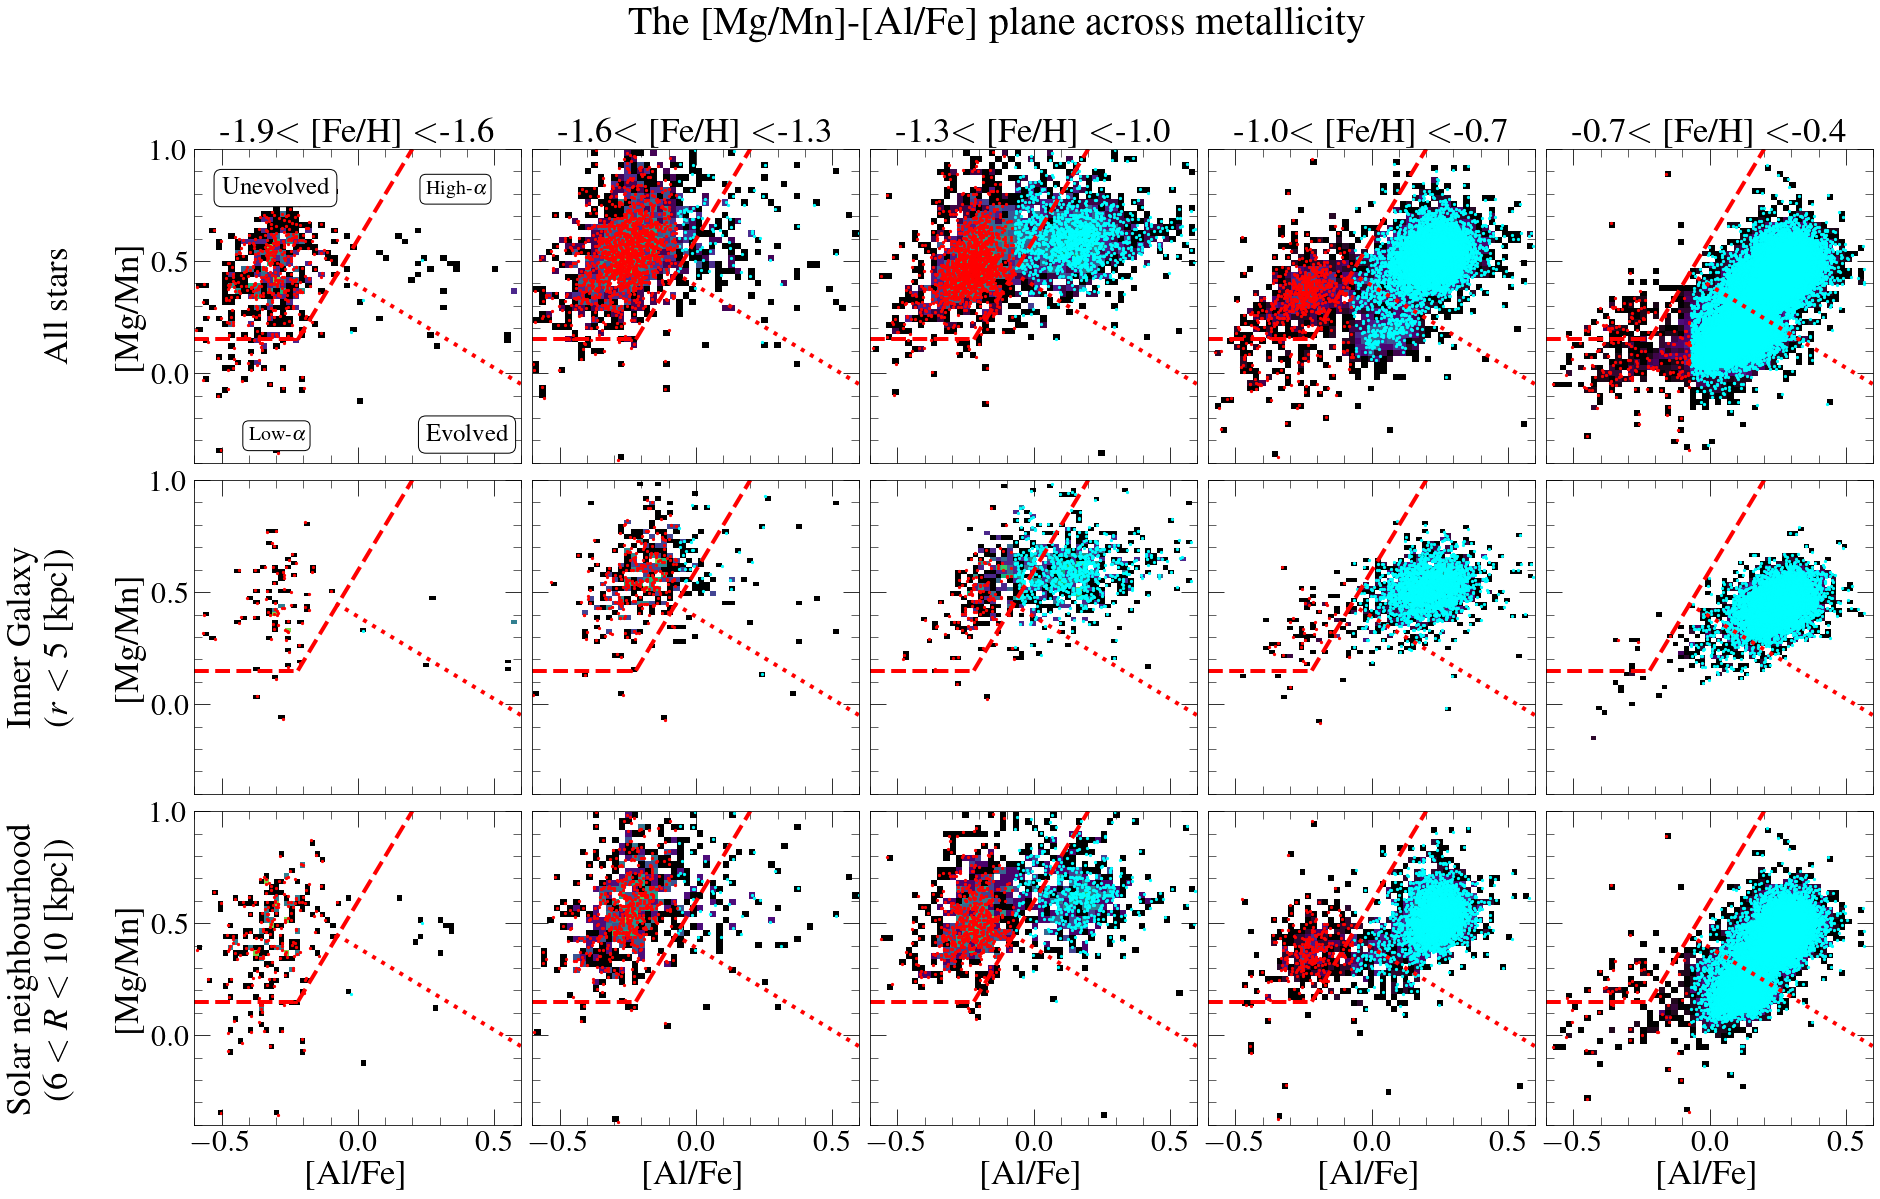

In [ ]:
fig, all_axes = plt.subplots(3,5, constrained_layout=True, figsize=(26, 15), sharex=True, sharey=True,rasterized=True, facecolor='white')
fehs_bins = np.linspace(-1.9,-0.4,6)

fig.suptitle('The [Mg/Mn]-[Al/Fe] plane across metallicity',fontsize=40,x=0.53,y=1.1)

for indx, i in enumerate(fehs_bins[:-1]):
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1])&(data['AL_FE']<0.6)&(data['AL_FE']>-0.6)&(mgmn<1)&(mgmn>-0.4)
    all_axes[0,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=35)    
    all_axes[0,indx].hist2d(data['AL_FE'][mask&m],mgmn[mask&m],bins=50,cmap=cm.lavender, norm=LogNorm())
    all_axes[0,indx].scatter(data['AL_FE'][mask&mask_is_vasily&m],mgmn[mask&mask_is_vasily&m],s=5, c='cyan')
    all_axes[0,indx].scatter(data['AL_FE'][mask&mask_acc_vasily&m],mgmn[mask&mask_acc_vasily&m],s=5, c='r')
#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[0,indx].set_xlabel('[Al/Fe]',fontsize=35)
    all_axes[0,indx].set_xlim(-0.6,0.6)
    all_axes[0,indx].set_ylim(-0.4,1.)
    all_axes[0,indx].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[0,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[0,indx].minorticks_on()    
    all_axes[0,indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[0,indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[0,indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1]) & (rads<5)&(data['AL_FE']<0.6)&(data['AL_FE']>-0.6)&(mgmn<1)&(mgmn>-0.4)
    print(len(data[m]))
#     all_axes[1,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=35)    
    all_axes[1,indx].hist2d(data['AL_FE'][mask&m],mgmn[mask&m],bins=50,cmap=cm.lavender, norm=LogNorm())
    all_axes[1,indx].scatter(data['AL_FE'][mask&mask_is_vasily&m],mgmn[mask&mask_is_vasily&m],s=5, c='cyan')
    all_axes[1,indx].scatter(data['AL_FE'][mask&mask_acc_vasily&m],mgmn[mask&mask_acc_vasily&m],s=5, c='r')#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
#     all_axes[1,indx].set_xlabel('[Al/Fe]',fontsize=35)
    all_axes[1,indx].set_xlim(-0.6,0.6)
    all_axes[1,indx].set_ylim(-0.4,1.)
    all_axes[1,indx].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[1,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[1,indx].minorticks_on()    
    all_axes[1,indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[1,indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[1,indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
    m = (data['FE_H']>i)&(data['FE_H']<fehs_bins[indx+1]) & (Rgal>6) & (Rgal<10)&(data['AL_FE']<0.6)&(data['AL_FE']>-0.6)&(mgmn<1)&(mgmn>-0.4)
#     all_axes[2,indx].set_title(str(round(i,2))+r'$<$ [Fe/H] $<$'+str(round(fehs_bins[indx+1],2)),fontsize=35)    
    print(len(data[m]))
    all_axes[2,indx].hist2d(data['AL_FE'][mask&m],mgmn[mask&m],bins=50,cmap=cm.lavender, norm=LogNorm())
    all_axes[2,indx].scatter(data['AL_FE'][mask&mask_is_vasily&m],mgmn[mask&mask_is_vasily&m],s=5, c='cyan')
    all_axes[2,indx].scatter(data['AL_FE'][mask&mask_acc_vasily&m],mgmn[mask&mask_acc_vasily&m],s=5, c='r')#     all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],s=1,c='k', alpha=0.5)
    all_axes[2,indx].set_xlabel('[Al/Fe]',fontsize=35)
    all_axes[2,indx].set_xlim(-0.6,0.6)
    all_axes[2,indx].set_ylim(-0.4,1.)
    all_axes[2,indx].tick_params(which='major',labelsize=30,direction='in',top=True,right=True,length=16, pad=5)
    all_axes[2,indx].tick_params(which='minor', length=8, direction='in',top=True,right=True)
    all_axes[2,indx].minorticks_on()    
    all_axes[2,indx].plot([-0.22,0.2], [0.15,1], c='r', lw=4, ls='dashed')
    all_axes[2,indx].plot([-0.6,-0.22], [0.15,0.15], c='r', lw=4, ls='dashed')
    all_axes[2,indx].plot([-0.08,0.6], [0.45,-0.05], c='r', lw=4, ls='dotted')
    
all_axes[0,0].set_ylabel('All stars \n \n [Mg/Mn]',fontsize=35, labelpad=5)
all_axes[2,0].set_ylabel('Solar neighbourhood \n ($6< R < 10$ [kpc]) \n \n [Mg/Mn]',fontsize=35, labelpad=5)
all_axes[1,0].set_ylabel('Inner Galaxy \n ($r<5$ [kpc]) \n \n [Mg/Mn]',fontsize=35, labelpad=5)
props = dict(boxstyle='round', facecolor='white', alpha=1)
all_axes[0,0].text(-0.5,0.8,r'Unevolved',fontsize=25,bbox=props)
all_axes[0,0].text(0.25,-0.3,r'Evolved',fontsize=25,bbox=props)
all_axes[0,0].text(0.25,0.8,r'High-$\alpha$',fontsize=20,bbox=props)
all_axes[0,0].text(-0.4,-0.3,r'Low-$\alpha$',fontsize=20,bbox=props)

# fig.savefig('../plots/magnamal-fehs-all.pdf',dpi=150,bbox_inches='tight')
